In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [137]:
raw = mne.io.read_raw_edf('/Users/egorperelygin/Downloads/НормаЭЭГ/KartsevaSI-epi _export.edf',preload=True)
annotations = raw.annotations

Extracting EDF parameters from /Users/egorperelygin/Downloads/НормаЭЭГ/KartsevaSI-epi _export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4031  =      0.000 ...    40.310 secs...


In [1]:
import mne

# Загрузка данных EEGLAB
raw = mne.io.read_raw_edf('/Users/egorperelygin/Downloads/НормаЭЭГ/Vlasov9l_fon_export.edf',preload=True)
annotations = raw.annotations
# print(eeglab_raw.info)

python(94309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Extracting EDF parameters from /Users/egorperelygin/Downloads/НормаЭЭГ/Vlasov9l_fon_export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 31962  =      0.000 ...   319.620 secs...


In [156]:
np.array([10])

array([10])

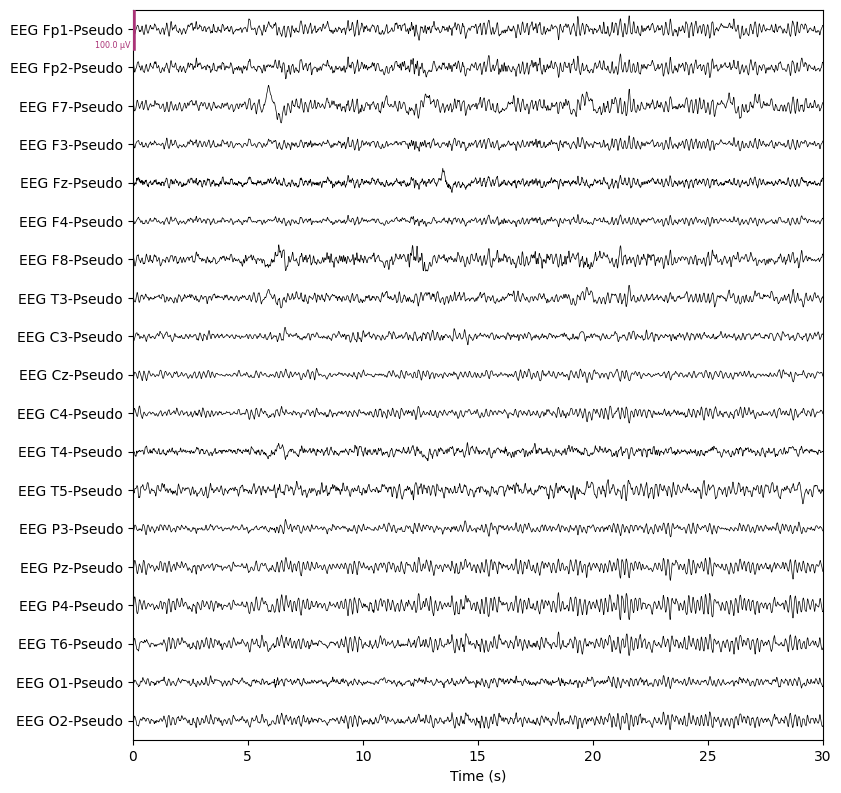

In [155]:
scalings = dict(eeg=500e-7)
p = raw.plot(duration=30, start=0,show_scrollbars=False, scalings=scalings)

In [3]:
fft_data = np.fft.fft(data)

NameError: name 'data' is not defined

In [95]:
fft_data.shape

(19, 46597)

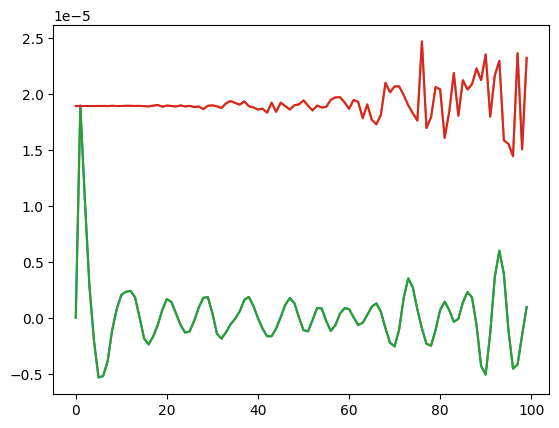

In [97]:
plt.plot(data[0,:100])
plt.plot(fft_data[0,:100])
plt.show()

In [ ]:
fft_data_test = np.

In [ ]:
test_raw = mne.io.read_raw_eeglab('/Users/egorperelygin/EEG/test-epi241024.set',preload=True)

In [94]:
test_raw = mne.io.read_raw_eeglab('/Users/egorperelygin/EEG/panina1.set',preload=True)

Reading /Users/egorperelygin/EEG/panina1.fdt
Reading 0 ... 46596  =      0.000 ...   465.960 secs...


In [31]:
import numpy as np
import scipy.signal as signal

def detect_epileptic_activity(eeg_data, fs):
    """
    Поиск эпилептической активности в ЭЭГ.
    
    :param eeg_data: numpy.ndarray, форма (каналы, сигналы)
    :param fs: частота дискретизации (Гц)
    :return: список [(канал, начало, конец)] найденных событий
    """
    num_channels, num_samples = eeg_data.shape
    results = []

    # Вычисляем среднее значение сигнала для каждого канала
    mean_values = np.mean(eeg_data, axis=1)

    # Фильтры для быстрых и медленных волн
    fast_band = (14, 21)  # Гц
    slow_band = (3.2, 3.4) # Гц (около 3.3)
    
    def bandpass_filter(data, band, fs):
        nyq = 0.5 * fs
        low, high = band[0] / nyq, band[1] / nyq
        b, a = signal.butter(4, [low, high], btype='band')
        return signal.filtfilt(b, a, data)

    for ch in range(num_channels):
        eeg_signal = eeg_data[ch, :]
        fast_signal = bandpass_filter(eeg_signal, fast_band, fs)
        slow_signal = bandpass_filter(eeg_signal, slow_band, fs)
        
        # Проверяем амплитуды и последовательность сигналов
        fast_mask = np.abs(fast_signal) >= 100
        slow_mask = np.abs(slow_signal) >= 100
        events = np.where(fast_mask[:-1] & slow_mask[1:])[0]  # Два подряд сигнала
        
        for event in events:
            results.append((ch, event / fs, (event + 1) / fs))  # Секунды

    return results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def detect_epileptic_activity(eeg_data, fs, time_window):
    """
    Поиск эпилептической активности в ЭЭГ с визуализацией всех каналов на одном графике.

    :param eeg_data: numpy.ndarray, форма (каналы, сигналы)
    :param fs: частота дискретизации (Гц)
    :param time_window: (start_time, end_time) - временной промежуток для визуализации
    :return: список [(канал, начало, конец)] найденных событий
    """
    num_channels, num_samples = eeg_data.shape
    results = []
    
    start_time, end_time = time_window
    start_idx, end_idx = int(start_time * fs), int(end_time * fs)
    print(start_idx, end_idx)
    time = np.arange(start_idx,end_idx,1) / fs  # Время для всего сигнала
    time_zoom = time#[start_idx:end_idx]  # Время для выбранного отрезка
    print(time_zoom)
    # Вычисляем среднее значение для каждого канала
    mean_values = np.mean(eeg_data, axis=1)

    plt.figure(figsize=(12, 6))
    
    # Сдвиг каналов для удобства чтения
    offset = 100  # Разделение между каналами
    yticks = []
    yticklabels = []

    for ch in range(num_channels):
        eeg_signal = eeg_data[ch, start_idx:end_idx]
        eeg_shifted = eeg_signal + ch * offset  # Сдвиг вверх

        above_mean = eeg_signal > mean_values[ch]
        amplitude_mask = np.abs(eeg_signal) >= 30
        active_mask = above_mean  # Основное условие

        # Поиск непрерывных сегментов
        indices = np.where(active_mask)[0]
        if len(indices) == 0:
            continue
        
        segments = []
        start = indices[0]

        for i in range(1, len(indices)):
            if indices[i] != indices[i - 1] + 1:
                segments.append((start, indices[i - 1]))
                start = indices[i]
        segments.append((start, indices[-1]))

        # Анализ частоты
        channel_results = []

        for i in range(len(segments) - 1):
            start1, end1 = segments[i]
            start2, end2 = segments[i + 1]

            # Проверяем, была ли амплитуда ≥ 100 в этих сегментах
            if not (np.any(amplitude_mask[start1:end1+1]) and np.any(amplitude_mask[start2:end2+1])):
                continue

            freq1 = fs / (end1 - start1 + 1) * 2
            freq2 = fs / (end2 - start2 + 1) * 2

            if 2 <= freq1 <= 21 and 0 <= freq2 <= 4:
                channel_results.append((ch, start1 / fs, end2 / fs))

        results.extend(channel_results)
        # Визуализация канала
        plt.plot(time_zoom, eeg_shifted, alpha=0.8)
        plt.axhline(mean_values[ch] + ch * offset, color='green', linestyle="--", alpha=0.7)

        # Отмечаем найденные события
        for (_, ev_start, ev_end) in channel_results:
            if start_time <= ev_start <= end_time or start_time <= ev_end <= end_time:
                plt.axvspan(start_time+ev_start, start_time+ev_end, color='red', alpha=0.3)

        # Запоминаем для разметки оси Y
        yticks.append(ch * offset)
        yticklabels.append(f"Ch {ch}")

    plt.xlabel("Time (s)")
    plt.ylabel("Channels")
    plt.yticks(yticks, yticklabels)
    plt.title(f"EEG Activity from {start_time}s to {end_time}s (All Channels)")
    plt.legend()
    plt.show()

    return results




In [80]:
import numpy as np
import matplotlib.pyplot as plt

def detect_epileptic_activity(eeg_data, fs, time_window, max_threshold_shift, step=5):
    """
    Поиск эпилептической активности в ЭЭГ с вариативным порогом.

    :param eeg_data: numpy.ndarray, форма (каналы, сигналы)
    :param fs: частота дискретизации (Гц)
    :param time_window: (start_time, end_time) - временной промежуток для визуализации
    :param max_threshold_shift: максимальное отклонение от среднего уровня
    :param step: шаг изменения порога
    :return: объединенный список [(канал, начало, конец)] найденных событий
    """
    num_channels, num_samples = eeg_data.shape
    results = []
    
    start_time, end_time = time_window
    start_idx, end_idx = int(start_time * fs), int(end_time * fs)
    time = np.arange(start_idx, end_idx) / fs  # Время для сигнала
    
    mean_values = np.mean(eeg_data, axis=1)
    
    plt.figure(figsize=(12, 6))
    offset = 100  # Разделение между каналами
    yticks, yticklabels = [], []
    
    for ch in range(num_channels):
        eeg_signal = eeg_data[ch, start_idx:end_idx]
        eeg_shifted = eeg_signal + ch * offset  # Сдвиг вверх для визуализации
        plt.plot(time, eeg_shifted, alpha=0.8, label=f'Ch {ch}')
        plt.axhline(mean_values[ch] + ch * offset, color='green', linestyle="--", alpha=0.7)
        
        for shift in np.arange(-max_threshold_shift, max_threshold_shift + step, step):
            threshold = mean_values[ch] + shift
            active_mask = eeg_signal > threshold
            amplitude_mask = np.abs(eeg_signal) >= 30
            
            indices = np.where(active_mask)[0]
            if len(indices) == 0:
                continue
            
            segments = []
            start = indices[0]
            for i in range(1, len(indices)):
                if indices[i] != indices[i - 1] + 1:
                    segments.append((start, indices[i - 1]))
                    start = indices[i]
            segments.append((start, indices[-1]))
            
            for i in range(len(segments) - 1):
                start1, end1 = segments[i]
                start2, end2 = segments[i + 1]
                
                if start2 - end1 > 30:
                    continue
                
                freq1 = fs / (end1 - start1 + 1) * 2
                freq2 = fs / (end2 - start2 + 1) * 2
                
                if 12 <= freq1 <= 17 and 3 <= freq2 <= 3.5:
                    results.append((ch, start_time+start1 / fs, start_time+end2 / fs))
                    plt.axvspan(start_time+start1 / fs, start_time+end2 / fs, color='red', alpha=0.3)
        
        yticks.append(ch * offset)
        yticklabels.append(f"Ch {ch}")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Channels")
    plt.yticks(yticks, yticklabels)
    plt.title(f"EEG Activity from {start_time}s to {end_time}s (All Channels)")
    plt.legend()
    plt.show()
    
    return results


In [81]:
test_raw = mne.io.read_raw_eeglab('merged_data.set',preload=True)

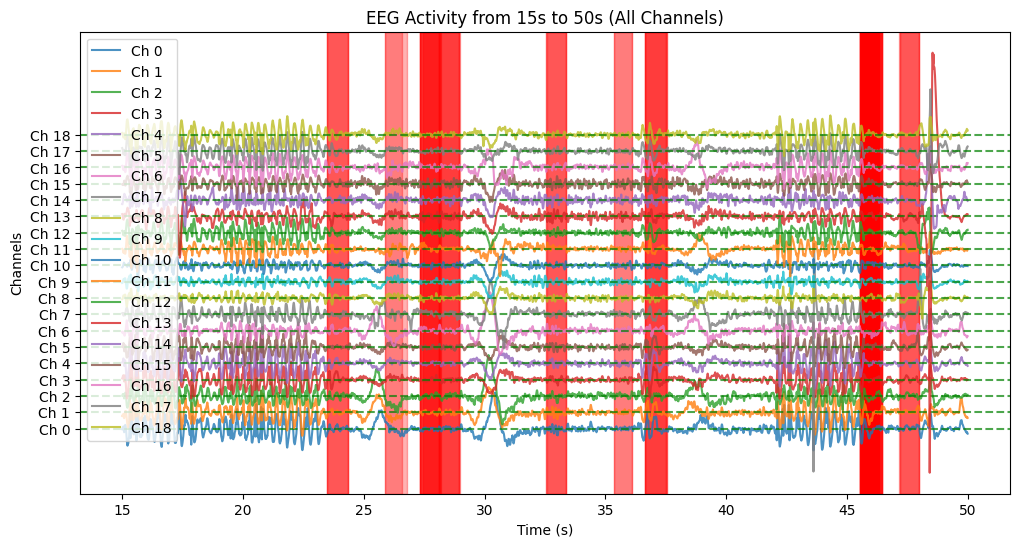

In [82]:
t = detect_epileptic_activity(test_raw.get_data()*1000000, 100, (15, 50), 20, 1)

In [79]:
t

[(0, 45.66, 46.59),
 (0, 45.67, 46.59),
 (0, 45.67, 46.58),
 (0, 45.67, 46.58),
 (0, 33.980000000000004, 34.61),
 (0, 45.67, 46.58),
 (0, 45.67, 46.57),
 (0, 45.67, 46.57),
 (0, 38.41, 39.5),
 (0, 45.67, 46.57),
 (0, 47.17, 48.0),
 (0, 45.67, 46.57),
 (0, 47.17, 47.99),
 (0, 47.18, 47.99),
 (0, 47.18, 47.99),
 (0, 38.64, 39.489999999999995),
 (0, 38.64, 39.489999999999995),
 (0, 38.64, 39.489999999999995),
 (0, 38.64, 39.489999999999995),
 (0, 38.64, 39.489999999999995),
 (0, 38.64, 39.489999999999995),
 (0, 38.64, 39.480000000000004),
 (0, 38.64, 39.480000000000004),
 (1, 32.89, 33.85),
 (1, 36.629999999999995, 37.54),
 (1, 40.04, 40.97),
 (1, 36.64, 37.53),
 (1, 40.04, 40.97),
 (1, 36.64, 37.53),
 (1, 36.64, 37.519999999999996),
 (1, 28.630000000000003, 29.39),
 (1, 36.64, 37.510000000000005),
 (1, 28.630000000000003, 29.39),
 (1, 28.630000000000003, 29.380000000000003),
 (1, 34.81, 35.739999999999995),
 (1, 45.66, 46.78),
 (1, 34.81, 35.730000000000004),
 (1, 34.82, 35.64),
 (1, 34.

In [64]:
t = detect_epileptic_activity(test_raw.get_data()*1000000, 100, (0, 30))

TypeError: detect_epileptic_activity() missing 1 required positional argument: 'max_threshold_shift'

In [75]:
t

[(0, 1.68, 3.66),
 (0, 11.34, 12.48),
 (0, 34.57, 36.45),
 (0, 38.41, 39.99),
 (0, 41.96, 43.18),
 (0, 42.5, 44.53),
 (0, 54.81, 56.76),
 (0, 61.98, 63.63),
 (0, 75.29, 77.05),
 (0, 79.97, 81.71),
 (0, 82.8, 84.79),
 (0, 86.56, 87.72),
 (0, 87.15, 89.26),
 (0, 93.29, 94.97),
 (1, 1.65, 3.62),
 (1, 7.37, 9.22),
 (1, 31.02, 33.0),
 (1, 34.58, 36.43),
 (1, 38.51, 40.04),
 (1, 41.94, 43.19),
 (1, 54.88, 56.13),
 (1, 61.87, 63.55),
 (1, 68.63, 70.87),
 (1, 75.15, 76.9),
 (1, 79.87, 81.69),
 (1, 82.78, 84.68),
 (1, 87.14, 89.27),
 (1, 90.55, 92.29),
 (1, 93.11, 95.06),
 (3, 1.69, 3.42),
 (3, 7.38, 9.26),
 (3, 18.51, 20.04),
 (3, 25.74, 27.56),
 (3, 34.81, 36.46),
 (3, 38.42, 39.85),
 (3, 39.12, 41.69),
 (3, 41.96, 43.18),
 (3, 42.62, 44.56),
 (3, 47.29, 49.1),
 (3, 50.9, 52.43),
 (3, 54.63, 56.58),
 (3, 61.97, 63.51),
 (3, 68.76, 70.88),
 (3, 75.07, 77.17),
 (3, 79.95, 81.75),
 (3, 82.99, 84.8),
 (3, 87.29, 89.25),
 (3, 90.55, 92.32),
 (3, 93.3, 95.09),
 (3, 95.32, 97.27),
 (4, 1.67, 3.43),


In [35]:
def bandpass_filter(data, band, fs):
    nyq = 0.5 * fs
    low, high = band[0] / nyq, band[1] / nyq
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [36]:
test_data = test_raw.get_data()

In [37]:
eeg_signal = test_data[7, :]
fast_band = (14, 21)  # Гц
fast_signal = bandpass_filter(eeg_signal, fast_band, 100)

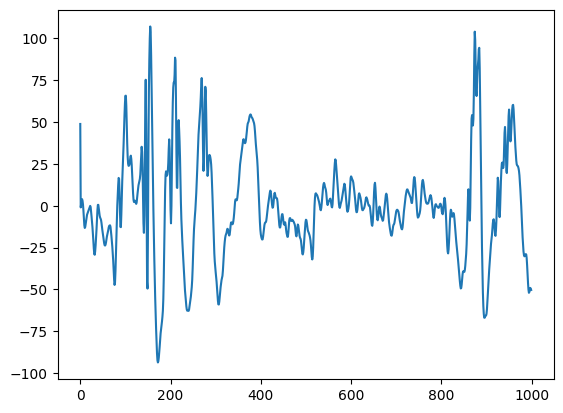

In [43]:
plt.plot(test_data[3, :1000]*1000000)

In [123]:
for i, (onset, duration, description) in enumerate(zip(annotations.onset, annotations.duration, annotations.description)):
    print(f"Аннотация {i + 1}:")
    print(f"  Начало: {onset} сек")
    print(f"  Длительность: {duration} сек")
    print(f"  Описание: {description}")

Аннотация 1:
  Начало: 1.45 сек
  Длительность: 0.56 сек
  Описание: ANOMALY
Аннотация 2:
  Начало: 4.18 сек
  Длительность: 0.76 сек
  Описание: ANOMALY
Аннотация 3:
  Начало: 5.04 сек
  Длительность: 1.94 сек
  Описание: ANOMALY
Аннотация 4:
  Начало: 7.53 сек
  Длительность: 0.53 сек
  Описание: ANOMALY
Аннотация 5:
  Начало: 9.37 сек
  Длительность: 1.18 сек
  Описание: ANOMALY
Аннотация 6:
  Начало: 13.8 сек
  Длительность: 1.01 сек
  Описание: ANOMALY
Аннотация 7:
  Начало: 16.27 сек
  Длительность: 2.47 сек
  Описание: ANOMALY
Аннотация 8:
  Начало: 19.42 сек
  Длительность: 1.33 сек
  Описание: ANOMALY
Аннотация 9:
  Начало: 21.26 сек
  Длительность: 2.2 сек
  Описание: ANOMALY
Аннотация 10:
  Начало: 26.91 сек
  Длительность: 0.76 сек
  Описание: ANOMALY
Аннотация 11:
  Начало: 28.28 сек
  Длительность: 0.74 сек
  Описание: ANOMALY
Аннотация 12:
  Начало: 29.28 сек
  Длительность: 0.51 сек
  Описание: ANOMALY
Аннотация 13:
  Начало: 33.35 сек
  Длительность: 0.51 сек
  Описани

In [9]:
events

array([[  142,     0,     3],
       [  143,     0,     1],
       [  153,     0,     2],
       ...,
       [46341,     0,     3],
       [46348,     0,     1],
       [46354,     0,     2]])

In [149]:

# Добавляем аннотации
annotations = mne.Annotations(
    onset=[start / raw.info['sfreq'] for start, _ in anomaly_segments],  # Время в секундах
    duration=[(end - start) / raw.info['sfreq'] for start, end in anomaly_segments],
    description=['ANOMALY'] * len(anomaly_segments)  # Описание аномалий
)
test_raw.set_annotations(annotations)
# mne.export.export_raw('/Users/egorperelygin/EEG/test-epi241024_ann2.set', test_raw1, overwrite=True)
# scalings = dict(eeg=500e-7)
# p = test_raw.plot(duration=5, start=100,show_scrollbars=False, scalings=scalings)

<RawEEGLAB | test-epi241024.fdt, 19 x 81280 (812.8 s), ~11.8 MB, data loaded>

In [131]:
mne.export.export_raw('/Users/egorperelygin/EEG/test-epi241024_ann2.set', test_raw1, overwrite=True)

Overwriting existing file.


In [72]:
pip install eeglabio


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
filter_data = raw.get_data()

In [16]:
filter_test_data = test_raw.get_data()

In [17]:
data - filter_data

array([[-2.62072601e-05, -1.70550444e-05, -9.23432265e-06, ...,
         2.04464447e-06,  2.15715728e-06,  2.20016789e-06],
       [-3.58079987e-05, -2.32464697e-05, -1.23897797e-05, ...,
         5.87335481e-06,  6.11727834e-06,  6.30047989e-06],
       [-1.17061577e-05, -8.15428012e-06, -5.42568094e-06, ...,
        -4.60598604e-07,  2.93876498e-07,  1.10008383e-06],
       ...,
       [ 2.31965065e-05,  1.42439849e-05,  6.54706650e-06, ...,
         3.66917934e-06,  3.69702035e-06,  3.60027480e-06],
       [ 6.51997147e-05,  4.19011021e-05,  2.16921851e-05, ...,
        -2.08939745e-07,  6.34243770e-07,  1.40010691e-06],
       [ 5.71991005e-05,  3.61777629e-05,  1.79832145e-05, ...,
        -3.74835734e-07,  5.86300891e-07,  1.50011444e-06]])

In [14]:
test_raw.filter(l_freq=10.0, h_freq=40.0)
raw.filter(l_freq=10.0, h_freq=40.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 133 samples (1.330 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


<RawEEGLAB | panina1.fdt, 19 x 46597 (466.0 s), ~6.8 MB, data loaded>

In [ ]:
#ft, вопросы 

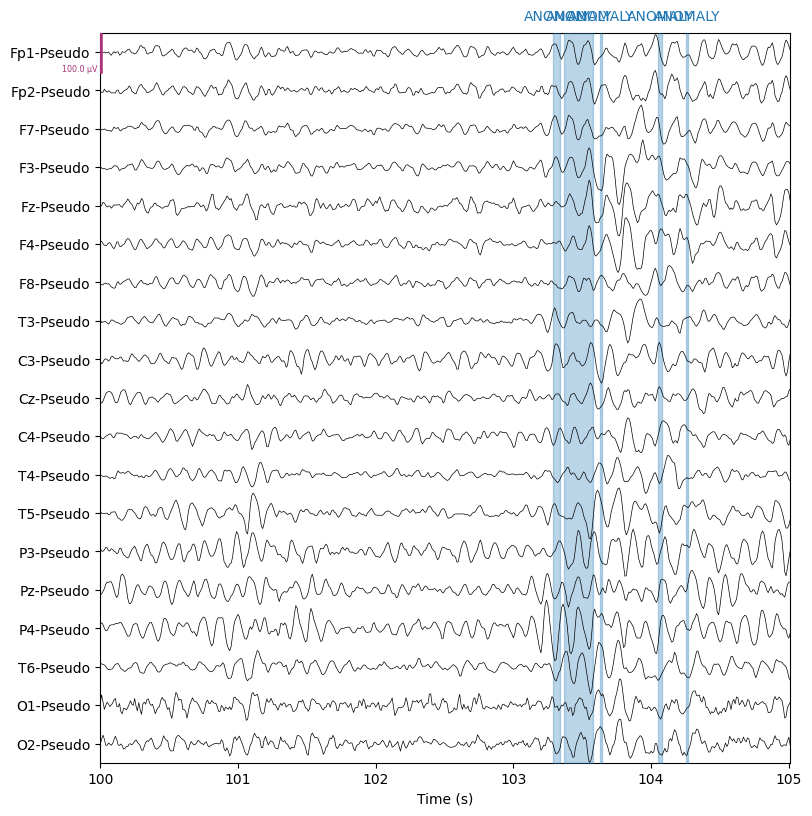

In [151]:
scalings = dict(eeg=500e-7)
p = test_raw.plot(duration=5, start=100,show_scrollbars=False, scalings=scalings)

In [ ]:
#сложить сигнал

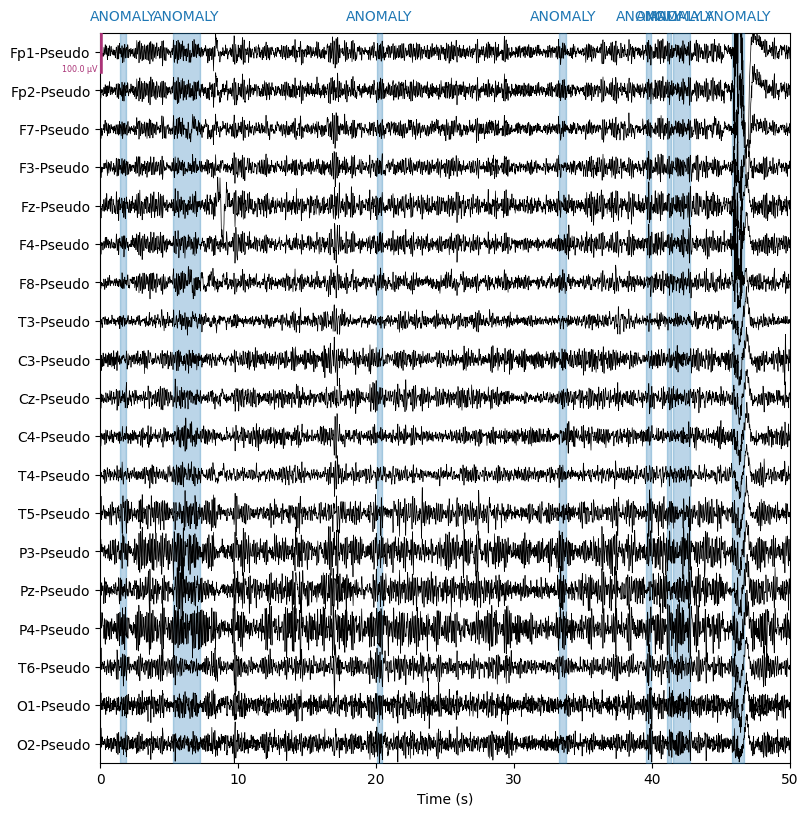

In [146]:
scalings = dict(eeg=500e-7)
p = test_raw1.plot(duration=50, start=0,show_scrollbars=False, scalings=scalings)

In [40]:
data = raw.get_data()
#  

In [41]:
data.shape

(19, 46597)

In [47]:
import cv2


AttributeError: module 'cv2' has no attribute 'reshape'

In [52]:
im = cv2.resize(data[:, :500],(500,100))

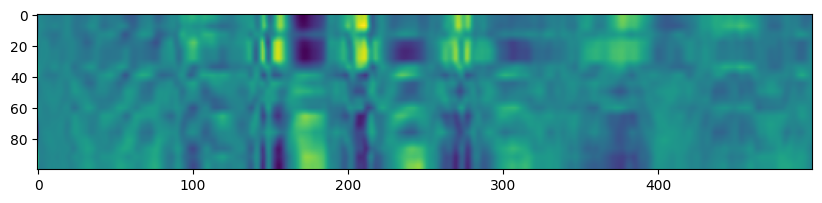

In [53]:
import matplotlib.pyplot as plt

# Задание размера изображения
plt.figure(figsize=(10, 10))  # Ширина = 10 дюймов, высота = 5 дюймов

# Отображение данных
plt.imshow(im)
plt.show()

In [9]:
test_data = test_raw.get_data()

In [114]:
test_data

array([[ 2.22516975e-05,  7.35056067e-06, -6.50049567e-07, ...,
         1.29509878e-05,  1.69512939e-05,  1.97515068e-05],
       [ 2.60519867e-05,  1.71513081e-05,  5.05038548e-06, ...,
         1.59512167e-05,  1.96514988e-05,  2.00515289e-05],
       [ 8.45064449e-06, -3.15024042e-06, -6.95053005e-06, ...,
         1.18509045e-05,  1.42510872e-05,  1.79513702e-05],
       ...,
       [-3.50526733e-05, -4.08531151e-05, -3.48526573e-05, ...,
        -8.65065956e-06, -1.94514847e-05, -2.57519646e-05],
       [-3.81529121e-05, -2.96522617e-05, -1.41510792e-05, ...,
        -1.24509497e-05, -2.30517578e-05, -2.73520870e-05],
       [-4.00530548e-05, -2.85521774e-05, -1.99515228e-05, ...,
        -9.25070572e-06, -2.52519264e-05, -3.49526672e-05]])

In [2]:
# Извлечение событий
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['User', 'end', 'start']


In [3]:
events

array([[  142,     0,     3],
       [  143,     0,     1],
       [  153,     0,     2],
       ...,
       [46341,     0,     3],
       [46348,     0,     1],
       [46354,     0,     2]])

In [5]:
import mne
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader



In [4]:
# Загрузка данных EEG из файла .set
raw = mne.io.read_raw_eeglab('/Users/egorperelygin/EEG/test-epi241024.set', preload=True)

# Извлечение событий
events, event_id = mne.events_from_annotations(raw)

# Параметры данных
n_channels = 19


# Получение данных и разбиение на окна
data = raw.get_data()[:n_channels]  # Получаем данные с первых 20 каналов




Reading /Users/egorperelygin/EEG/test-epi241024.fdt
Reading 0 ... 81279  =      0.000 ...   812.790 secs...


In [36]:
data.shape

(19, 46597)

In [7]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['User']


In [6]:
events[300,0]

34175

In [7]:
train_data = data[:,:events[300,0]]
val_data = data[:,events[300,0]:]

In [18]:
train_data_filter = filter_data[:,:events[100,0]]
val_data_filter = filter_data[:,events[100,0]:]

In [6]:
import numpy as np
def create_windows(data_train, data_test, events, window_size):
    X = []
    y = []
    X_test = []
    y_test = []

    n_samples = data_train.shape[1]

    def is_window_in_event(i, window_size, events):
        for start, _, event_type in events:
            if i + window_size > start:
                if event_type == 3:  # Start of event
                    end = next((e[0] for e in events if e[0] > start and e[2] == 2), None)
                    if end and i < end:
                        return True
        return False

    for i in range(0, n_samples - window_size, 1):
        window = data_train[:, i:i + window_size]
        event_in_window = is_window_in_event(i, window_size, events)

        label = 1 if event_in_window else 0
        X.append(window.T)
        y.append(label)
        if i % 10000 == 0:
            print(i)

    for i in range(n_samples, n_samples + data_test.shape[1] - window_size, 1):
        window = data_test[:, i - n_samples:i - n_samples + window_size]
        event_in_window = is_window_in_event(i, window_size, events)

        label = 1 if event_in_window else 0
        X_test.append(window.T)
        y_test.append(label)
        if i % 10000 == 0:
            print(i)

    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)

In [10]:
#изменить разметку
# Пример функции для разбиения на окна
def create_windows(data_train, data_test, events, window_size):
    X = []
    y = []
    X_test = []
    y_test = []
    n_samples = data_train.shape[1]
    print(window_size//2)
    for i in range(0, n_samples - window_size, 1):
        window = data[:, i:i+window_size]
        event_in_window = np.any([e[0] >= i + 2 and e[0] < i + window_size - 2 for e in events])
        something_in_window = np.any([e[0] >= i - window_size//2 and e[0] < i + window_size + window_size//2 for e in events])
        if not event_in_window and something_in_window:
            continue
        X.append(window.T)
        y.append(int(event_in_window))  # Метка: 1 - событие, 0 - нет
    for i in range(n_samples, n_samples+data_test.shape[1]-window_size,1):
        window = data_test[:, i-n_samples:i-n_samples+window_size]
        event_in_window = np.any([e[0] >= i + 2 and e[0] < i + window_size - 2 for e in events])
        something_in_window = False#np.any([e[0] >= i - window_size//2 and e[0] < i + window_size + window_size//2 for e in events])
        if not event_in_window and something_in_window:
            continue
        X_test.append(window.T)
        y_test.append(int(event_in_window))  # Метка: 1 - событие, 0 - нет
    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)

In [7]:
def create_test_windows(data, window_size):
    X = []
    y = []
    n_samples = data.shape[1]
    print(window_size//2)
    for i in range(0, n_samples - window_size, 1):
        window = data[:, i:i+window_size]
        X.append(window.T)
        
    return np.array(X)

In [8]:
#изменить разметку
# Пример функции для разбиения на окна
def create_windows_fft(data_train, data_test, train_data_filter, test_data_filter, events, window_size):
    X = []
    y = []
    X_test = []
    y_test = []
    n_samples = data_train.shape[1]
    print(window_size//2)
    for i in range(0, n_samples - window_size, 1):
        window = data[:, i:i+window_size]
        event_in_window = np.any([e[0] >= i + 2 and e[0] < i + window_size - 2 for e in events])
        something_in_window = np.any([e[0] >= i - window_size//2 and e[0] < i + window_size + window_size//2 for e in events])
        if not event_in_window and something_in_window:
            continue
        fft_window = np.fft.fft(window)
        X.append(fft_window.T)
        y.append(int(event_in_window))  # Метка: 1 - событие, 0 - нет
    for i in range(n_samples, n_samples+data_test.shape[1]-window_size,1):
        window = data_test[:, i-n_samples:i-n_samples+window_size]
        event_in_window = np.any([e[0] >= i + 2 and e[0] < i + window_size - 2 for e in events])
        something_in_window = False#np.any([e[0] >= i - window_size//2 and e[0] < i + window_size + window_size//2 for e in events])
        if not event_in_window and something_in_window:
            continue
        fft_window = np.fft.fft(window)
        X_test.append(fft_window.T)
        y_test.append(int(event_in_window))  # Метка: 1 - событие, 0 - нет
    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)

In [13]:
def create_test_windows_fft(data, window_size):
    X = []
    y = []
    n_samples = data.shape[1]
    print(window_size//2)
    for i in range(0, n_samples - window_size, 1):
        window = data[:, i:i+window_size]
        fft_window = np.fft.fft(window)
        X.append(fft_window.T)
        
    return np.array(X)

In [ ]:
#изменить разметку
# Пример функции для разбиения на окна
def create_3data_windows(data_train, data_test, events, window_size):
    X = []
    y = []
    X_test = []
    y_test = []
    n_samples = data_train.shape[1]
    print(window_size//2)
    for i in range(0, n_samples - window_size, 1):
        window = data[:, i:i+window_size]
        event_in_window = np.any([e[0] >= i + 2 and e[0] < i + window_size - 2 for e in events])
        something_in_window = np.any([e[0] >= i - window_size//2 and e[0] < i + window_size + window_size//2 for e in events])
        if not event_in_window and something_in_window:
            continue
        X.append(window.T)
        y.append(int(event_in_window))  # Метка: 1 - событие, 0 - нет
    for i in range(n_samples, n_samples+data_test.shape[1]-window_size,1):
        window = data_test[:, i-n_samples:i-n_samples+window_size]
        event_in_window = np.any([e[0] >= i + 2 and e[0] < i + window_size - 2 for e in events])
        something_in_window = False#np.any([e[0] >= i - window_size//2 and e[0] < i + window_size + window_size//2 for e in events])
        if not event_in_window and something_in_window:
            continue
        X_test.append(window.T)
        y_test.append(int(event_in_window))  # Метка: 1 - событие, 0 - нет
    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)

In [101]:
X_train_32.shape

(6920, 32, 19)

In [76]:
window_size = 32  # Количество временных шагов в каждом окне
X_train_32_fft, y_train_32, X_val_32_fft, y_val_32 = create_windows_fft(train_data, val_data, events, window_size)

16


In [17]:
window_size = 32  # Количество временных шагов в каждом окне
X_train_32, y_train_32, X_val_32, y_val_32 = create_windows(train_data, val_data, events, window_size)

0
10000
20000
30000
40000


In [27]:
X_train_32.shape

(34143, 32, 19)

In [10]:
X_test_32 = create_test_windows(test_data, 32)

16


In [44]:
import numpy as np
import random
import os
from mne.io import read_raw_edf

def load_random_edf_files(folder_path, num_files, required_channels=19):
    """Load random .edf files from the specified folder, filtering by channel count."""
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.edf')]
    valid_files = []

    for file in all_files[:30]:
        raw = read_raw_edf(os.path.join(folder_path, file), preload=True, verbose=False)
        data = raw.get_data()
        if data.shape[0] == required_channels:  # Ensure the file has the required number of channels
            valid_files.append(file)

    if len(valid_files) < num_files:
        raise ValueError(f"Not enough files with {required_channels} channels. Found {len(valid_files)} files.")

    selected_files = random.sample(valid_files, num_files)
    data_list = []

    for file in selected_files:
        raw = read_raw_edf(os.path.join(folder_path, file), preload=True, verbose=False)
        data = raw.get_data()
        data_list.append(data)

    return data_list

def create_windows_no_events(data_list, window_size):
    """Create windows with no events, assigning all labels as 0."""
    X = []
    y = []

    for data in data_list:
        n_samples = data.shape[1]
        print(n_samples, n_samples // (100 * window_size))
        step_size = max(1, n_samples // (100 * window_size))  # Adjust step size based on file size

        for i in range(0, n_samples - window_size + 1, step_size):
            window = data[:, i:i + window_size]
            X.append(window.T)  # Keep the original shape (channels, window_size)
            y.append(0)  # All labels are 0 since there are no events

    return np.array(X), np.array(y)

def main(folder_path, window_size):
    """Main function to process EEG data."""
    # Load 20 random .edf files
    data_list = load_random_edf_files(folder_path, 20)

    # Split into 10 train and 10 test
    train_data = data_list[:10]
    test_data = data_list[10:]
    for data in train_data:
        print(data.shape)
    for data in test_data:
        print(data.shape)
    
    # Create windows
    X_train, y_train = create_windows_no_events(train_data, window_size)
    X_test, y_test = create_windows_no_events(test_data, window_size)

    return X_train, y_train, X_test, y_test

# Example usage
folder_path = "/Users/egorperelygin/Downloads/НормаЭЭГ"
window_size = 32  # Example window size
X_train_add, y_train_add, X_test_add, y_test_add = main(folder_path, window_size)

/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_10373/195396220.py:12: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG P3-Pseudo'}. Applying running numbers for duplicates.
  raw = read_raw_edf(os.path.join(folder_path, file), preload=True, verbose=False)


(19, 14164)
(19, 6889265)
(19, 11379)
(19, 8978)
(19, 46597)
(19, 1965)
(19, 18782)
(19, 14568)
(19, 13227)
(19, 35931)
(19, 1349)
(19, 3645)
(19, 26361)
(19, 11361)
(19, 4217)
(19, 1336)
(19, 32816)
(19, 5195)
(19, 97769)
(19, 41913)
14164 4
6889265 2152
11379 3
8978 2
46597 14
1965 0
18782 5
14568 4
13227 4
35931 11
1349 0
3645 1
26361 8
11361 3
4217 1
1336 0
32816 10
5195 1
97769 30
41913 13


In [45]:
X_train_add.shape

(34203, 32, 19)

In [46]:
X_train_32.shape

(34143, 32, 19)

In [41]:
y_train_add.shape

(34210,)

In [47]:
X_train_32 = np.concatenate((X_train_32, X_train_add), axis=0)
y_train_32 = np.concatenate((y_train_32, y_train_add), axis=0)

In [48]:
X_val_32 = np.concatenate((X_val_32, X_train_add), axis=0)
y_val_32 = np.concatenate((y_val_32, y_train_add), axis=0)

In [60]:
window_size = 32  # Количество временных шагов в каждом окне
X_train_32_filter, y_train_32, X_val_32_filter, y_val_32 = create_windows(train_data_filter, val_data_filter, events, window_size)

16


In [61]:
X_train_32.shape

(30567, 32, 19)

In [62]:
window_size = 32  # Количество временных шагов в каждом окне
X_test_32_fft = create_test_windows_fft(test_data, window_size)
X_test_32 = create_test_windows(test_data, window_size)
X_test_32_filter = create_test_windows(filter_test_data, window_size)

16
16
16


In [63]:
y_train_32.mean()

0.09160205450322242

In [64]:
X_val_32.shape

(12388, 32, 19)

In [65]:
X_train = np.zeros((30567, 3, 32, 19))
X_val = np.zeros((12388, 3, 32, 19))
X_test = np.zeros((81248, 3, 32, 19))

In [66]:
X_train[:,0,:,:] = X_train_32
X_train[:,1,:,:] = X_train_32_fft
X_train[:,2,:,:] = X_train_32_filter

/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_86307/2352365383.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train[:,1,:,:] = X_train_32_fft


In [67]:
X_val[:,0,:,:] = X_val_32
X_val[:,1,:,:] = X_val_32_fft
X_val[:,2,:,:] = X_val_32_filter

/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_86307/1813769078.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  X_val[:,1,:,:] = X_val_32_fft


In [68]:
X_test[:,0,:,:] = X_test_32
X_test[:,1,:,:] = X_test_32_fft
X_test[:,2,:,:] = X_test_32_filter

/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_86307/386370936.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test[:,1,:,:] = X_test_32_fft


In [9]:
X_test_32.shape

(12388, 32, 19)

In [64]:
window_size = 16  # Количество временных шагов в каждом окне
X_train_16, y_train_16, X_test_16, y_test_16 = create_windows(train_data, test_data, events, window_size)

8


In [65]:
window_size = 24  # Количество временных шагов в каждом окне
X_train_24, y_train_24, X_test_24, y_test_24 = create_windows(train_data, test_data, events, window_size)

12


In [66]:
window_size = 48  # Количество временных шагов в каждом окне
X_train_48, y_train_48, X_test_48, y_test_48 = create_windows(train_data, test_data, events, window_size)

24


In [67]:
X_train_48.shape, X_test_32.shape

((29537, 48, 19), (9141, 32, 19))

In [43]:
y_train_32.sum(), y_val_32.sum()

(2800, 2688)

In [75]:
def filter_train(X,y,window_size):
    X_new = []
    y_new = []
    for i in range(len(X)):
        if y[i] == 1:
            y_new.append(y[i])
            X_new.append(X[i,:,:].reshape(1,3,window_size,19))
        else:
            if np.random.uniform(0,1) < 0.15:
                y_new.append(y[i])
                X_new.append(X[i,:,:].reshape(1,3,window_size,19))
    X_new = np.concatenate(X_new)
    y_new = np.array(y_new)
    return X_new, y_new
    

In [72]:
def filter_train(X,y,window_size):
    X_new = []
    y_new = []
    for i in range(len(X)):
        if y[i] == 1:
            y_new.append(y[i])
            X_new.append(X[i,:,:,:])
        else:
            if np.random.uniform(0,1) < 0.15:
                y_new.append(y[i])
                X_new.append(X[i,:,:,:])
    X_new = np.concatenate(X_new)
    y_new = np.array(y_new)
    return X_new, y_new

In [77]:
X_train_32, y_train_32 = filter_train(X_train, y_train_32,32)

In [78]:
X_train_32.shape

(6920, 3, 32, 19)

In [71]:
X_train_16, y_train_16 = filter_train(X_train_16, y_train_16,16)
X_train_24, y_train_24 = filter_train(X_train_24, y_train_24,24)
X_train_48, y_train_48 = filter_train(X_train_48, y_train_48,48)

In [121]:
X_train_32.shape

(7101, 32, 19)

In [3]:
import torch.nn as nn

class EEGEventTransformer(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, hidden_dim, output_dim=1):
        super(EEGEventTransformer, self).__init__()
        
        self.transformer = nn.Transformer(
            d_model=input_dim,  # Число каналов
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim,
            dropout=0.1
        )
        
        self.fc = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [batch_size, sequence_length, num_channels]
        x = x.permute(1, 0, 2)  # Изменяем порядок на [sequence_length, batch_size, num_channels]
        transformer_out = self.transformer(x, x)
        transformer_out = transformer_out[-1, :, :]  # Берём только последнее состояние
        output = self.fc(transformer_out)
        output = self.sigmoid(output)  # Получаем вероятность события
        return output

# Параметры модели
input_dim = 19  # Число каналов
nhead = 1       # Количество голов в multi-head attention
num_layers = 2  # Количество слоёв энкодера и декодера
hidden_dim = 128  # Размер скрытых слоёв

model = EEGEventTransformer(input_dim, nhead, num_layers, hidden_dim)

In [2]:
# Check that MPS is available
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [99]:
mps_device

device(type='mps')

In [50]:
X_new.shape

NameError: name 'X_new' is not defined

In [79]:
class EEGConvNet(nn.Module):
    def __init__(self, num_channels, window_size):
        super(EEGConvNet, self).__init__()
        
        # Первый сверточный слой
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        
        # Второй сверточный слой
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(16)
        
        # Третий сверточный слой
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(8)

        # Полносвязный слой
        self.fc1 = nn.Linear(8 * (window_size // 8), 64)
        self.fc2 = nn.Linear(64, 1)  # Для бинарной классификации
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Прямое распространение
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        # Преобразуем данные перед полносвязными слоями
        x = x.view(x.size(0), -1)  # Извлечение признаков
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        
        return x

NameError: name 'nn' is not defined

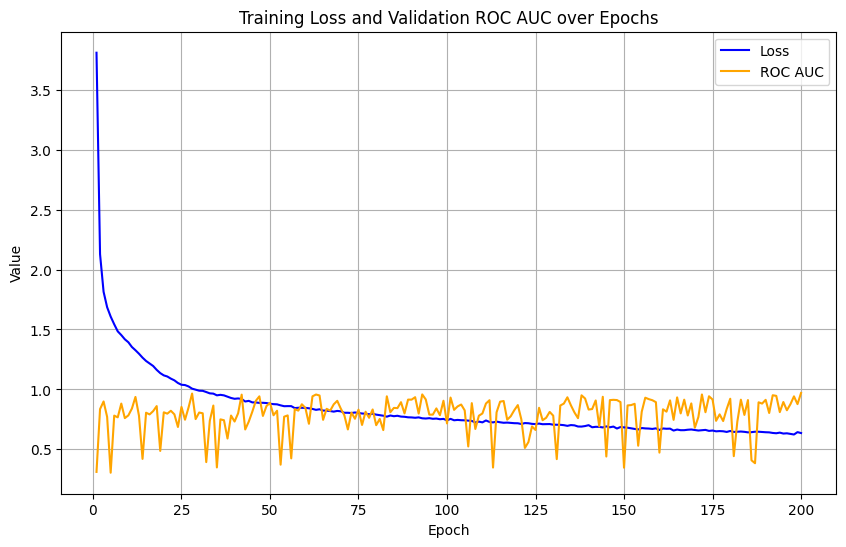

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label="Loss", color="blue")
plt.plot(epochs, rocauc, label="ROC AUC", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation ROC AUC over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
max(rocauc)

0.9703

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
pred = [0.1,0.5,1.3,-0.3]
y = [0,1,-1,0]
roc_auc_score(y, pred)

ValueError: multi_class must be in ('ovo', 'ovr')

In [52]:
import numpy as np

def roc_auc_per_user(r_true, r_pred):
    """
    Calculate ROC AUC for a single user.

    Parameters:
        r_true (list or np.array): True reactions of the user to items.
        r_pred (list or np.array): Predicted scores of the user to items.

    Returns:
        float: ROC AUC for the user.
    """
    n_items = len(r_true)
    auc_numerator = 0
    auc_denominator = 0

    for i in range(n_items):
        for j in range(n_items):
            if r_true[i] < r_true[j]:
                auc_denominator += 1
                print("count", i, j)
                if r_pred[i] < r_pred[j]:
                    print(i, j)
                    auc_numerator += 1
                elif r_pred[i] == r_pred[j]:
                    auc_numerator += 0.5

    return auc_numerator / auc_denominator if auc_denominator > 0 else 0.0

def roc_auc(r_true_dict, r_pred_dict):
    """
    Calculate the overall ROC AUC metric.

    Parameters:
        r_true_dict (dict): Dictionary where keys are user IDs and values are lists of true reactions.
        r_pred_dict (dict): Dictionary where keys are user IDs and values are lists of predicted scores.

    Returns:
        float: Overall ROC AUC metric.
    """
    user_ids = r_true_dict.keys()
    auc_sum = 0

    for user_id in user_ids:
        r_true = r_true_dict[user_id]
        r_pred = r_pred_dict[user_id]
        auc_sum += roc_auc_per_user(r_true, r_pred)

    return auc_sum / len(user_ids)

# Example usage:
r_true_dict = {
#     "user1": [1, 0, 0, 1],
    "user2": [-1, 1, 0, 1]
}
r_pred_dict = {
#     "user1": [0.8, 0.2, 0.5, 0.9],
    "user2": [0.1, 0.4, 0.3, -1]
}

roc_auc_score = roc_auc(r_true_dict, r_pred_dict)
print(f"Overall ROC AUC: {roc_auc_score:.4f}")

count 0 1
0 1
count 0 2
0 2
count 0 3
count 2 1
2 1
count 2 3
Overall ROC AUC: 0.6000


In [105]:
# Функция потерь и оптимизатор
model = EEGConvNet(num_channels, window_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Датасет и загрузчик данных
class EEGDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Пример создания модели
window_size = X_new.shape[1]  # Размер окна (window_W)
num_channels = X_new.shape[2]  # Количество каналов (Nchannels)

model = EEGConvNet(num_channels=num_channels, window_size=window_size)

dataset = EEGDataset(X_new, y_new)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Обучение модели
num_epochs = 100
model.train()
model.to(mps_device)

for epoch in range(num_epochs):
    running_loss = 0.0
    c = 1
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs = inputs.permute(0, 2, 1).to(mps_device)  # Преобразуем данные в (batch_size, Nchannels, window_W)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.to(mps_device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        c+=1
    print(f'Epoch [{epoch+1}/{num_epochs}], step {c}, Loss: {running_loss/c:.4f}')

Epoch [1/100], step 29, Loss: 0.6811
Epoch [2/100], step 29, Loss: 0.6793
Epoch [3/100], step 29, Loss: 0.6814
Epoch [4/100], step 29, Loss: 0.6801
Epoch [5/100], step 29, Loss: 0.6803
Epoch [6/100], step 29, Loss: 0.6821
Epoch [7/100], step 29, Loss: 0.6824
Epoch [8/100], step 29, Loss: 0.6812
Epoch [9/100], step 29, Loss: 0.6797
Epoch [10/100], step 29, Loss: 0.6800
Epoch [11/100], step 29, Loss: 0.6805
Epoch [12/100], step 29, Loss: 0.6808
Epoch [13/100], step 29, Loss: 0.6826
Epoch [14/100], step 29, Loss: 0.6831
Epoch [15/100], step 29, Loss: 0.6804
Epoch [16/100], step 29, Loss: 0.6814
Epoch [17/100], step 29, Loss: 0.6816
Epoch [18/100], step 29, Loss: 0.6807
Epoch [19/100], step 29, Loss: 0.6805
Epoch [20/100], step 29, Loss: 0.6815
Epoch [21/100], step 29, Loss: 0.6801
Epoch [22/100], step 29, Loss: 0.6811
Epoch [23/100], step 29, Loss: 0.6807
Epoch [24/100], step 29, Loss: 0.6804
Epoch [25/100], step 29, Loss: 0.6799
Epoch [26/100], step 29, Loss: 0.6823
Epoch [27/100], step 

KeyboardInterrupt: 

In [98]:
model.eval()
for inputs, labels in dataloader:
    inputs = inputs.permute(0, 2, 1).to(mps_device)
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels.to(mps_device))
    for i in range(len(outputs)):
        print(outputs[i], labels[i])
    break

tensor([0.5190], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5175], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5337], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5338], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.4896], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5474], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5187], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.4991], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5473], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5312], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5168], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5319], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5024], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor([0.5235], device='mps:0', grad_fn=<SelectBackward0>) tensor(0.)
tensor

In [12]:
import torch
import torch.nn as nn

class EEGConvNet2D(nn.Module):
    def __init__(self, in_channels, num_channels, window_size):
        super(EEGConvNet2D, self).__init__()
        
        # Первый сверточный слой 2D
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4, kernel_size=(5, 5), padding=0)
        self.bn1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.4)
        # Второй сверточный слой 2D
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(3, 3), padding=0)
        self.bn2 = nn.BatchNorm2d(4)
        
        # Третий сверточный слой 2D
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0)
        self.bn3 = nn.BatchNorm2d(8)

        # Полносвязный слой
        self.fc1 = nn.Linear(8 * (num_channels - 8) * (window_size - 8), 64)
        self.fc2 = nn.Linear(64, 1)  # Для бинарной классификации
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Прямое распространение
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        
        # Преобразуем данные перед полносвязными слоями
        x = x.view(x.size(0), -1)  # Извлечение признаков
        x = self.relu(self.fc1(self.dropout(x)))
        x = self.sigmoid(self.fc2(self.dropout(x)))
        
        return x


In [13]:
from sklearn import metrics
# Датасет и загрузчик данных
class EEGDataset2D(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Добавляем ось для канала (1, Nchannels, window_W)
        return torch.tensor(self.sequences[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.labels[idx], dtype=torch.float32)

# Пример создания модели
# window_size = X_val_32.shape[1]  # Размер окна (window_W)
# num_channels = X_val_32.shape[2]  # Количество каналов (Nchannels)



# dataset = EEGDataset2D(X_train_32, y_train_32)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

# dataset_val = EEGDataset2D(X_val_32, y_val_32)
# dataloader_val = DataLoader(dataset_val, batch_size=256, shuffle=False, drop_last=True)
# dataset[0][0].shape
# 

In [14]:
dataset_test = EEGDataset2D(X_test_32, np.zeros((X_test_32.shape[0])))
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [118]:
X_val_32.shape

(46593, 32, 19)

In [119]:
y_train_32.mean()

0.06443683609867439

In [120]:
dataset_val[10][0].shape

torch.Size([1, 32, 19])

In [15]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_val, num_epochs, device, name):
    """
    Обучает модель, выполняет валидацию на каждом шаге и сохраняет лучшую модель по метрике ROCAUC.
    
    Параметры:
    - model: torch.nn.Module, модель для обучения
    - criterion: функция потерь
    - optimizer: оптимизатор
    - dataloader_train: DataLoader, загрузчик обучающего набора
    - dataloader_val: DataLoader, загрузчик валидационного набора
    - num_epochs: int, количество эпох
    - device: устройство для вычислений (например, 'cuda' или 'cpu')
    
    Возвращает:
    - model: torch.nn.Module, модель с лучшими весами по метрике ROCAUC
    - best_roc_auc: float, лучшее значение метрики ROCAUC
    """

    best_roc_auc = 0.0
    best_model_wts = model.state_dict().copy()

    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(dataloader_train)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')
        
        # Валидация после каждой эпохи
        model.eval()
        predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                predictions.extend(outputs.squeeze().cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Расчет ROCAUC
        y = np.array(all_labels).astype(int)
        scores = np.array(predictions)
        roc_auc = metrics.roc_auc_score(y, scores)
        print(f'Validation ROCAUC: {roc_auc:.4f}')

        # Сохранение лучшей модели
        if roc_auc > best_roc_auc:
            torch.save(model, name)
            best_roc_auc = roc_auc
            best_model_wts = model.state_dict().copy()
            print(f'Best model updated with ROCAUC: {best_roc_auc:.4f}')

    # Загрузка лучших весов модели
    model.load_state_dict(best_model_wts)
    print(f'Best Validation ROCAUC achieved: {best_roc_auc:.4f}')
    
    return model, best_roc_auc

In [16]:
def test_model(model, criterion, dataloader, device):
    """
    Тестирует модель, рассчитывает loss, точность и строит ROC-кривую.

    Параметры:
    - model: torch.nn.Module, модель для тестирования
    - criterion: функция потерь
    - dataloader: DataLoader, загрузчик тестового набора
    - device: устройство для вычислений (например, 'cuda' или 'cpu')
    
    Возвращает:
    - avg_loss: средний тестовый loss
    - accuracy: точность на тестовом наборе
    - fpr, tpr: значения для построения ROC-кривой
    """
    
    model.eval()
    model.to(device)

    total_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()

            # Предсказания
            predicted = outputs.squeeze()
            correct += (predicted.round() == labels).sum().item()
            total += labels.size(0)
            predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Итоговые результаты
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100

    print(f"Тестовый Loss: {avg_loss:.4f}")
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")

    # Расчет ROC-кривой
    y = np.array(all_labels).astype(int)
    scores = np.array(predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

    # Построение ROC-кривой
    plt.plot(fpr, tpr, label=f'ROC curve (area = {metrics.auc(fpr, tpr):.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="best")
    plt.show()

    return avg_loss, accuracy, fpr, tpr, thresholds, y, scores

In [123]:
y_train_32.shape

(68346,)

In [42]:
len(rocauc)

200

In [125]:
# Инициализация переменных для сохранения лучшей модели
model = EEGConvNet2D(in_channels=1,num_channels=num_channels, window_size=window_size)
# Функция потерь и оптимизатор
criterion = nn.BCELoss(weight=torch.tensor([10.0]).to(mps_device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

best_roc_auc = 0.0
best_model_wts = None

# Обучение модели с валидацией на каждом шаге
num_epochs = 200
model.train()
model.to(mps_device)
model, best_roc_auc = train_model(model, 
                                  criterion, 
                                  optimizer, 
                                  dataloader, 
                                  dataloader_val, 
                                  num_epochs, 
                                  mps_device,
                                  "best_new_data.pt")



Epoch [1/200], Training Loss: 3.8084
Validation ROCAUC: 0.3119
Best model updated with ROCAUC: 0.3119
Epoch [2/200], Training Loss: 2.1283
Validation ROCAUC: 0.8359
Best model updated with ROCAUC: 0.8359
Epoch [3/200], Training Loss: 1.8142
Validation ROCAUC: 0.8996
Best model updated with ROCAUC: 0.8996
Epoch [4/200], Training Loss: 1.6858
Validation ROCAUC: 0.7709
Epoch [5/200], Training Loss: 1.6076
Validation ROCAUC: 0.3052
Epoch [6/200], Training Loss: 1.5434
Validation ROCAUC: 0.7814
Epoch [7/200], Training Loss: 1.4842
Validation ROCAUC: 0.7671
Epoch [8/200], Training Loss: 1.4534
Validation ROCAUC: 0.8819
Epoch [9/200], Training Loss: 1.4182
Validation ROCAUC: 0.7606
Epoch [10/200], Training Loss: 1.3933
Validation ROCAUC: 0.7834
Epoch [11/200], Training Loss: 1.3538
Validation ROCAUC: 0.8405
Epoch [12/200], Training Loss: 1.3268
Validation ROCAUC: 0.9374
Best model updated with ROCAUC: 0.9374
Epoch [13/200], Training Loss: 1.2977
Validation ROCAUC: 0.7800
Epoch [14/200], Train

Epoch [126/200], Training Loss: 0.7151
Validation ROCAUC: 0.8469
Epoch [127/200], Training Loss: 0.7099
Validation ROCAUC: 0.7433
Epoch [128/200], Training Loss: 0.7108
Validation ROCAUC: 0.7633
Epoch [129/200], Training Loss: 0.7112
Validation ROCAUC: 0.8125
Epoch [130/200], Training Loss: 0.7060
Validation ROCAUC: 0.7811
Epoch [131/200], Training Loss: 0.7051
Validation ROCAUC: 0.4186
Epoch [132/200], Training Loss: 0.7048
Validation ROCAUC: 0.8656
Epoch [133/200], Training Loss: 0.7019
Validation ROCAUC: 0.8819
Epoch [134/200], Training Loss: 0.6961
Validation ROCAUC: 0.9343
Epoch [135/200], Training Loss: 0.7026
Validation ROCAUC: 0.8671
Epoch [136/200], Training Loss: 0.7003
Validation ROCAUC: 0.8078
Epoch [137/200], Training Loss: 0.6907
Validation ROCAUC: 0.7602
Epoch [138/200], Training Loss: 0.6901
Validation ROCAUC: 0.9508
Epoch [139/200], Training Loss: 0.6944
Validation ROCAUC: 0.9243
Epoch [140/200], Training Loss: 0.7018
Validation ROCAUC: 0.8320
Epoch [141/200], Training

In [87]:
dataset_test = EEGDataset2D(X_test_32, y_test_32)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
model.eval()
model.to(mps_device)

total_loss = 0.0
correct = 0
total = 0
predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs = inputs.to(mps_device)  # (batch_size, 1, Nchannels, window_W)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.to(mps_device))
        total_loss += loss.item()

        # Предсказания
        predicted = outputs.squeeze()
        correct += (predicted == labels.to(mps_device)).sum().item()
        total += labels.size(0)
        predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Итоговые результаты
avg_loss = total_loss / len(dataloader)
accuracy = correct / total * 100

print(f"Тестовый Loss: {avg_loss:.4f}")
print(f"Точность на тестовом наборе: {accuracy:.2f}%")

y = np.array(all_labels).astype(int)
scores = np.array(predictions)
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
plt.plot(fpr,tpr)
plt.show()


Тестовый Loss: 3.0466
Точность на тестовом наборе: 0.90%


In [17]:
from sklearn import metrics
# Датасет и загрузчик данных
class EEGDataset2D(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Добавляем ось для канала (1, Nchannels, window_W)
        return torch.tensor(self.sequences[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.labels[idx], dtype=torch.float32)

# Пример создания модели
window_size = X_train_32.shape[1]  # Размер окна (window_W)
num_channels = X_train_32.shape[2]  # Количество каналов (Nchannels)

model = EEGConvNet2D(in_channels=1,num_channels=num_channels, window_size=window_size)
# Функция потерь и оптимизатор
criterion = nn.BCELoss(weight=torch.tensor([3.0]).to(mps_device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# dataset = EEGDataset2D(X_train_32, y_train_32)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset_test = EEGDataset2D(X_test_32, y_test_32)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

NameError: name 'X_train_32' is not defined

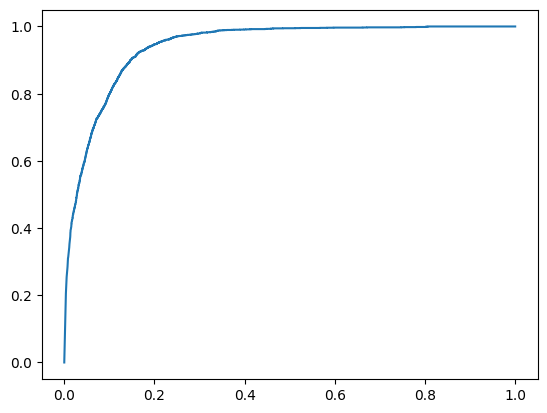

In [22]:
plt.plot(fpr,tpr)

In [100]:
tpr[1300], fpr[1300]

(0.8869047619047619, 0.11051546391752577)

In [101]:
thresholds[1300]

0.95124316

In [135]:
import matplotlib.pyplot as plt

Тестовый Loss: 0.0951
Точность на тестовом наборе: 99.60%


/Users/egorperelygin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


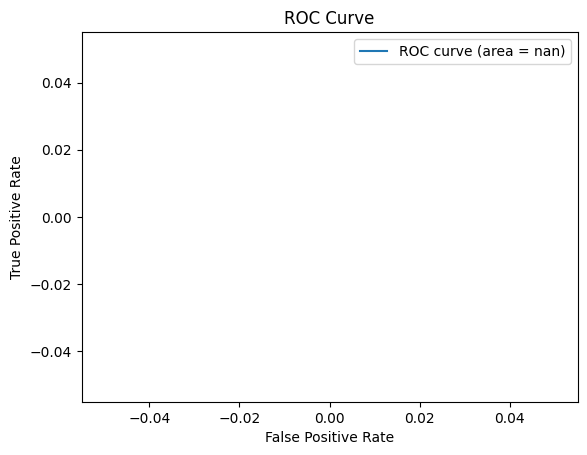

In [18]:
model = torch.load('best_new_data.pt')
criterion = nn.BCELoss(weight=torch.tensor([3.0]).to(mps_device))
avg_loss, accuracy, fpr, tpr, thresholds, y, scores = test_model(
    model,
    criterion,
    dataloader_test, 
    mps_device)

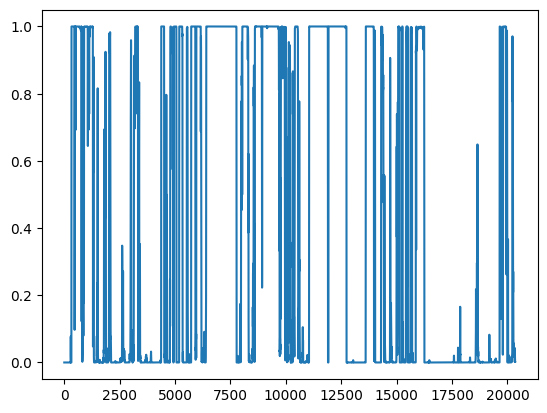

In [132]:
plt.plot(score)
plt.show()

In [20]:
scores.mean()

0.027375244

In [133]:
def detect_anomalies(probabilities, threshold, margin=0.05, window_size=32):
    anomalies = []
    start = None
    
    for i, prob in enumerate(probabilities):
        if prob > threshold:  # Аномалия началась или продолжается
            if start is None:
                start = i  # Начало аномалии
        else:
            # Если вероятность упала ниже порога с запасом (margin)
            if start is not None and prob < threshold - margin:
                if i - start > 10:
                    anomalies.append((start, i - 1 + window_size))  # Закрываем аномалию
                    start = None

    # Если аномалия продолжалась до конца данных
    if start is not None:
        anomalies.append((start, len(probabilities) - 1))
    
    return anomalies

In [134]:
def merge_overlapping_segments(segments):
    if not segments:
        return []
    
    # Сортируем сегменты по началу
    segments.sort(key=lambda x: x[0])
    merged = [segments[0]]
    
    for current in segments[1:]:
        previous = merged[-1]
        # Если текущий сегмент пересекается или соприкасается с предыдущим
        if current[0] <= previous[1]:
            # Объединяем сегменты
            merged[-1] = (previous[0], max(previous[1], current[1]))
        else:
            # Добавляем как новый сегмент
            merged.append(current)
    
    return merged

In [135]:
anomaly_segments = detect_anomalies(score, 0.85, margin=0.09)

In [136]:
anomaly_segments = merge_overlapping_segments(anomaly_segments)

In [137]:
anomaly_segments

[(322, 840),
 (891, 1361),
 (1860, 1902),
 (2022, 2110),
 (3006, 3050),
 (3162, 3358),
 (4374, 4538),
 (4781, 5091),
 (5188, 5367),
 (5529, 5597),
 (5727, 5946),
 (5957, 6208),
 (6405, 7803),
 (8011, 8336),
 (8560, 9728),
 (9773, 9986),
 (9992, 10059),
 (10134, 10239),
 (10321, 10386),
 (10400, 10581),
 (11050, 12767),
 (13606, 14004),
 (14009, 14057),
 (14299, 14430),
 (14707, 14749),
 (15066, 15170),
 (15249, 15295),
 (15424, 15536),
 (15628, 15724),
 (15868, 16276),
 (19648, 19729),
 (19744, 20018),
 (20226, 20281)]

In [38]:
data.shape

NameError: name 'data' is not defined

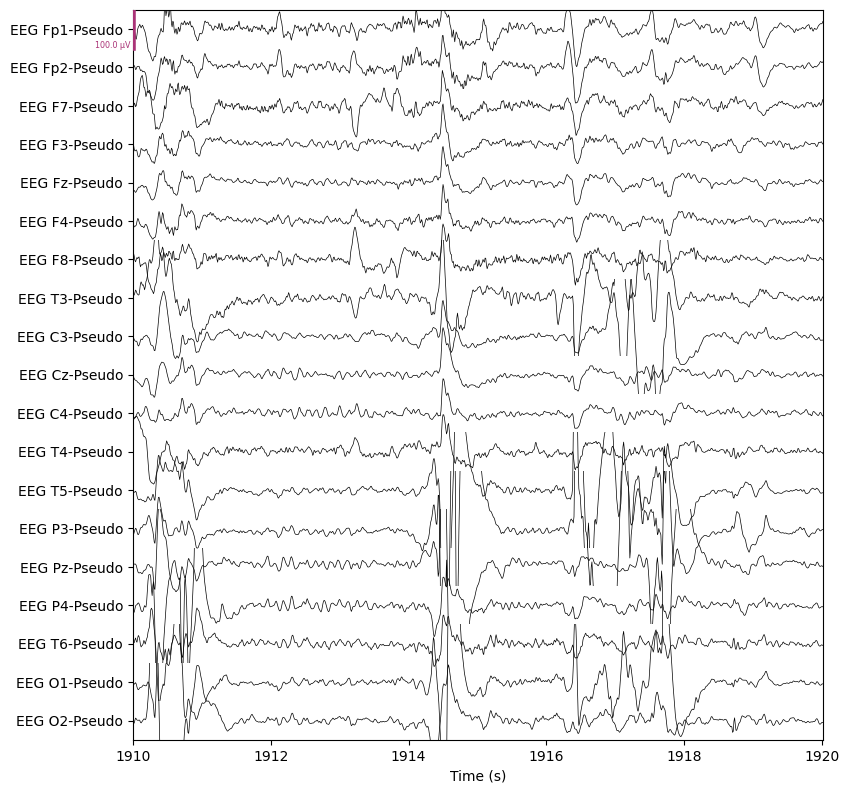

In [160]:
p = test_raw.plot(duration=10, start=1910,show_scrollbars=False, scalings=scalings)

In [138]:
decription = []
times = []
for start, end in anomaly_segments:
    times.append(191000+start)
    times.append(191000+end)
    decription.append("start")
    decription.append("end")

In [139]:
times

[191322,
 191840,
 191891,
 192361,
 192860,
 192902,
 193022,
 193110,
 194006,
 194050,
 194162,
 194358,
 195374,
 195538,
 195781,
 196091,
 196188,
 196367,
 196529,
 196597,
 196727,
 196946,
 196957,
 197208,
 197405,
 198803,
 199011,
 199336,
 199560,
 200728,
 200773,
 200986,
 200992,
 201059,
 201134,
 201239,
 201321,
 201386,
 201400,
 201581,
 202050,
 203767,
 204606,
 205004,
 205009,
 205057,
 205299,
 205430,
 205707,
 205749,
 206066,
 206170,
 206249,
 206295,
 206424,
 206536,
 206628,
 206724,
 206868,
 207276,
 210648,
 210729,
 210744,
 211018,
 211226,
 211281]

In [142]:
test_raw = mne.io.read_raw_edf('/Users/egorperelygin/Downloads/ЭПИ050125.edf',preload=True)

Extracting EDF parameters from /Users/egorperelygin/Downloads/ЭПИ050125.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3671859  =      0.000 ... 36718.590 secs...


Overwriting existing file.


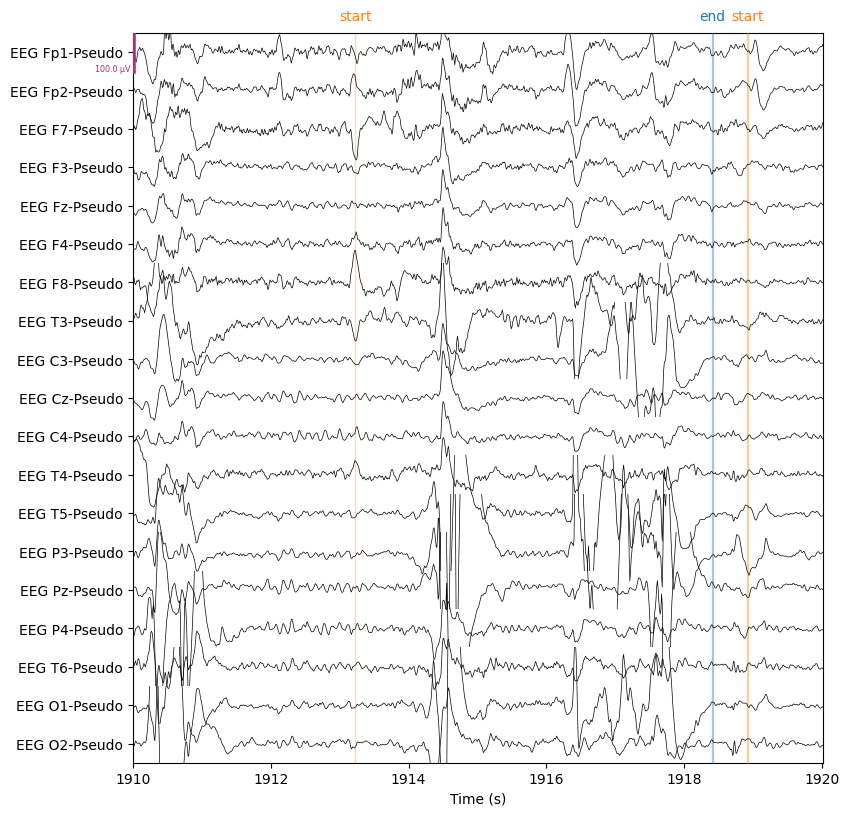

In [143]:
# Добавляем аннотации
annotations = mne.Annotations(
    onset=[t / 100 for t in times],  # Время в секундах
    duration=[0 for t in times],
    description=decription  # Описание аномалий
)
test_raw.set_annotations(annotations)
mne.export.export_raw('/Users/egorperelygin/test-epi_ann.set', test_raw, overwrite=True)
scalings = dict(eeg=500e-7)
p = test_raw.plot(duration=10, start=1910,show_scrollbars=False, scalings=scalings)

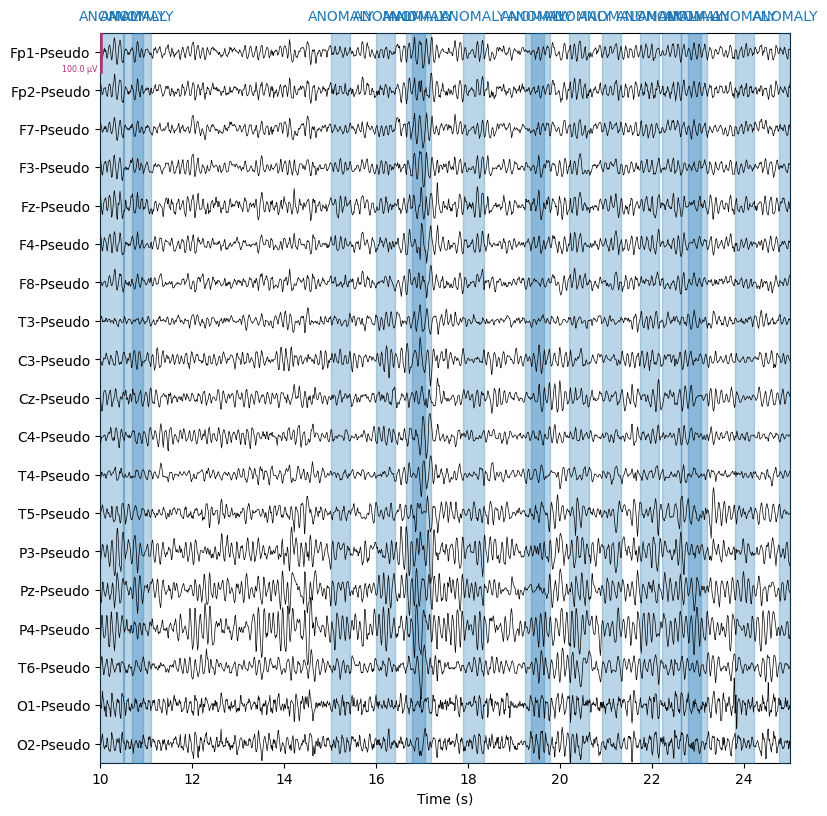

In [28]:
scalings = dict(eeg=500e-7)
p = test_raw.plot(duration=15, start=10,show_scrollbars=False, scalings=scalings)

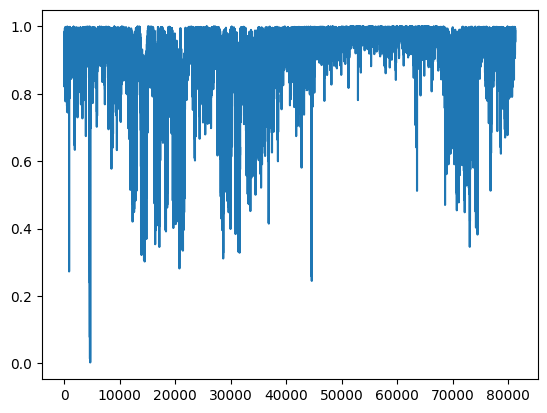

In [104]:
plt.plot(scores)
plt.show()

In [107]:
len(preds)

81248

In [108]:
preds = (scores > 0.95).astype(int)

In [145]:
def merge_anomaly_windows(predictions, window_size, threshold=16):
    cur_wind_count = 0
    anomaly_segments = []
    current_segment = None

    for i, is_anomalous in enumerate(predictions):
        if is_anomalous == 1:
            if current_segment is None:
                # Начинаем новый сегмент
                current_segment = [i, i + window_size]
            else:
                # Продолжаем текущий сегмент
                current_segment[1] = i + window_size
        else:
            # Заканчиваем текущий сегмент, если оно существует и достаточно велико
            if current_segment is not None:
                if current_segment[1] - current_segment[0] > threshold:
                    anomaly_segments.append(tuple(current_segment))
                current_segment = None

    # Добавляем последний сегмент, если он есть и достаточного размера
    if current_segment is not None and current_segment[1] - current_segment[0] > threshold:
        anomaly_segments.append(tuple(current_segment))

    return anomaly_segments

# Применение функции
anomaly_segments = merge_anomaly_windows(preds, window_size=32)
print("Сегменты аномалий:", anomaly_segments)

Сегменты аномалий: [(31, 63), (64, 96), (95, 128), (100, 134), (106, 140), (111, 146), (117, 151), (122, 155), (126, 160), (131, 165), (136, 170), (141, 175), (145, 180), (150, 185), (155, 190), (160, 195), (166, 200), (171, 206), (177, 211), (183, 217), (190, 222), (239, 271), (243, 276), (248, 282), (252, 287), (258, 293), (263, 299), (269, 305), (275, 310), (281, 316), (287, 322), (293, 328), (298, 333), (304, 339), (310, 345), (316, 350), (321, 356), (327, 362), (332, 367), (338, 373), (344, 378), (349, 384), (354, 389), (360, 395), (365, 400), (371, 406), (376, 411), (382, 417), (389, 422), (394, 429), (400, 434), (406, 441), (412, 447), (418, 454), (424, 482), (452, 488), (506, 540), (510, 549), (519, 571), (541, 576), (546, 582), (552, 587), (557, 598), (568, 603), (573, 609), (579, 638), (608, 657), (627, 663), (633, 668), (638, 678), (648, 698), (668, 704), (674, 709), (679, 723), (695, 728), (700, 733), (705, 738), (710, 743), (716, 748), (721, 754), (727, 759), (749, 781), (

In [113]:
def merge_anomaly_windows(predictions, window_size, threshold=16):
    cur_overlap_count = 0
    anomaly_segments = []
    current_segment = None

    for i, is_anomalous in enumerate(predictions):
        if is_anomalous == 1:
            if current_segment is None:
                # Начинаем новый сегмент
                current_segment = [i, i + window_size]
                cur_overlap_count = 1  # Начинаем с первого пересекающегося окна
            else:
                # Расширяем текущий сегмент и увеличиваем количество пересечений
                current_segment[1] = i + window_size
                cur_overlap_count += 1
        else:
            # Заканчиваем текущий сегмент, если он существует и достаточно много пересечений
            if current_segment is not None:
                if cur_overlap_count > threshold:
                    anomaly_segments.append(tuple(current_segment))
                # Сбрасываем счетчики для следующего сегмента
                current_segment = None
                cur_overlap_count = 0

    # Добавляем последний сегмент, если он существует и достаточно пересечений
    if current_segment is not None and cur_overlap_count > threshold:
        anomaly_segments.append(tuple(current_segment))

    return anomaly_segments

# Пример применения функции
anomaly_segments = merge_anomaly_windows(preds, window_size=32, threshold=16)

In [111]:
def merge_anomaly_windows(predictions, window_size, threshold=16):
    cur_overlap_count = 0
    anomaly_segments = []
    current_segment = None

    for i, is_anomalous in enumerate(predictions):
        if is_anomalous == 1:
            cur_overlap_count += 1  # увеличиваем количество пересечений

            if cur_overlap_count >= threshold:
                if current_segment is None:
                    # Начинаем новый сегмент, если достаточно пересечений
                    current_segment = [i, i + window_size]
                else:
                    # Расширяем текущий сегмент
                    current_segment[1] = i + window_size
        else:
            
            # Если текущий сегмент существует, но пересечений меньше порога - заканчиваем сегмент
            if current_segment is not None:
                if cur_overlap_count < threshold:
                    anomaly_segments.append(tuple(current_segment))
                    # Сбрасываем текущий сегмент и счетчик пересечений
                    current_segment = None
                    cur_overlap_count = 0
                else:
                    cur_overlap_count-=1

    # Добавляем последний сегмент, если он существует и достаточно пересечений
    if current_segment is not None and cur_overlap_count >= threshold:
        anomaly_segments.append(tuple(current_segment))

    return anomaly_segments

# Пример применения функции
anomaly_segments = merge_anomaly_windows(preds, window_size=32, threshold=16)

In [109]:
def merge_anomaly_windows(predictions, window_size, threshold=16):
    cur_overlap_count = 0
    anomaly_segments = []
    current_segment = None
    newpos = 0
    for i, is_anomalous in enumerate(predictions):
        if i < newpos:
            continue
        if is_anomalous == 1:
            cur_overlap_count += 1  # Увеличиваем количество пересечений

            # Проверяем, если текущий сегмент достиг порога и не пересекается с последним
            if cur_overlap_count >= threshold:
                if current_segment is None:
                    # Начинаем новый сегмент, если достаточно пересечений
                    current_segment = [i, i + window_size]
                else:
                    current_segment[1] = i + window_size
        else:
            # Если текущий сегмент существует и пересечений меньше порога, заканчиваем сегмент
            if current_segment is not None and cur_overlap_count < threshold:
                anomaly_segments.append(tuple(current_segment))
                # Сбрасываем текущий сегмент и счетчик пересечений
                newpos = i+threshold
                current_segment = None
                cur_overlap_count = 0

    # Добавляем последний сегмент, если он существует и достаточно пересечений
    if current_segment is not None and cur_overlap_count >= threshold:
        anomaly_segments.append(tuple(current_segment))

    return anomaly_segments
anomaly_segments = merge_anomaly_windows(preds, window_size=32, threshold=16)

In [114]:
anomaly_segments

[(145, 201),
 (418, 494),
 (504, 698),
 (753, 806),
 (937, 1022),
 (1003, 1055),
 (1380, 1481),
 (1627, 1684),
 (1654, 1765),
 (1745, 1795),
 (1790, 1844),
 (1819, 1874),
 (1942, 2075),
 (2126, 2231),
 (2228, 2276),
 (2246, 2303),
 (2298, 2346),
 (2691, 2767),
 (2828, 2882),
 (2853, 2902),
 (2928, 2979),
 (3335, 3386),
 (3484, 3554),
 (3530, 3605),
 (3612, 3673),
 (3695, 3780),
 (3800, 3850),
 (3941, 4016),
 (4015, 4107),
 (4146, 4195),
 (4196, 4257),
 (4233, 4343),
 (4313, 4362),
 (4411, 4464),
 (4450, 4521),
 (4557, 4632),
 (4768, 4819),
 (4847, 4898),
 (4868, 4921),
 (4933, 5004),
 (4980, 5039),
 (5058, 5106),
 (5142, 5197),
 (5184, 5236),
 (5206, 5272),
 (5490, 5550),
 (5737, 5790),
 (6074, 6136),
 (6106, 6168),
 (6138, 6186),
 (6162, 6233),
 (6203, 6273),
 (6292, 6349),
 (6319, 6413),
 (6510, 6567),
 (6557, 6620),
 (6674, 6777),
 (6747, 6849),
 (6942, 7014),
 (6999, 7050),
 (7136, 7195),
 (7214, 7262),
 (7438, 7590),
 (7560, 7647),
 (7692, 7818),
 (7804, 7856),
 (7826, 7907),
 (79

In [57]:
anomaly_segments

[(146, 186),
 (527, 722),
 (2005, 2040),
 (3328, 3376),
 (3956, 3994),
 (4105, 4137),
 (4150, 4276),
 (4577, 4668),
 (6099, 6145),
 (6784, 6816),
 (7220, 7273),
 (7564, 7597),
 (7815, 7850),
 (7927, 7960),
 (9007, 9102),
 (10523, 10568),
 (10578, 10618),
 (10715, 10809),
 (12912, 12944),
 (13176, 13245),
 (13558, 13592),
 (15092, 15283),
 (15279, 15313),
 (15381, 15431),
 (15450, 15523),
 (15690, 15723),
 (16882, 16914),
 (17403, 17445),
 (18724, 18756),
 (21820, 21884),
 (21971, 22008),
 (22337, 22369),
 (22654, 22712),
 (22916, 22973),
 (23925, 23999),
 (24482, 24552),
 (24647, 24681),
 (24678, 24749),
 (24832, 24876),
 (25166, 25206),
 (25524, 25557),
 (25582, 25663),
 (26580, 26612),
 (26598, 26638),
 (26680, 26712),
 (26930, 27000),
 (27076, 27108),
 (27102, 27139),
 (27180, 27265),
 (27801, 27842),
 (30168, 30238),
 (31906, 31973),
 (32251, 32295),
 (32330, 32363),
 (32669, 32704),
 (35139, 35199),
 (36276, 36314),
 (36989, 37030),
 (37081, 37125),
 (37526, 37558),
 (37544, 37585

In [136]:
def merge_segments(segments):
    # Сортируем сегменты по их началу
    segments = sorted(segments, key=lambda x: x[0])
    merged = []

    for start, end in segments:
        if not merged or merged[-1][1] < start:  # Нет пересечения
            merged.append((start, end))
        else:  # Есть пересечение, объединяем
            merged[-1] = (merged[-1][0], max(merged[-1][1], end))

    return merged

In [116]:
merged_segments = merge_segments(anomaly_segments)
print("Обработанные сегменты:", merged_segments)

Обработанные сегменты: [(145, 201), (418, 494), (504, 698), (753, 806), (937, 1055), (1380, 1481), (1627, 1874), (1942, 2075), (2126, 2346), (2691, 2767), (2828, 2902), (2928, 2979), (3335, 3386), (3484, 3605), (3612, 3673), (3695, 3780), (3800, 3850), (3941, 4107), (4146, 4195), (4196, 4362), (4411, 4521), (4557, 4632), (4768, 4819), (4847, 4921), (4933, 5039), (5058, 5106), (5142, 5272), (5490, 5550), (5737, 5790), (6074, 6273), (6292, 6413), (6510, 6620), (6674, 6849), (6942, 7050), (7136, 7195), (7214, 7262), (7438, 7647), (7692, 7907), (7913, 7966), (8978, 9113), (9134, 9187), (9209, 9272), (9293, 9355), (9557, 9605), (10081, 10147), (10313, 10805), (10976, 11101), (11323, 11385), (13103, 13395), (13536, 13632), (15068, 15387), (15392, 15508), (15536, 15600), (15614, 15899), (15984, 16102), (16860, 16958), (17382, 17457), (17517, 17580), (17648, 17717), (17907, 17961), (18709, 18891), (18903, 18956), (18976, 19040), (19349, 19401), (20922, 20974), (21810, 21919), (22069, 22126), (

In [148]:
anomaly_segments

[(2, 87),
 (325, 496),
 (554, 843),
 (1231, 1325),
 (1453, 1518),
 (1844, 1941),
 (3354, 3632),
 (3816, 3952),
 (4379, 5930),
 (5968, 6353),
 (6486, 7842),
 (8018, 8321),
 (8701, 9678),
 (10399, 10577),
 (11062, 11931),
 (11946, 12718),
 (13163, 13275),
 (13645, 14015),
 (15269, 15495),
 (15709, 16325),
 (19821, 19917)]

(19, 20500)
2 87
325 496
554 843
1231 1325
1453 1518
1844 1941
3354 3632
3816 3952
4379 5930
5968 6353
6486 7842
8018 8321
8701 9678
10399 10577
11062 11931
11946 12718
13163 13275
13645 14015
15269 15495
15709 16325
19821 19917


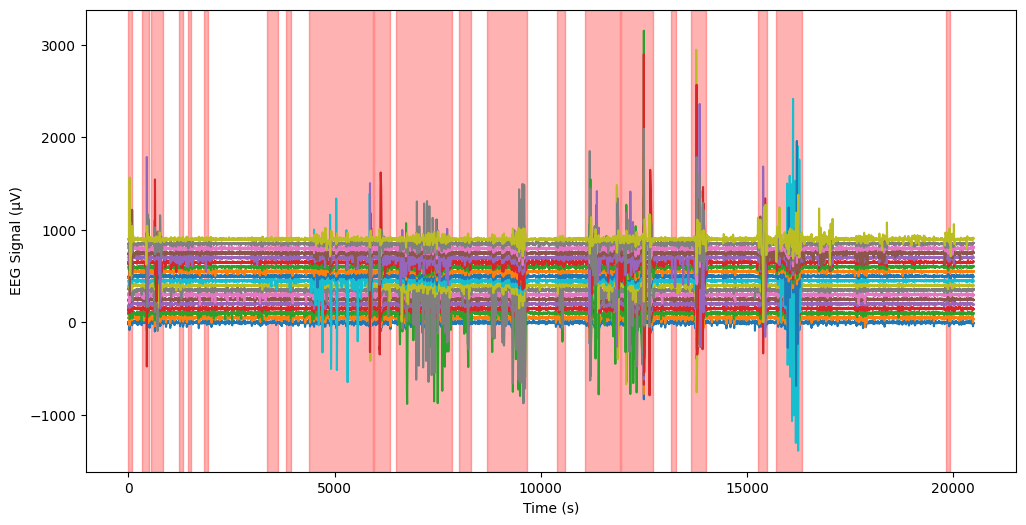

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Извлечение данных и временных меток событий
# data, times = eeglab_raw[:19, :]  # Используем 19 каналов

# Определяем интервал отображения (например, от 400 до 405 секунд)
# eeg_data[:,191000:211500]
start, stop = 1910, 2115
start_sample, stop_sample = int(start * 100), int(stop * 100)
data_segment = eeg_data[:, start_sample:stop_sample]
times=np.arange(191000,211500,1)
# time_segment = times[start_sample:stop_sample]
print(data_segment.shape)
# Извлекаем события и их ID
# events, event_id = mne.events_from_annotations(eeglab_raw)

# Создаем график с Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
scaling_factor = 1e6  # Масштабируем сигнал, если нужно
for i, channel_data in enumerate(data_segment):
    ax.plot(channel_data * scaling_factor + i * 50, label=f'Channel {i+1}')  # смещение для каждого канала

# Добавляем аномальные сегменты
# anomaly_segments = [(401, 402), (403, 404)]  # Подставьте сюда свои сегменты
for (start1, end) in anomaly_segments:
    print(start1, end)
    ax.axvspan(start1, end, color='red', alpha=0.3, label="Anomaly" if start == anomaly_segments[0][0] else "")

# Добавляем первоначальные метки событий
# for event in events:
#     event_time = event[0] / eeglab_raw.info['sfreq']
#     if start <= event_time <= stop:  # Отображаем только те, что в пределах выбранного интервала
#         ax.axvline(event_time, color='blue', linestyle='--', alpha=0.7)

# Настройки графика
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG Signal (μV)')
# ax.legend(loc='upper right')
plt.show()

In [49]:
data.shape

(19, 81280)

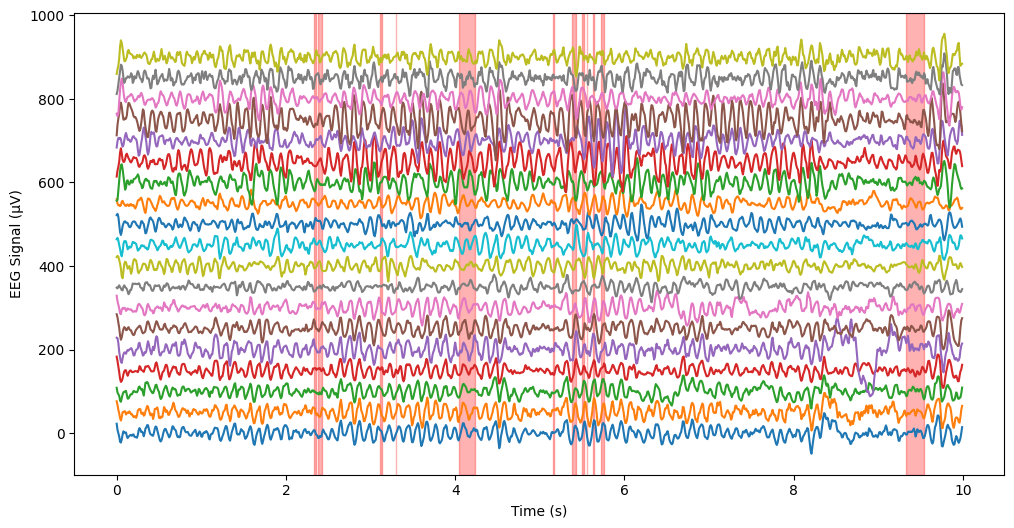

In [147]:
import matplotlib.pyplot as plt
import numpy as np

# Извлечение данных и временных меток событий
data, times = test_raw[:19, :]  # Используем 19 каналов

# Определяем интервал отображения (например, от 400 до 405 секунд)
start, stop = 0, 10
start_sample, stop_sample = int(start * test_raw.info['sfreq']), int(stop * test_raw.info['sfreq'])
data_segment = data[:, start_sample:stop_sample]
time_segment = times[start_sample:stop_sample]

# # Извлекаем события и их ID
# events, event_id = mne.events_from_annotations(eeglab_raw)

# Создаем график с Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
scaling_factor = 1e6  # Масштабируем сигнал, если нужно
for i, channel_data in enumerate(data_segment):
    ax.plot(time_segment, channel_data * scaling_factor + i * 50, label=f'Channel {i+1}')  # смещение для каждого канала

# Добавляем аномальные сегменты
# anomaly_segments = [(401, 402), (403, 404)]  # Подставьте сюда свои сегменты
for (start1, end) in anomaly_segments:
    if start1/100 > start and end/100 < stop:
        ax.axvspan((start1)/100, (end)/100, color='red', alpha=0.3, label="Anomaly" if start == anomaly_segments[0][0] else "")

# Добавляем первоначальные метки событий
# for event in events:
#     event_time = event[0] / eeglab_raw.info['sfreq']
#     if start <= event_time <= stop:  # Отображаем только те, что в пределах выбранного интервала
#         ax.axvline(event_time, color='blue', linestyle='--', alpha=0.7)

# Настройки графика
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG Signal (μV)')
# ax.legend(loc='upper right')
plt.show()

In [63]:

found = 0
for event in events[100:]:
    event_time = event[0]
    for (start1, end) in anomaly_segments:
        if start1 <= event_time-34177<= end:
            found+=1
print(found, len(events[100:]))

91 97


In [60]:
found = 0
for (start1, end) in anomaly_segments:
    
    for event in events[100:]:
        event_time = event[0]
        if start1 <= event_time-34177<= end:
            found+=1
print(found, len(anomaly_segments))

91 96


In [48]:
anomaly_segments

[(0, 37),
 (39, 115),
 (122, 195),
 (526, 588),
 (813, 888),
 (870, 941),
 (938, 1006),
 (1427, 1461),
 (1453, 1513),
 (1484, 1521),
 (1492, 1524),
 (1925, 1969),
 (1977, 2036),
 (2014, 2081),
 (2069, 2127),
 (2104, 2146),
 (2136, 2209),
 (2213, 2246),
 (2216, 2250),
 (2225, 2290),
 (2304, 2375),
 (2377, 2441),
 (2699, 2769),
 (2747, 2815),
 (2807, 2839),
 (2809, 2859),
 (2829, 2866),
 (2839, 2881),
 (2877, 2948),
 (2947, 3020),
 (2990, 3022),
 (3034, 3102),
 (3096, 3178),
 (3188, 3223),
 (3193, 3226),
 (3197, 3257),
 (3274, 3329),
 (3501, 3564),
 (3541, 3610),
 (3601, 3636),
 (3606, 3657),
 (3633, 3675),
 (3676, 3745),
 (3748, 3819),
 (3834, 3904),
 (3909, 3979),
 (3979, 4049),
 (4055, 4132),
 (4289, 4323),
 (4293, 4372),
 (4350, 4417),
 (4420, 4488),
 (4490, 4552),
 (4566, 4637),
 (4633, 4714),
 (4721, 4793),
 (4792, 4824),
 (4796, 4870),
 (4872, 4904),
 (4876, 4951),
 (4987, 5030),
 (5201, 5243),
 (5266, 5332),
 (5314, 5390),
 (5713, 5777),
 (5760, 5827),
 (5813, 5865),
 (5852, 5889

In [94]:
ind = 554
tpr[ind], fpr[ind]

(0.8887648809523809, 0.041995970866263756)

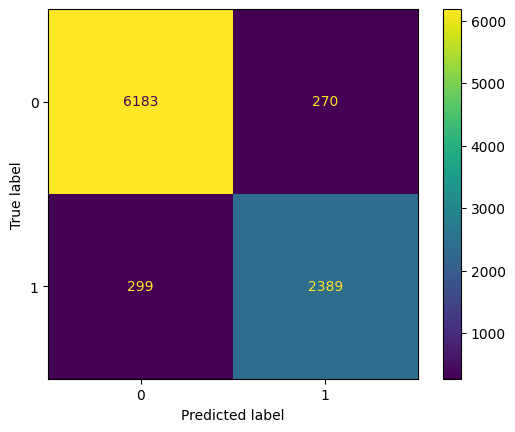

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Пример: ваши истинные метки и предсказания
# all_labels = [0, 1, 0, 1, ...]  # Настоящие метки
# predictions = [0, 1, 0, 0, ...]  # Предсказанные метки

# Создаем матрицу ошибок
cm = confusion_matrix(all_labels, np.array(predictions)>thresholds[ind])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [98]:
from sklearn import metrics
# Датасет и загрузчик данных
class EEGDataset2D(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Добавляем ось для канала (1, Nchannels, window_W)
        return torch.tensor(self.sequences[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.labels[idx], dtype=torch.float32)

# Пример создания модели
window_size = X_train_16.shape[1]  # Размер окна (window_W)
num_channels = X_train_16.shape[2]  # Количество каналов (Nchannels)

model = EEGConvNet2D(in_channels=1,num_channels=num_channels, window_size=window_size)
# Функция потерь и оптимизатор
criterion = nn.BCELoss(weight=torch.tensor([3.0]).to(mps_device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataset = EEGDataset2D(X_train_16, y_train_16)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset_test = EEGDataset2D(X_test_16, y_test_16)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [99]:
# Инициализация переменных для сохранения лучшей модели
best_roc_auc = 0.0
best_model_wts = None

# Обучение модели с валидацией на каждом шаге
num_epochs = 200
model.train()
model.to(mps_device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    c = 1
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs = inputs.to(mps_device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.to(mps_device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        c += 1
    print(f'Epoch [{epoch+1}/{num_epochs}], step {c}, Loss: {running_loss/c:.4f}')
    
    # Валидация после каждой эпохи
    model.eval()
    total_loss = 0.0
    predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader_test:
            inputs = inputs.to(mps_device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.to(mps_device))
            total_loss += loss.item()

            # Предсказания и метки
            predictions.extend(outputs.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Расчет ROCAUC
    y = np.array(all_labels).astype(int)
    scores = np.array(predictions)
    roc_auc = metrics.roc_auc_score(y, scores)
    print(f'Validation ROCAUC: {roc_auc:.4f}')

    # Сохранение лучшей модели
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_wts = model.state_dict().copy()
        print(f'Best model updated with ROCAUC: {best_roc_auc:.4f}')

# Загрузка лучших весов модели
model.load_state_dict(best_model_wts)
print(f'Best Validation ROCAUC achieved: {best_roc_auc:.4f}')

Epoch [1/200], step 182, Loss: 0.7509
Validation ROCAUC: 0.9619
Best model updated with ROCAUC: 0.9619
Epoch [2/200], step 182, Loss: 0.3504
Validation ROCAUC: 0.9375
Epoch [3/200], step 182, Loss: 0.2746
Validation ROCAUC: 0.9388
Epoch [4/200], step 182, Loss: 0.2379
Validation ROCAUC: 0.9534
Epoch [5/200], step 182, Loss: 0.2033
Validation ROCAUC: 0.9502
Epoch [6/200], step 182, Loss: 0.1807
Validation ROCAUC: 0.2387
Epoch [7/200], step 182, Loss: 0.1824
Validation ROCAUC: 0.3500
Epoch [8/200], step 182, Loss: 0.1549
Validation ROCAUC: 0.5000
Epoch [9/200], step 182, Loss: 0.1781
Validation ROCAUC: 0.9388
Epoch [10/200], step 182, Loss: 0.1355
Validation ROCAUC: 0.5057
Epoch [11/200], step 182, Loss: 0.1357
Validation ROCAUC: 0.8683
Epoch [12/200], step 182, Loss: 0.1053
Validation ROCAUC: 0.7292
Epoch [13/200], step 182, Loss: 0.0917
Validation ROCAUC: 0.9269
Epoch [14/200], step 182, Loss: 0.0872
Validation ROCAUC: 0.9204
Epoch [15/200], step 182, Loss: 0.1052
Validation ROCAUC: 0.

Validation ROCAUC: 0.9356
Epoch [124/200], step 182, Loss: 0.0077
Validation ROCAUC: 0.8958
Epoch [125/200], step 182, Loss: 0.0016
Validation ROCAUC: 0.9590
Epoch [126/200], step 182, Loss: 0.0023
Validation ROCAUC: 0.9462
Epoch [127/200], step 182, Loss: 0.0004
Validation ROCAUC: 0.9772
Best model updated with ROCAUC: 0.9772
Epoch [128/200], step 182, Loss: 0.0016
Validation ROCAUC: 0.8975
Epoch [129/200], step 182, Loss: 0.0180
Validation ROCAUC: 0.5000
Epoch [130/200], step 182, Loss: 0.0170
Validation ROCAUC: 0.8054
Epoch [131/200], step 182, Loss: 0.0209
Validation ROCAUC: 0.9342
Epoch [132/200], step 182, Loss: 0.0059
Validation ROCAUC: 0.9127
Epoch [133/200], step 182, Loss: 0.0026
Validation ROCAUC: 0.8934
Epoch [134/200], step 182, Loss: 0.0037
Validation ROCAUC: 0.5009
Epoch [135/200], step 182, Loss: 0.0060
Validation ROCAUC: 0.5980
Epoch [136/200], step 182, Loss: 0.0014
Validation ROCAUC: 0.8413
Epoch [137/200], step 182, Loss: 0.0008
Validation ROCAUC: 0.9748
Epoch [138/

Тестовый Loss: 1.4875
Точность на тестовом наборе: 94.84%


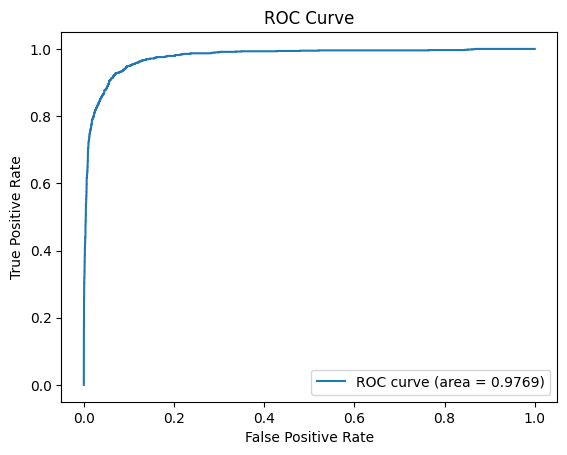

In [103]:
avg_loss, accuracy, fpr, tpr = test_model(
    model=model,
    criterion=criterion,
    dataloader=dataloader_test, 
    device=mps_device)
    

In [106]:
ind = 444
tpr[ind], fpr[ind]

(0.8871527777777778, 0.05202188136865816)

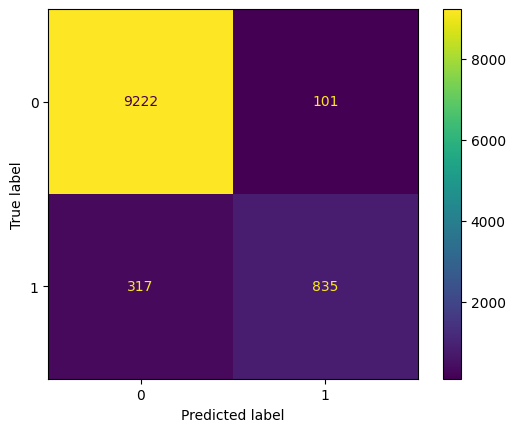

In [107]:
cm = confusion_matrix(all_labels, np.array(predictions)>thresholds[ind])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [108]:
window_size = X_train_24.shape[1]  # Размер окна (window_W)
num_channels = X_train_24.shape[2]  # Количество каналов (Nchannels)

model = EEGConvNet2D(in_channels=1,num_channels=num_channels, window_size=window_size)
# Функция потерь и оптимизатор
criterion = nn.BCELoss(weight=torch.tensor([3.0]).to(mps_device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataset = EEGDataset2D(X_train_24, y_train_24)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset_test = EEGDataset2D(X_test_24, y_test_24)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [109]:
trained_model, best_roc_auc = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloader_train=dataloader,
    dataloader_val=dataloader_test,
    num_epochs=200,
    device=mps_device
)

Epoch [1/200], Training Loss: 0.7128
Validation ROCAUC: 0.5124
Best model updated with ROCAUC: 0.5124
Epoch [2/200], Training Loss: 0.3160
Validation ROCAUC: 0.9773
Best model updated with ROCAUC: 0.9773
Epoch [3/200], Training Loss: 0.2532
Validation ROCAUC: 0.9828
Best model updated with ROCAUC: 0.9828
Epoch [4/200], Training Loss: 0.2186
Validation ROCAUC: 0.9571
Epoch [5/200], Training Loss: 0.1980
Validation ROCAUC: 0.9523
Epoch [6/200], Training Loss: 0.1696
Validation ROCAUC: 0.9640
Epoch [7/200], Training Loss: 0.1464
Validation ROCAUC: 0.9450
Epoch [8/200], Training Loss: 0.1405
Validation ROCAUC: 0.5006
Epoch [9/200], Training Loss: 0.1266
Validation ROCAUC: 0.9189
Epoch [10/200], Training Loss: 0.1176
Validation ROCAUC: 0.8243
Epoch [11/200], Training Loss: 0.1119
Validation ROCAUC: 0.5000
Epoch [12/200], Training Loss: 0.0867
Validation ROCAUC: 0.5044
Epoch [13/200], Training Loss: 0.0755
Validation ROCAUC: 0.9758
Epoch [14/200], Training Loss: 0.0778
Validation ROCAUC: 0.5

Validation ROCAUC: 0.9783
Epoch [127/200], Training Loss: 0.0042
Validation ROCAUC: 0.5000
Epoch [128/200], Training Loss: 0.0026
Validation ROCAUC: 0.9673
Epoch [129/200], Training Loss: 0.0028
Validation ROCAUC: 0.9720
Epoch [130/200], Training Loss: 0.0016
Validation ROCAUC: 0.5012
Epoch [131/200], Training Loss: 0.0048
Validation ROCAUC: 0.7089
Epoch [132/200], Training Loss: 0.0390
Validation ROCAUC: 0.9642
Epoch [133/200], Training Loss: 0.0041
Validation ROCAUC: 0.9350
Epoch [134/200], Training Loss: 0.0049
Validation ROCAUC: 0.5000
Epoch [135/200], Training Loss: 0.0093
Validation ROCAUC: 0.5000
Epoch [136/200], Training Loss: 0.0133
Validation ROCAUC: 0.6094
Epoch [137/200], Training Loss: 0.0007
Validation ROCAUC: 0.5831
Epoch [138/200], Training Loss: 0.0004
Validation ROCAUC: 0.9740
Epoch [139/200], Training Loss: 0.0149
Validation ROCAUC: 0.8810
Epoch [140/200], Training Loss: 0.0010
Validation ROCAUC: 0.9118
Epoch [141/200], Training Loss: 0.0006
Validation ROCAUC: 0.9570

Тестовый Loss: 20.2655
Точность на тестовом наборе: 39.09%


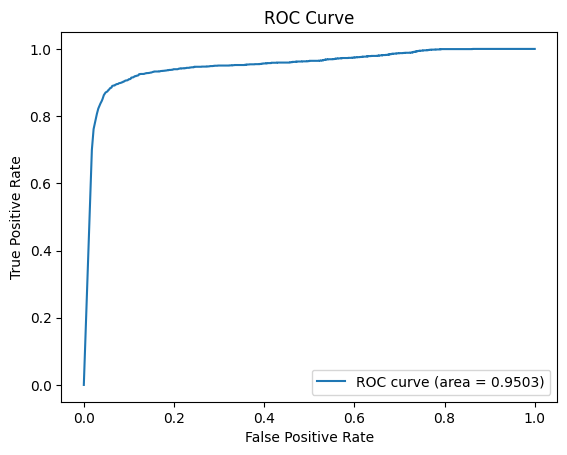

In [111]:
avg_loss, accuracy, fpr, tpr = test_model(
    trained_model,
    criterion,
    dataloader_test, 
    mps_device)

In [120]:
ind = 424
tpr[ind], fpr[ind]

(0.9515625, 0.3308955606877085)

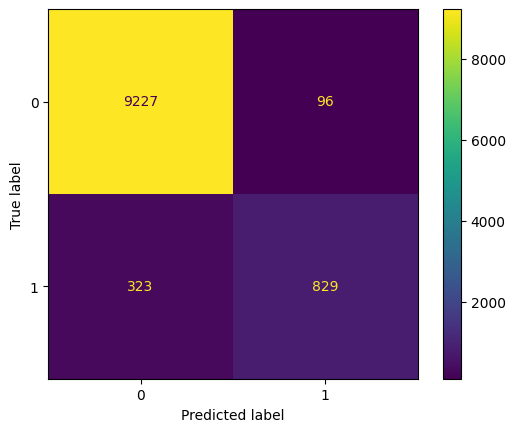

In [121]:
cm = confusion_matrix(all_labels, np.array(predictions)>thresholds[ind])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [123]:
window_size = X_train_48.shape[1]  # Размер окна (window_W)
num_channels = X_train_48.shape[2]  # Количество каналов (Nchannels)

model = EEGConvNet2D(in_channels=1,num_channels=num_channels, window_size=window_size)
# Функция потерь и оптимизатор
criterion = nn.BCELoss(weight=torch.tensor([3.0]).to(mps_device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataset = EEGDataset2D(X_train_48, y_train_48)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset_test = EEGDataset2D(X_test_48, y_test_48)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [124]:
trained_model, best_roc_auc = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    dataloader_train=dataloader,
    dataloader_val=dataloader_test,
    num_epochs=200,
    device=mps_device
)

Epoch [1/200], Training Loss: 0.5757
Validation ROCAUC: 0.9799
Best model updated with ROCAUC: 0.9799
Epoch [2/200], Training Loss: 0.2839
Validation ROCAUC: 0.5000
Epoch [3/200], Training Loss: 0.2523
Validation ROCAUC: 0.9554
Epoch [4/200], Training Loss: 0.2110
Validation ROCAUC: 0.5000
Epoch [5/200], Training Loss: 0.1943
Validation ROCAUC: 0.5000
Epoch [6/200], Training Loss: 0.1619
Validation ROCAUC: 0.9435
Epoch [7/200], Training Loss: 0.1413
Validation ROCAUC: 0.9095
Epoch [8/200], Training Loss: 0.1288
Validation ROCAUC: 0.9603
Epoch [9/200], Training Loss: 0.1008
Validation ROCAUC: 0.7798
Epoch [10/200], Training Loss: 0.0846
Validation ROCAUC: 0.8803
Epoch [11/200], Training Loss: 0.0812
Validation ROCAUC: 0.5000
Epoch [12/200], Training Loss: 0.0707
Validation ROCAUC: 0.5000
Epoch [13/200], Training Loss: 0.0661
Validation ROCAUC: 0.5000
Epoch [14/200], Training Loss: 0.0449
Validation ROCAUC: 0.5000
Epoch [15/200], Training Loss: 0.0354
Validation ROCAUC: 0.5000
Epoch [16/

Validation ROCAUC: 0.6388
Epoch [129/200], Training Loss: 0.0044
Validation ROCAUC: 0.5000
Epoch [130/200], Training Loss: 0.0036
Validation ROCAUC: 0.8925
Epoch [131/200], Training Loss: 0.0017
Validation ROCAUC: 0.5000
Epoch [132/200], Training Loss: 0.0021
Validation ROCAUC: 0.5000
Epoch [133/200], Training Loss: 0.0008
Validation ROCAUC: 0.9664
Epoch [134/200], Training Loss: 0.0019
Validation ROCAUC: 0.5000
Epoch [135/200], Training Loss: 0.0064
Validation ROCAUC: 0.8518
Epoch [136/200], Training Loss: 0.0012
Validation ROCAUC: 0.8410
Epoch [137/200], Training Loss: 0.0003
Validation ROCAUC: 0.9326
Epoch [138/200], Training Loss: 0.0003
Validation ROCAUC: 0.9594
Epoch [139/200], Training Loss: 0.0001
Validation ROCAUC: 0.9510
Epoch [140/200], Training Loss: 0.0244
Validation ROCAUC: 0.5000
Epoch [141/200], Training Loss: 0.0060
Validation ROCAUC: 0.9675
Epoch [142/200], Training Loss: 0.0027
Validation ROCAUC: 0.9443
Epoch [143/200], Training Loss: 0.0005
Validation ROCAUC: 0.9586

Тестовый Loss: 9.0725
Точность на тестовом наборе: 70.77%


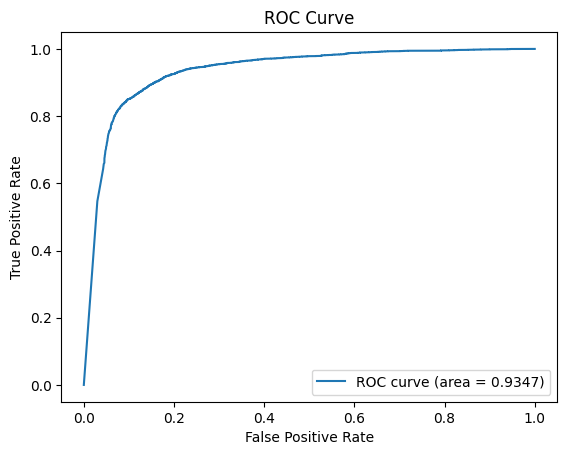

In [125]:
avg_loss, accuracy, fpr, tpr = test_model(
    model=trained_model,
    criterion=criterion,
    dataloader=dataloader_test, 
    device=mps_device)

In [126]:
ind = 444
tpr[ind], fpr[ind]

(0.8645635673624289, 0.1164488854727133)

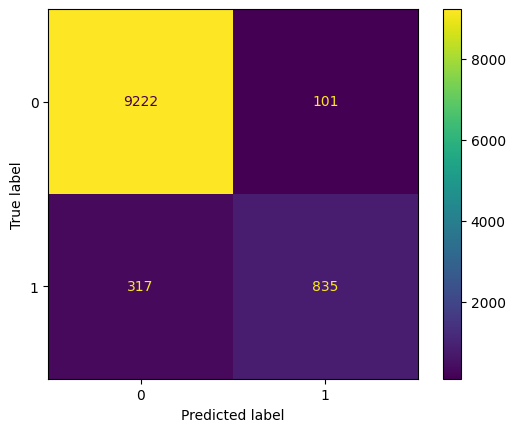

In [127]:
cm = confusion_matrix(all_labels, np.array(predictions)>thresholds[ind])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [ ]:
#. обучение на спектрах

In [165]:
import pywt  # Для вейвлет-преобразования
from scipy.fft import fft

In [166]:
def apply_wavelet_with_padding(data, wavelet='db4', level=4):
    wavelet_data = []
    for window in range(data.shape[0]):  # Для каждого окна
        window_data = []
        for channel in range(data.shape[2]):  # Для каждого канала
            # Применение вейвлет-преобразования к каналу
            coeffs = pywt.wavedec(data[window, :, channel], wavelet, level=level)
            
            # Найдем максимальный размер среди всех коэффициентов
            max_length = max(c.shape[0] for c in coeffs)
            
            # Сделаем padding всех коэффициентов до максимального размера
            coeffs_padded = [np.pad(np.abs(c), (0, max_length - c.shape[0]), mode='constant') for c in coeffs]
            
            # Объединим коэффициенты
            window_data.append(np.stack(coeffs_padded))
        
        # Собираем преобразованные каналы для каждого окна
        wavelet_data.append(np.stack(window_data, axis=-1))  # Каналы по оси -1
    
    return np.array(wavelet_data)

In [167]:
wavelet_test_data = apply_wavelet_with_padding(X_test)
wavelet_data = apply_wavelet_with_padding(X_new)

/Users/egorperelygin/anaconda3/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [168]:
wavelet_test_data.shape

(3497, 5, 19, 19)

In [173]:
# Датасет и загрузчик данных
class EEGDataset2D(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Добавляем ось для канала (1, Nchannels, window_W)
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Пример создания модели
window_size = wavelet_data.shape[2]  # Размер окна (window_W)
num_channels = wavelet_data.shape[3]  # Количество каналов (Nchannels)

model = EEGConvNet2D(in_channels=5,num_channels=num_channels, window_size=window_size)
# Функция потерь и оптимизатор
criterion = nn.BCELoss(weight=torch.tensor([3.0]).to(mps_device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataset = EEGDataset2D(wavelet_data, y_new)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Обучение модели
num_epochs = 200
model.train()
model.to(mps_device)

for epoch in range(num_epochs):
    running_loss = 0.0
    c = 1
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        inputs = inputs.to(mps_device)  # (batch_size, 1, Nchannels, window_W)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.to(mps_device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        c += 1
    print(f'Epoch [{epoch+1}/{num_epochs}], step {c}, Loss: {running_loss/c:.4f}')

Epoch [1/200], step 220, Loss: 0.6285
Epoch [2/200], step 220, Loss: 0.3135
Epoch [3/200], step 220, Loss: 0.2764
Epoch [4/200], step 220, Loss: 0.2486
Epoch [5/200], step 220, Loss: 0.2360
Epoch [6/200], step 220, Loss: 0.2042
Epoch [7/200], step 220, Loss: 0.1838
Epoch [8/200], step 220, Loss: 0.1598
Epoch [9/200], step 220, Loss: 0.1499
Epoch [10/200], step 220, Loss: 0.1211
Epoch [11/200], step 220, Loss: 0.1044
Epoch [12/200], step 220, Loss: 0.0910
Epoch [13/200], step 220, Loss: 0.0803
Epoch [14/200], step 220, Loss: 0.0695
Epoch [15/200], step 220, Loss: 0.0565
Epoch [16/200], step 220, Loss: 0.0481
Epoch [17/200], step 220, Loss: 0.0436
Epoch [18/200], step 220, Loss: 0.0373
Epoch [19/200], step 220, Loss: 0.0269
Epoch [20/200], step 220, Loss: 0.0160
Epoch [21/200], step 220, Loss: 0.0148
Epoch [22/200], step 220, Loss: 0.0351
Epoch [23/200], step 220, Loss: 0.0132
Epoch [24/200], step 220, Loss: 0.0210
Epoch [25/200], step 220, Loss: 0.0196
Epoch [26/200], step 220, Loss: 0.

KeyboardInterrupt: 

In [174]:
dataset_test = EEGDataset2D(wavelet_test_data, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
model.eval()
model.to(mps_device)

total_loss = 0.0
correct = 0
total = 0
predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs = inputs.to(mps_device)  # (batch_size, 1, Nchannels, window_W)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.to(mps_device))
        total_loss += loss.item()

        # Предсказания
        predicted = outputs.squeeze()
        correct += (predicted == labels.to(mps_device)).sum().item()
        total += labels.size(0)
        predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Итоговые результаты
avg_loss = total_loss / len(dataloader)
accuracy = correct / total * 100

print(f"Тестовый Loss: {avg_loss:.4f}")
print(f"Точность на тестовом наборе: {accuracy:.2f}%")

Тестовый Loss: 63.4546
Точность на тестовом наборе: 0.00%


In [176]:
labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [175]:
outputs

tensor([[9.2853e-25],
        [9.4410e-25],
        [7.3539e-25],
        [9.9441e-25],
        [1.4952e-25],
        [1.9291e-25],
        [2.5127e-25],
        [1.4824e-25],
        [1.6308e-25]], device='mps:0')

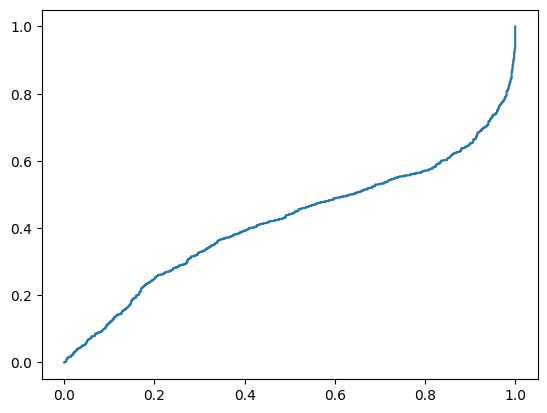

In [177]:
y = np.array(all_labels).astype(int)
scores = np.array(predictions)
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
plt.plot(fpr,tpr)
plt.show()

In [130]:
ind = 150
tpr[ind], fpr[ind]

(0.8814382896015549, 0.04695837780149413)

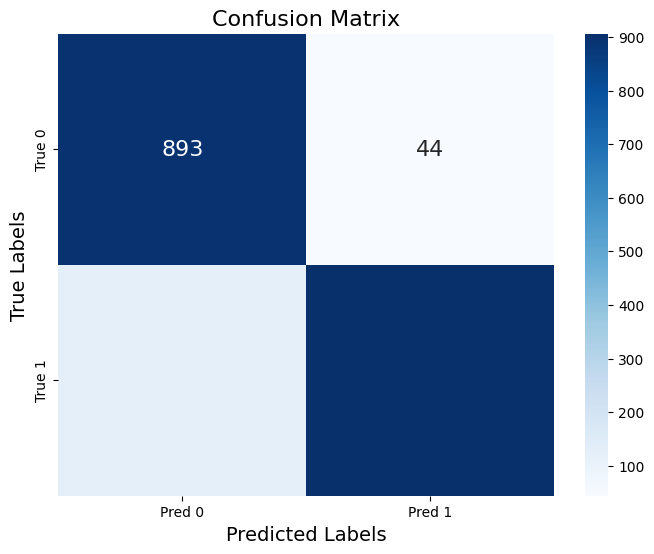

In [131]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Пример: ваши истинные метки и предсказания
# all_labels = [0, 1, 0, 1, ...]  # Настоящие метки
# predictions = [0, 1, 0, 0, ...]  # Предсказанные метки

# Создаем матрицу ошибок
cm = confusion_matrix(all_labels, np.array(predictions)>thresholds[ind])

# Визуализация матрицы ошибок с увеличенным размером графика и меньшим шрифтом
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['True 0', 'True 1'], 
            annot_kws={"size": 16})  # Уменьшаем размер шрифта аннотаций

plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [1]:
import numpy as np

In [2]:
Small = [2,2,3,4,4,5,1,2,2,4,4,5,3,3,3,4,5,2,2,3,4,5]
Long = [2,3,3,4,4,5,3,4,4,5,5,1,2,4,5,5,1,2,3,4,5,3,3,4,4,4,1,2,4,4,5]
Natasha =[1,2,2,4,4,5,1,2,2,4,4,4,1,1,2,2,5,1,2,2,4,4]
real=[2,3,3,4,4,5,1,1,2,2,3,1,1,2,4,4,5,2,4,4,5,1,2,2,3,4,4,2,2,3,4,4,5]

In [5]:
Small = np.array(Small)
Long = np.array(Long)
Natasha = np.array(Natasha)
real= np.array(real)

In [6]:
print(Small.mean(),
Long.mean(),
Natasha.mean(),
real.mean())

3.272727272727273 3.4838709677419355 2.6818181818181817 2.9696969696969697


In [1]:
35 /(35+27+22+5)

0.39325842696629215

In [2]:
27 /(35+27+22+5)

0.30337078651685395

In [3]:
22 /(35+27+22+5)

0.24719101123595505

In [4]:
5 /(35+27+22+5)

0.056179775280898875

In [2]:
169 / (140 - 72*np.sqrt(2))

4.426792745554142

In [3]:
169 / (132 - 64*np.sqrt(2))

4.073238073074892

In [5]:
1/6*(-2 + np.pi + np.log(4))*2/(np.pi - np.log(4)) + (2 - np.pi / 2)

0.9092525677537069

In [6]:
9 /11

0.8181818181818182

In [8]:
(3**8 - 3* 2**8 + 3 + 36) / 8 * 23 * 24 * 25 / 6

1676700.0

In [ ]:
def max_feature_value(N, K, a):
    maximum = -10**9
    
    for i in range(N - K + 1):
        current_window = a[i:i+K]
        current_min = min(current_window)
        current_max = max(current_window)
        max_feature = max(max_feature, current_min * current_max)
    
    return max_feature


N, K = map(int, input().split())
a = list(map(int, input().split()))

maximum = -10**9
    
for i in range(N - K + 1):
    window = a[i:i+K]
    min_ = min(window)
    max_ = max(window)
    maximum = max(maximum, min_ * max_)
    

print(maximum)

15


In [28]:
3683/8192

0.4495849609375

In [ ]:

N, K = map(int, input().split())
a = list(map(int, input().split()))
maximum = -10**18
min_candidates = []
max_candidates = []

left_min = left_max = 0

for right in range(N):
    while min_candidates and a[right] <= a[min_candidates[-1]]:
        min_candidates.pop()
    min_candidates.append(right)
    
    while max_candidates and a[right] >= a[max_candidates[-1]]:
        max_candidates.pop()
    max_candidates.append(right)
    
    while min_candidates[0] <= right - K:
        min_candidates.pop(0)
    while max_candidates[0] <= right - K:
        max_candidates.pop(0)
    
    if right >= K - 1:
        min_ = a[min_candidates[0]]
        max_ = a[max_candidates[0]]
        maximum = max(maximum, max_ * min_)

print(maximum)


90


In [ ]:
input_ = input().split()
N, Q = int(input_[0]), int(input_[1])

input_ = input().split()
a = list(map(int, input_))

p_sum = [0] * (N + 1)
p_sum_sq = [0] * (N + 1)
for i in range(1, N + 1):
    p_sum[i] = p_sum[i - 1] + a[i - 1]
    p_sum_sq[i] = p_sum_sq[i - 1] + a[i - 1] ** 2

for _ in range(Q):
    query = input().split()
    if query[0] == '1':
        k = int(query[1])
        n = len(p_sum) - 1
        total = p_sum[n] - p_sum[n - k]
        total_sq = p_sum_sq[n] - p_sum_sq[n - k]
        mean = total / k
        variance = (total_sq - total * mean) / k
        print("{0:.7f}".format(variance))
    else:
        x = int(query[1])
        p_sum.append(p_sum[-1] + x)
        p_sum_sq.append(p_sum_sq[-1] + x ** 2)


0.2500000
0.6666667
12.5000000
6.2500000


In [ ]:
input_ = input().split()
N, Q = int(input_[0]), int(input_[1])

input_ = input().split()
a = list(map(int, input_))

p_sum = [0] * (N + 1)
p_sum_sq = [0] * (N + 1)
for i in range(1, N + 1):
    p_sum[i] = p_sum[i - 1] + a[i - 1]
    p_sum_sq[i] = p_sum_sq[i - 1] + a[i - 1] ** 2

for _ in range(Q):
    query = input().split()
    if query[0] == '1':
        k = int(query[1])
        n = len(p_sum) - 1
        total = p_sum[n] - p_sum[n - k]
        total_sq = p_sum_sq[n] - p_sum_sq[n - k]
        mean = total / k
        variance = (total_sq - total * mean) / k
        print("{0:.7f}".format(variance))
    else:
        x = int(query[1])
        p_sum.append(p_sum[-1] + x)
        p_sum_sq.append(p_sum_sq[-1] + x ** 2)

In [ ]:

from collections import defaultdict
S = input().strip()
n = len(S)

right_chars = defaultdict(int)
for char in S:
    right_chars[char] += 1

left_chars = defaultdict(int)
count = 0

for i in range(1, n):
    char = S[i - 1]
    left_chars[char] += 1
    right_chars[char] -= 1
    if right_chars[char] == 0:
        del right_chars[char]

    if set(left_chars.keys()) == set(right_chars.keys()):
        count += 1

print(count if count > 0 else -1)

1


In [24]:
S = input().strip()
n = len(S)

total_counts = [0] * 10
for char in S:
    total_counts[int(char)] += 1

left_counts = [0] * 10
right_counts = total_counts.copy()
count = 0

for i in range(n):
    current_digit = int(S[i])
    left_counts[current_digit] += 1
    right_counts[current_digit] -= 1

    left_set = {d for d in range(10) if left_counts[d] > 0}
    right_set = {d for d in range(10) if right_counts[d] > 0}

    if left_set == right_set:
        count += 1

print(count if count > 0 else -1)

# # Чтение входных данных
# s = input().strip()

# # Вычисление и вывод результата
# print(count_symmetric_cuts(s))

2


In [15]:
def solve():
    input_ = input().split()
    N, Q = int(input_[0]), int(input_[1])

    input_ = input().split()
    a = list(map(int, input_))

    prefix_sum = [0] * (N + 1)
    prefix_sum_sq = [0] * (N + 1)
    print()
    for i in range(1, N + 1):
        prefix_sum[i] = prefix_sum[i - 1] + a[i - 1]
        prefix_sum_sq[i] = prefix_sum_sq[i - 1] + a[i - 1] ** 2
    
    output = []
    
    for _ in range(Q):
        query = input().split()
        if query[0] == '1':
            k = int(query[1])
            n = len(prefix_sum) - 1
            total = prefix_sum[n] - prefix_sum[n - k]
            total_sq = prefix_sum_sq[n] - prefix_sum_sq[n - k]
            mean = total / k
            variance = (total_sq - total * mean) / k
            print("{0:.7f}".format(variance))
        else:
            x = int(query[1])
            prefix_sum.append(prefix_sum[-1] + x)
            prefix_sum_sq.append(prefix_sum_sq[-1] + x ** 2)
    
    

solve()


0.2500000
0.6666667
12.5000000
6.2500000


In [2]:
import sys

def solve():
    ptr = 0
    input_ = input().split()
    Q, L = int(input_[0]), int(input_[1])
    
    
    ptr += 2
    
    points = [0, L]
    prefix = [0, L]
    total = L
    count = 1  
    
    output = []
    
    for _ in range(Q):
        query = input().split()
        if query[0] == '3':
            # Запрос среднего
            avg = total / count
            output.append("{0:.7f}".format(avg))
            ptr += 1
        else:
            X = int(query[1])
            ptr += 2
            if query[0] == '1':
                # Добавление точки (вставка с сортировкой)
                i = 0
                while i < len(points) and points[i] < X:
                    i += 1
                points.insert(i, X)
                left_sum = X * i - prefix[i]
                right_sum = (prefix[-1] - prefix[i]) - X * (len(points) - 1 - i)
                total += left_sum + right_sum
                prefix.insert(i+1, prefix[i] + X)
                for j in range(i+1, len(prefix)):
                    prefix[j] += X
                count += len(points) - 1
            else:
                # Удаление точки
                i = 0
                while i < len(points) and points[i] != X:
                    i += 1
                left_sum = X * i - prefix[i]
                right_sum = (prefix[-1] - prefix[i+1]) - X * (len(points) - 1 - i)
                total -= left_sum + right_sum
                points.pop(i)
                prefix.pop(i+1)
                for j in range(i+1, len(prefix)):
                    prefix[j] -= X
                count -= len(points)
    
    print('\n'.join(output))

solve()

7.0000000
0.0000000
-0.5000000
1.6666667


In [5]:
import bisect

def main():
    # Чтение входных данных
    input_ = input().split()
    Q, L = int(input_[0]), int(input_[1])
    
    # Инициализация структур данных
    points = [0, L]          # Отсортированный список точек
    prefix = [0, L]          # Префиксные суммы координат
    total = L                # Сумма всех попарных расстояний
    count = 1                # Количество пар (изначально 0-7)
    
    output = []              # Список для хранения результатов
    
    # Обработка Q запросов
    for _ in range(Q):
        query = input().split()
        
        if query[0] == '3':
            # Запрос на получение среднего расстояния
            avg = total / count
            output.append(f"{avg:.7f}")
        
        elif query[0] == '1':
            # Добавление новой точки
            X = int(query[1])
            
            # Находим позицию для вставки
            pos = bisect.bisect_left(points, X)
            
            # Вычисляем вклад в общую сумму
            left_sum = X * pos - prefix[pos]
            right_sum = (prefix[-1] - prefix[pos]) - X * (len(points) - pos)
            total += left_sum + right_sum
            
            # Вставляем точку и обновляем префиксные суммы
            bisect.insort(points, X)
            prefix.insert(pos + 1, prefix[pos] + X)
            for i in range(pos + 1, len(prefix)):
                prefix[i] += X
            
            # Увеличиваем количество пар
            count += len(points) - 1
        
        elif query[0] == '2':
            # Удаление точки
            X = int(query[1])
            pos = bisect.bisect_left(points, X)
            
            # Вычитаем вклад удаляемой точки
            left_sum = X * pos - prefix[pos]
            right_sum = (prefix[-1] - prefix[pos + 1]) - X * (len(points) - pos - 1)
            total -= left_sum + right_sum
            
            # Удаляем точку и обновляем префиксные суммы
            points.pop(pos)
            prefix.pop(pos + 1)
            for i in range(pos + 1, len(prefix)):
                prefix[i] -= X
            
            # Уменьшаем количество пар
            count -= len(points)
    
    # Вывод результатов
    print('\n'.join(output))


main()

7.0000000
0.0000000
-0.5000000
1.6666667


In [8]:
65+56

121

In [19]:
def digit_sum(num: int) -> int:
    return sum(int(ch) for ch in str(abs(num)))
A = input().strip()
n = len(A)
mult = int((10**n - 1) / 9)
sum_ = sum(int(d)*mult for d in A)

print(sum(int(ch) for ch in str(sum_)))

30


In [ ]:
A = input().strip()
digit_sum = sum(int(d) for d in A)
n = len(A)

# сумма всех сдвигов: digit_sum * (10^n - 1) // 9
# нам нужно только сумму его цифр
# вычислим само число как строку и просуммируем его цифры

# Используем string-multiplication вместо численного перемножения
ones = '1' * n
number = str(digit_sum * int(ones))
print(sum(int(ch) for ch in number))


In [24]:
24*2024+8

48584

In [26]:
48584 / 8

6073.0

In [ ]:
import bisect

Q, L = map(int, input().split())
points = [0, L]

prefix_sum = [0, L]

def update_prefix_sum():
    prefix_sum.clear()
    s = 0
    for p in points:
        s += p
        prefix_sum.append(s)

update_prefix_sum()

for _ in range(Q):
    query = input().split()
    t = int(query[0])
    
    if t == 1:
        
        X = int(query[1])
        pos = bisect.bisect_left(points, X)
        points.insert(pos, X)
        update_prefix_sum()
        
    elif t == 2:
        
        X = int(query[1])
        pos = bisect.bisect_left(points, X)
        points.pop(pos)
        update_prefix_sum()
        
    else:
        
        n = len(points)
        if n == 2:
            
            print(f"{float(L):.7f}")
            continue
        
        S = 0
        for j in range(1, n):
            x_j = points[j]
            P_j_1 = prefix_sum[j-1]
            S += j * x_j - P_j_1
        
        E = 2 * S / (n * (n - 1))
        print(f"{E:.7f}")


7.0000000
4.6666667
3.6666667
4.6666667


In [20]:
A = input().strip()
digit_sum = sum(int(d) for d in A)
n = len(A)


result_digit_sum = 0
for _ in range(n):
    result_digit_sum += sum(int(d) for d in str(digit_sum))

print(result_digit_sum)

9


In [11]:
(10**10 - 1) / 9

1111111111.0

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        base_model = models.resnet18()
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Убираем последний слой

    def forward(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)  # Разворачиваем тензор
res = ResNetFeatureExtractor()

In [ ]:
import mne

def load_eeg(file_path):
    raw = mne.io.read_raw(file_path, preload=True)
    raw.filter(1, 40)  # Фильтрация сигнала
    return raw.get_data()  # Возвращает данные как numpy-массив (каналы x время)


In [163]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.nn.functional.pairwise_distance(anchor, positive)
        neg_dist = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.mean(torch.clamp(pos_dist - neg_dist + self.margin, min=0.0))
        return loss


In [ ]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        z_i = torch.nn.functional.normalize(z_i, dim=1)
        z_j = torch.nn.functional.normalize(z_j, dim=1)
        similarity_matrix = torch.mm(z_i, z_j.T)
        logits = similarity_matrix / self.temperature
        labels = torch.arange(z_i.size(0)).cuda()  # для положительных пар
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss


In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, scale=30.0, margin=0.50):
        super(ArcFaceLoss, self).__init__()
        self.scale = scale
        self.margin = margin

    def forward(self, logits, labels):
        cos_theta = torch.nn.functional.normalize(logits)
        target_logits = cos_theta.gather(1, labels.view(-1, 1))
        target_logits = target_logits + self.margin
        logits = cos_theta * self.scale
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss


In [72]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feature_dim, alpha=0.5):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.alpha = alpha
        self.centers = nn.Parameter(torch.randn(num_classes, feature_dim)).to(mps_device)

    def forward(self, features, labels):
        batch_size = features.size(0)
        centers_batch = self.centers[labels]
        loss = torch.sum((features - centers_batch) ** 2) / batch_size
        return loss


In [65]:
import torch
from torch.utils.data import Dataset
import random

class TripletDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Создает датасет для обучения с Triplet Loss.

        :param data: Список или массив сэмплов (N x ...).
        :param labels: Список или массив меток (N).
        :param transform: Аугментации (если применяются).
        """
        self.data = data
        self.labels = labels
        self.transform = transform

        # Группировка индексов по классам для быстрой выборки
        self.label_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

    def __getitem__(self, index):
        # Anchor
        anchor = self.data[index]
        anchor_label = self.labels[index]

        # Positive (другой сэмпл с таким же классом, как у anchor)
        positive_index = random.choice(self.label_to_indices[anchor_label])
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive = self.data[positive_index]

        # Negative (сэмпл с другим классом)
        negative_label = random.choice(list(self.label_to_indices.keys()))
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative = self.data[negative_index]

        # Применяем аугментации (если есть)
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return torch.tensor(anchor, dtype=torch.float32), \
               torch.tensor(positive, dtype=torch.float32), \
               torch.tensor(negative, dtype=torch.float32), torch.tensor(anchor_label)

    def __len__(self):
        return len(self.data)


In [100]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class ResNetForEEG(nn.Module):
    def __init__(self, embedding_dim=128, width=128):
        """
        Адаптированная ResNet18 для данных EEG.
        
        :param embedding_dim: Размер эмбеддингового пространства.
        :param width: Ширина входного изображения (гиперпараметр).
        """
        super(ResNetForEEG, self).__init__()
        self.width = width

        # Загружаем базовую модель ResNet18
        self.base_model = resnet18(pretrained=False)

        # Меняем первый слой для обработки входа (1 канал вместо 3)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Меняем размерность выходного слоя
        self.base_model.fc = nn.Identity()  # Убираем последний слой классификации

        # Вычисляем размер выходных фичей ResNet
        dummy_input = torch.randn(1, 1, 19, self.width)
        with torch.no_grad():
            dummy_output = self.base_model(dummy_input)
        self.feature_dim = dummy_output.shape[1]
        print(dummy_output.shape)
        # Добавляем эмбеддинговый слой
        self.embedding_layer = nn.Sequential(
            nn.Linear(self.feature_dim, embedding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)  # Извлечение признаков
        x = self.embedding_layer(x)  # Преобразование в пространство эмбеддингов
        return x

In [101]:
import os
import mne  # Для работы с .set файлами
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class TripletEEGDataset(Dataset):
    def __init__(self, files, labels, segment_length=128, transform=None):
        """
        Датасет для триплет-обучения на основе EEG данных.

        :param files: Список путей к файлам .set.
        :param labels: Метки классов (0 - норм, 1 - эпилепсия).
        :param segment_length: Длина сегмента в отсчетах (по ширине).
        :param transform: Аугментации (если применяются).
        """
        self.files = files
        self.labels = labels
        self.segment_length = segment_length
        self.transform = transform

        # Предобработка: загружаем данные
        self.data = []
        self.data_labels = []
        for file, label in zip(files, labels):
            eeg_data = self._load_eeg(file)
            self.data.append(eeg_data)
            self.data_labels.append([label] * len(eeg_data))

        self.data = np.concatenate(self.data, axis=0)
        self.data_labels = np.concatenate(self.data_labels, axis=0)

        # Группировка индексов по классам
        self.label_to_indices = {
            label: np.where(self.data_labels == label)[0]
            for label in np.unique(self.data_labels)
        }
    def sliding_window_segments(self, raw_data, segment_length, stride=8):
        num_channels, total_length = raw_data.shape
        if segment_length > total_length:
            raise ValueError("Segment length cannot be greater than the total length of the data.")
        if stride <= 0:
            raise ValueError("Stride must be a positive integer.")

        num_segments = (total_length - segment_length) // stride + 1

        # Создание скользящих окон
        windows = np.lib.stride_tricks.as_strided(
            raw_data,
            shape=(num_segments, num_channels, segment_length),
            strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1]),
        )

        return windows
    def _load_eeg(self, file):
        """
        Загружает и обрабатывает EEG из файла .set.
        """
        raw = mne.io.read_raw_eeglab(file, preload=True)
        raw_data = raw.get_data()  # Данные в формате (каналы, временные точки)
        segmented_data = self.sliding_window_segments(raw_data, self.segment_length)
        return segmented_data

    def __getitem__(self, index):
        # Anchor
        anchor = self.data[index]
        anchor_label = self.data_labels[index]

        # Positive
        positive_index = np.random.choice(self.label_to_indices[anchor_label])
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive = self.data[positive_index]

        # Negative
        negative_label = 1 - anchor_label
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative = self.data[negative_index]

        # Аугментации (если есть)
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return (
            torch.tensor(anchor, dtype=torch.float32).unsqueeze(0),
            torch.tensor(positive, dtype=torch.float32).unsqueeze(0),
            torch.tensor(negative, dtype=torch.float32).unsqueeze(0), torch.tensor(anchor_label)
        )

    def __len__(self):
        return len(self.data)


# Разделение файлов на тренировочные и валидационные
def create_datasets(folder, segment_length=128):
    # Читаем все файлы
    all_files = [f for f in os.listdir(folder) if f.endswith(".set")]
    epi_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_epi.set")]
    norm_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_norm.set")]
    print(len(epi_files), len(norm_files))
    # Подготовка данных
    train_files = epi_files[:-1] + norm_files[:-1]
    train_labels = [1] * (len(epi_files)-1) + [0] * (len(norm_files)-1)
    val_files = [epi_files[-1]] + [norm_files[-1]]
    val_labels = [1] + [0]

    # Создаем датасеты
    train_dataset = TripletEEGDataset(train_files, train_labels, segment_length)
    val_dataset = TripletEEGDataset(val_files, val_labels, segment_length)

    return train_dataset, val_dataset


Dataset size: 1000
torch.Size([1, 19, 128]) torch.Size([1, 19, 128]) torch.Size([1, 19, 128])


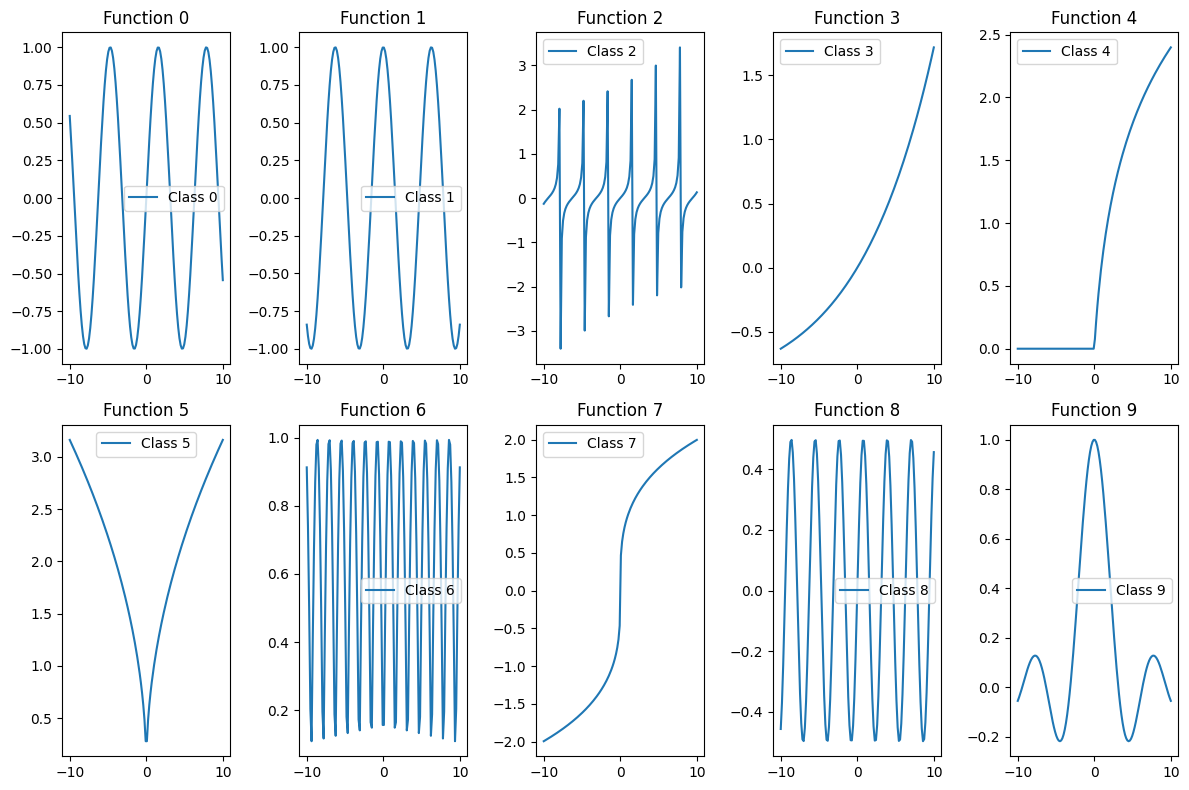

In [40]:
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class TripletFunctionDataset(Dataset):
    def __init__(self, num_samples=1000, segment_length=128, noise_std=0.1, num_channels=19):
        self.segment_length = segment_length
        self.noise_std = noise_std
        self.num_classes = 10
        self.num_channels = num_channels
        
        # Определение функций
        self.functions = [
            lambda x: np.sin(x),
            lambda x: np.cos(x),
            lambda x: np.tan(x) / 5,
            lambda x: np.exp(x / 10) - 1,
            lambda x: np.log1p(np.clip(x, 0, None)),  # Ограничение x >= 0
            lambda x: np.sqrt(np.clip(np.abs(x), 0, None)),
            lambda x: np.abs(np.sin(x * 2)),
            lambda x: np.sign(x) * np.abs(x) ** 0.3,
            lambda x: np.sin(x) * np.cos(x),
            lambda x: np.sinc(x / np.pi)
        ]
        
        # Генерация данных
        self.data, self.labels = self._generate_data(num_samples)
        
        # Группировка индексов по классам
        self.label_to_indices = {
            label: np.where(self.labels == label)[0]
            for label in np.unique(self.labels)
        }
    
    def _generate_data(self, num_samples):
        x = np.linspace(-10, 10, self.segment_length)
        data = []
        labels = []
        
        for label, func in enumerate(self.functions):
            for _ in range(num_samples // self.num_classes):
                y = func(x)
                y = np.nan_to_num(y, nan=0.0, posinf=1.0, neginf=-1.0)  # Обработка NaN и бесконечностей
                y += np.random.normal(0, self.noise_std, size=x.shape)  # Добавление шума
                y_multichannel = np.stack([y + np.random.normal(0, self.noise_std, size=y.shape) for _ in range(self.num_channels)], axis=0)  # 19 каналов
                data.append(y_multichannel)
                labels.append(label)
        
        return np.array(data), np.array(labels)
    
    def __getitem__(self, index):
        anchor = self.data[index]
        anchor_label = self.labels[index]
        
        # Positive
        positive_index = np.random.choice(self.label_to_indices[anchor_label])
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive = self.data[positive_index]
        
        # Negative
        negative_label = np.random.choice([l for l in range(self.num_classes) if l != anchor_label])
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative = self.data[negative_index]
        
        return (
            torch.tensor(anchor, dtype=torch.float32).unsqueeze(0),
            torch.tensor(positive, dtype=torch.float32).unsqueeze(0),
            torch.tensor(negative, dtype=torch.float32).unsqueeze(0),
        )
    
    def __len__(self):
        return len(self.data)

# Пример использования
dataset = TripletFunctionDataset()
print(f"Dataset size: {len(dataset)}")
anchor, positive, negative = dataset[0]
print(anchor.shape, positive.shape, negative.shape)

# Отображение всех типов функций
x = np.linspace(-10, 10, 128)
plt.figure(figsize=(12, 8))
for i, func in enumerate(dataset.functions):
    plt.subplot(2, 5, i + 1)
    y = func(x)
    y = np.nan_to_num(y, nan=0.0, posinf=1.0, neginf=-1.0)  # Обработка NaN и бесконечностей
    plt.plot(x, y, label=f'Class {i}')
    plt.title(f'Function {i}')
    plt.legend()
plt.tight_layout()
plt.show()




In [41]:
segment_length = 128  # Гиперпараметр (длина сегмента)
train_dataset = TripletFunctionDataset(num_samples=10000, segment_length=128, noise_std=0.1, num_channels=19)
val_dataset = TripletFunctionDataset(num_samples=1000, segment_length=128, noise_std=0.1, num_channels=19)
# # train_dataset, val_dataset = create_datasets(folder_path, segment_length)
# # DataLoader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [42]:
train_dataset[0][0].shape

torch.Size([1, 19, 128])

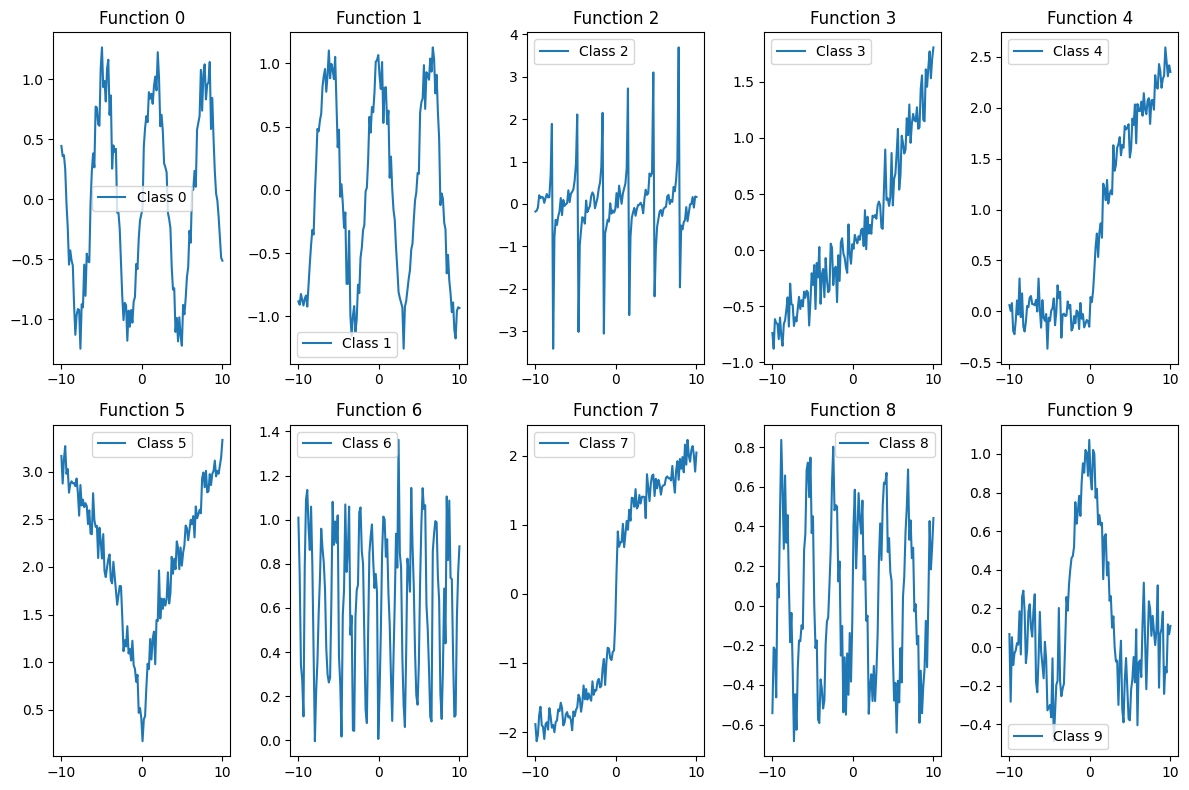

In [43]:
# Отображение всех типов функций
x = np.linspace(-10, 10, 128)
plt.figure(figsize=(12, 8))
for i, func in enumerate(dataset.functions):
    plt.subplot(2, 5, i + 1)
    plt.plot(x, train_dataset[i*1000][0][0][0], label=f'Class {i}')
    plt.title(f'Function {i}')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def compute_correlation_matrix(eeg_segment):
    """
    Рассчитывает корреляционную матрицу между каналами EEG-сегмента.
    :param eeg_segment: Тензор формы (каналы, временные точки)
    :return: Корреляционная матрица формы (каналы, каналы)
    """
    eeg_segment = eeg_segment - eeg_segment.mean(dim=1, keepdim=True)
    std = eeg_segment.std(dim=1, keepdim=True) + 1e-6
    normalized = eeg_segment / std
    correlation_matrix = torch.mm(normalized, normalized.T) / normalized.shape[1]
    return correlation_matrix

class EEGAnomalyDetector(nn.Module):
    def __init__(self, num_channels):
        super(EEGAnomalyDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * num_channels * num_channels, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавляем канал
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Пример использования:
num_channels = 19  # Количество каналов в EEG
model = EEGAnomalyDetector(num_channels)

def prepare_input(eeg_segment):
    corr_matrix = compute_correlation_matrix(torch.tensor(eeg_segment, dtype=torch.float32))
    return corr_matrix.unsqueeze(0)  # Добавляем размерность батча

# Генерация случайного EEG-сегмента для теста
random_eeg_segment = np.random.randn(num_channels, 128)
input_tensor = prepare_input(random_eeg_segment)
out = model(input_tensor)
print("Аномалия (вероятность):", out.item())

In [1]:
import os
import mne  # Для работы с .set файлами
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.decomposition import FastICA
import mne
import numpy as np
import torch
from torch.utils.data import Dataset

class TripletEEGDataset(Dataset):
    def __init__(self, files, labels, segment_length=128, transform=None, add_anomalies=False):
        """
        Датасет для триплет-обучения на основе EEG данных с ICA.

        :param files: Список путей к файлам .set.
        :param labels: Метки классов (0 - норм, 1 - эпилепсия).
        :param segment_length: Длина сегмента в отсчетах (по ширине).
        :param transform: Аугментации (если применяются).
        :param add_anomalies: Добавлять ли искусственные выбросы в нормальные данные.
        """
        self.files = files
        self.labels = labels
        self.segment_length = segment_length
        self.transform = transform
        self.add_anomalies = add_anomalies

        # Предобработка: загружаем данные
        self.data = []
        self.data_labels = []
        for file, label in zip(files, labels):
            eeg_data = self._load_eeg(file)
            if label == 0 and self.add_anomalies:
                eeg_data = self._add_artifacts(eeg_data)  # Добавляем синтетические артефакты
            self.data.append(eeg_data)
            self.data_labels.append([label] * len(eeg_data))

        self.data = np.concatenate(self.data, axis=0)
        self.data_labels = np.concatenate(self.data_labels, axis=0)

        # Группировка индексов по классам
        self.label_to_indices = {
            label: np.where(self.data_labels == label)[0]
            for label in np.unique(self.data_labels)
        }

    def sliding_window_segments(self, raw_data, segment_length, stride=8):
        num_channels, total_length = raw_data.shape
        if segment_length > total_length:
            raise ValueError("Segment length cannot be greater than the total length of the data.")
        if stride <= 0:
            raise ValueError("Stride must be a positive integer.")

        num_segments = (total_length - segment_length) // stride + 1

        # Создание скользящих окон
        windows = np.lib.stride_tricks.as_strided(
            raw_data,
            shape=(num_segments, num_channels, segment_length),
            strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1]),
        )

        return windows

    def _load_eeg(self, file):
        """
        Загружает и обрабатывает EEG из файла .set, применяя ICA.
        """
        raw = mne.io.read_raw_eeglab(file, preload=True)
        raw_data = raw.get_data()  # Данные в формате (каналы, временные точки)

        # Применяем ICA
        ica = FastICA(n_components=raw_data.shape[0], random_state=0)
        ica_sources = ica.fit_transform(raw_data.T).T  # Применяем ICA к данным

        segmented_data = self.sliding_window_segments(ica_sources, self.segment_length)
        return segmented_data

    def _add_artifacts(self, data):
        """
        Добавляет случайные аномалии в нормальные EEG-сегменты.
        """
        num_samples, num_channels, segment_length = data.shape
        for i in range(num_samples):
            if np.random.rand() < 0.3:  # 30% вероятности добавить выброс
                channel = np.random.randint(0, num_channels)
                anomaly_type = np.random.choice(["spike", "noise", "step", "sin_wave"])
                if anomaly_type == "spike":
                    data[i, channel, np.random.randint(0, segment_length)] += np.random.uniform(5, 10)
                elif anomaly_type == "noise":
                    data[i, channel] += np.random.normal(0, 1, size=segment_length) * 2
                elif anomaly_type == "step":
                    data[i, channel, segment_length // 2:] += np.random.uniform(3, 6)
                elif anomaly_type == "sin_wave":
                    t = np.linspace(0, np.pi * 2, segment_length)
                    data[i, channel] += np.sin(t * np.random.uniform(5, 15)) * np.random.uniform(1, 3)
        return data

    def __getitem__(self, index):
        # Anchor
        anchor = self.data[index]
        anchor_label = self.data_labels[index]

        # Positive
        positive_index = np.random.choice(self.label_to_indices[anchor_label])
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive = self.data[positive_index]

        # Negative
        negative_label = 1 - anchor_label
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative = self.data[negative_index]

        # Аугментации (если есть)
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return (
            torch.tensor(anchor, dtype=torch.float32).unsqueeze(0),
            torch.tensor(positive, dtype=torch.float32).unsqueeze(0),
            torch.tensor(negative, dtype=torch.float32).unsqueeze(0), torch.tensor(anchor_label)
        )

    def __len__(self):
        return len(self.data)


# Разделение файлов на тренировочные и валидационные
def create_datasets(folder, segment_length=128, add_anomalies=False):
    # Читаем все файлы
    all_files = [f for f in os.listdir(folder) if f.endswith(".set")]
    epi_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_epi.set")]
    norm_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_norm.set")]

    print(len(epi_files), len(norm_files))
    # Подготовка данных
    train_files = epi_files[:-1] + norm_files[:-1]
    train_labels = [1] * (len(epi_files)-1) + [0] * (len(norm_files)-1)
    val_files = [epi_files[-1]] + [norm_files[-1]]
    val_labels = [1] + [0]

    # Создаем датасеты
    train_dataset = TripletEEGDataset(train_files, train_labels, segment_length, add_anomalies=add_anomalies)
    val_dataset = TripletEEGDataset(val_files, val_labels, segment_length)

    return train_dataset, val_dataset

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import mne
from torch.utils.data import Dataset, DataLoader

def compute_correlation_matrix(eeg_segment):
#     print(eeg_segment.shape)
    eeg_segment = eeg_segment - eeg_segment.mean(dim=1, keepdim=True)
    std = eeg_segment.std(dim=1, keepdim=True) + 1e-6
    normalized = eeg_segment / std
    correlation_matrix = torch.mm(normalized, normalized.T) / normalized.shape[1]
    return correlation_matrix

class EEGAnomalyDetector(nn.Module):
    def __init__(self, num_channels):
        super(EEGAnomalyDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * num_channels * num_channels, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class EEGDataset(Dataset):
    def __init__(self, files, labels, segment_length=128):
        self.files = files
        self.labels = labels
        self.segment_length = segment_length
        self.data = []
        self.data_labels = []
        
        for file, label in zip(files, labels):
            eeg_data = self._load_eeg(file)
            self.data.append(eeg_data)
            self.data_labels.append([label] * len(eeg_data))
        
        self.data = np.concatenate(self.data, axis=0)
        self.data_labels = np.concatenate(self.data_labels, axis=0)
        print(self.data.shape)

    def sliding_window_segments(self, raw_data, segment_length, stride=8):
        num_channels, total_length = raw_data.shape
        if segment_length > total_length:
            raise ValueError("Segment length cannot be greater than the total length of the data.")
        if stride <= 0:
            raise ValueError("Stride must be a positive integer.")

        num_segments = (total_length - segment_length) // stride + 1

        # Создание скользящих окон
        windows = np.lib.stride_tricks.as_strided(
            raw_data,
            shape=(num_segments, num_channels, segment_length),
            strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1]),
        )

        return windows

    def _load_eeg(self, file):
        """
        Загружает и обрабатывает EEG из файла .set.
        """
        raw = mne.io.read_raw_eeglab(file, preload=True)
        raw_data = raw.get_data()  # Данные в формате (каналы, временные точки)
        segmented_data = self.sliding_window_segments(raw_data, self.segment_length)
        return segmented_data

    def __getitem__(self, index):
        eeg_segment = self.data[index]
        label = self.data_labels[index]
        correlation_matrix = compute_correlation_matrix(torch.tensor(eeg_segment, dtype=torch.float32))
        return correlation_matrix, torch.tensor(label, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

# Функция для обучения модели с валидацией
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for eeg_corr, label in train_loader:
            optimizer.zero_grad()
            output = model(eeg_corr)
            loss = criterion(output.squeeze(), label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for eeg_corr, label in val_loader:
                output = model(eeg_corr).squeeze()
                loss = criterion(output, label)
                val_loss += loss.item()
                predicted = (output > 0.5).float()
                correct += (predicted == label).sum().item()
                total += label.size(0)
        
        val_accuracy = correct / total
        torch.save(model, f"train_corr/resnet18_{epoch}_{val_accuracy}.pt")
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Acc: {val_accuracy:.4f}')

# # Создание датасета и загрузчиков данных
# train_files = ["path/to/eeg1.set", "path/to/eeg2.set"]  # Заменить на реальные пути
# train_labels = [0, 1]
# val_files = ["path/to/eeg3.set"]  # Добавить валидационные данные
# val_labels = [1]
def create_datasets(folder, segment_length=128, add_anomalies=False):
    # Читаем все файлы
    all_files = [f for f in os.listdir(folder) if f.endswith(".set")]
    epi_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_epi.set")]
    norm_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_norm.set")]

    print(len(epi_files), len(norm_files))
    # Подготовка данных
    train_files = epi_files[:-1] + norm_files[:-1]
    train_labels = [1] * (len(epi_files)-1) + [0] * (len(norm_files)-1)
    val_files = [epi_files[-1]] + [norm_files[-1]]
    val_labels = [1] + [0]

    # Создаем датасеты
    train_dataset = EEGDataset(train_files, train_labels, segment_length)
    val_dataset = EEGDataset(val_files, val_labels, segment_length)

    return train_dataset, val_dataset
# dataset_train = EEGDataset(train_files, train_labels)
# dataset_val = EEGDataset(val_files, val_labels)
folder_path = "/Users/egorperelygin/Downloads/обучение"

# Создаем тренировочный и валидационный датасеты
segment_length = 128  # Гиперпараметр (длина сегмента)
train_dataset, dataset_val = create_datasets(folder_path, segment_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False)

model = EEGAnomalyDetector(num_channels=19)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_model(model, train_loader, val_loader, criterion, optimizer)


13 9
Reading /Users/egorperelygin/Downloads/обучение/Epi_Sazonov_export_full_epi.fdt
Reading 0 ... 2531  =      0.000 ...    25.310 secs...
Reading /Users/egorperelygin/Downloads/обучение/ЯНКО_full_epi.fdt
Reading 0 ... 12954  =      0.000 ...   129.540 secs...


/Users/egorperelygin/anaconda3/lib/python3.10/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


Reading /Users/egorperelygin/Downloads/обучение/epi_all_full_epi.fdt
Reading 0 ... 22821  =      0.000 ...   228.210 secs...
Reading /Users/egorperelygin/Downloads/обучение/KartsevaSI-epiL_export_full_epi.fdt
Reading 0 ... 31202  =      0.000 ...   312.020 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/Downloads/обучение/солоненко_full_epi.fdt
Reading 0 ... 11378  =      0.000 ...   113.780 secs...
Reading /Users/egorperelygin/Downloads/обучение/Frolova2_epi_export_full_epi.fdt
Reading 0 ... 805  =      0.000 ...     8.050 secs...
Reading /Users/egorperelygin/Downloads/обучение/kochkin_epi2_export_full_epi.fdt
Reading 0 ... 4366  =      0.000 ...    43.660 secs...
Reading /Users/egorperelygin/Downloads/обучение/k_epi1_export_full_epi.fdt
Reading 0 ... 634  =      0.000 ...     6.340 secs...
Reading /Users/egorperelygin/Downloads/обучение/Курлаев_full_epi.fdt
Reading 0 ... 32815  =      0.000 ...   328.150 secs...
Reading /Users/egorperelygin/Downloads/обучение/Frolova_epi_export_full_epi.fdt
Reading 0 ... 12414  =      0.000 ...   124.140 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/Downloads/обучение/epi_export_full_epi.fdt
Reading 0 ... 358  =      0.000 ...     3.580 secs...
Reading /Users/egorperelygin/Downloads/обучение/МОсковская_full_epi.fdt
Reading 0 ... 1335  =      0.000 ...    13.350 secs...
Reading /Users/egorperelygin/Downloads/обучение/itkina_full_norm.fdt
Reading 0 ... 56934  =      0.000 ...   569.340 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/Downloads/обучение/Быховая_full_norm.fdt
Reading 0 ... 61843  =      0.000 ...   618.430 secs...
Reading /Users/egorperelygin/Downloads/обучение/Бойко_2_full_norm.fdt
Reading 0 ... 29386  =      0.000 ...   293.860 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Data file name in EEG.data (Быховая_ull_epi.fdt) is incorrect, the file name must have changed on disk, using the correct file name (Быховая_full_norm.fdt).
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Data file name in EEG.data (Бойко_2_full_epi.fdt) is incorrect, the file name must have changed on disk, using the correct file name (Бойко_2_full_norm.fdt).
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/Downloads/обучение/epi_all_full_norm.fdt
Reading 0 ... 13443  =      0.000 ...   134.430 secs...
Reading /Users/egorperelygin/Downloads/обучение/Бойко_full_norm.fdt
Reading 0 ... 41912  =      0.000 ...   419.120 secs...
Reading /Users/egorperelygin/Downloads/обучение/medvedev_full_norm.fdt
Reading 0 ... 15829  =      0.000 ...   158.290 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Data file name in EEG.data (Бойко_full_epi.fdt) is incorrect, the file name must have changed on disk, using the correct file name (Бойко_full_norm.fdt).
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/Downloads/обучение/Баранская_full_norm.fdt
Reading 0 ... 10973  =      0.000 ...   109.730 secs...
Reading /Users/egorperelygin/Downloads/обучение/strelchenco_full_norm.fdt
Reading 0 ... 27900  =      0.000 ...   279.000 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


(48671, 19, 128)
Reading /Users/egorperelygin/Downloads/обучение/Frolova1_epi_export_full_epi.fdt
Reading 0 ... 52725  =      0.000 ...   527.250 secs...
Reading /Users/egorperelygin/Downloads/обучение/test_epi_full_norm.fdt
Reading 0 ... 74411  =      0.000 ...   744.110 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_6549/1561787404.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


(15861, 19, 128)


KeyboardInterrupt: 

In [1]:
# Check that MPS is available
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [2]:
import os
import mne  # Для работы с .set файлами
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class NormalizeWindow:
    """
    Нормализует каждое окно отдельно: центрирование и масштабирование.
    """

    def __call__(self, eeg_window):
        mean = np.mean(eeg_window, axis=1, keepdims=True)  # Среднее по каждому каналу
        std = np.std(eeg_window, axis=1, keepdims=True)
        return (eeg_window - mean) / std


class TripletEEGDataset(Dataset):
    def __init__(self, files, labels, segment_length=128, stride=64, transform=None):
        """
        Датасет для триплет-обучения на основе EEG данных.

        :param files: Список путей к файлам .set.
        :param labels: Метки классов (0 - норм, 1 - эпилепсия).
        :param segment_length: Длина сегмента в отсчетах (по ширине).
        :param transform: Аугментации (если применяются).
        """
        self.files = files
        self.labels = labels
        self.segment_length = segment_length
        self.transform = transform if transform else NormalizeWindow()

        # Предобработка: загружаем данные
        self.data = []
        self.data_labels = []
        for file, label in zip(files, labels):
            eeg_data = self._load_eeg(file, stride=stride)
            self.data.append(eeg_data)
            self.data_labels.append([label] * len(eeg_data))

        self.data = np.concatenate(self.data, axis=0)
        self.data_labels = np.concatenate(self.data_labels, axis=0)

        # Группировка индексов по классам
        self.label_to_indices = {
            label: np.where(self.data_labels == label)[0]
            for label in np.unique(self.data_labels)
        }

    def sliding_window_segments(self, raw_data, segment_length, stride=64):
        num_channels, total_length = raw_data.shape
        if segment_length > total_length:
            raise ValueError("Segment length cannot be greater than the total length of the data.")
        if stride <= 0:
            raise ValueError("Stride must be a positive integer.")

        num_segments = (total_length - segment_length) // stride + 1

        # Создание скользящих окон
        windows = np.lib.stride_tricks.as_strided(
            raw_data,
            shape=(num_segments, num_channels, segment_length),
            strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1]),
        )

        return windows

    def _load_eeg(self, file, stride):
        """
        Загружает и обрабатывает EEG из файла .set.
        """
        raw = mne.io.read_raw_eeglab(file, preload=True)
        raw_data = raw.get_data()  # Данные в формате (каналы, временные точки)
        segmented_data = self.sliding_window_segments(raw_data, self.segment_length, stride=stride)
        return segmented_data

    def __getitem__(self, index):
        # Anchor
        anchor = self.transform(self.data[index])
        anchor_label = self.data_labels[index]

        # Positive
        positive_index = np.random.choice(self.label_to_indices[anchor_label])
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive = self.transform(self.data[positive_index])

        # Negative
        negative_label = 1 - anchor_label
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative = self.transform(self.data[negative_index])

        return (
            torch.tensor(anchor, dtype=torch.float32).unsqueeze(0),
            torch.tensor(positive, dtype=torch.float32).unsqueeze(0),
            torch.tensor(negative, dtype=torch.float32).unsqueeze(0), 
            torch.tensor(anchor_label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)


# Разделение файлов на тренировочные и валидационные
def create_datasets(folder, segment_length=128):
    # Читаем все файлы
    all_files = [f for f in os.listdir(folder) if f.endswith(".set")]
    epi_files = [os.path.join(folder, f) for f in all_files if f.endswith("epi.set")]
    norm_files = [os.path.join(folder, f) for f in all_files if f.endswith("norm.set")]
    print(len(epi_files), len(norm_files))

    # Подготовка данных
    train_files = epi_files[:-2] + norm_files[:-2]
    train_labels = [1] * (len(epi_files)-2) + [0] * (len(norm_files)-2)
    val_files = epi_files[-2:] + norm_files[-2:]
    val_labels = [1,1] + [0,0]

    # Создаем датасеты
    train_dataset = TripletEEGDataset(train_files, train_labels, segment_length, stride=32)
    val_dataset = TripletEEGDataset(val_files, val_labels, segment_length, stride=4)

    return train_dataset, val_dataset


/Users/egorperelygin/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Укажите путь к папке с файлами .set
folder_path = "/Users/egorperelygin/eeg_train"

# Создаем тренировочный и валидационный датасеты
segment_length = 256  # Гиперпараметр (длина сегмента)
train_dataset, val_dataset = create_datasets(folder_path, segment_length)
# train_dataset, val_dataset = create_datasets(folder_path, segment_length)
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(len(val_dataset))
print(len(train_dataset))
# Пример итерации
for anchor, positive, negative, l in train_loader:
    print("Anchor shape:", anchor.shape)
    print("Positive shape:", positive.shape)
    print("Negative shape:", negative.shape)
    break

10 20
Reading /Users/egorperelygin/eeg_train/gerasimova_2_epi.fdt


/Users/egorperelygin/anaconda3/lib/python3.10/site-packages/pymatreader/utils.py:168: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


Reading 0 ... 12928  =      0.000 ...   129.280 secs...
Reading /Users/egorperelygin/eeg_train/moskovskaya1_epi.fdt
Reading 0 ... 1112  =      0.000 ...    11.120 secs...
Reading /Users/egorperelygin/eeg_train/epi_epi.fdt
Reading 0 ... 443  =      0.000 ...     4.430 secs...
Reading /Users/egorperelygin/eeg_train/epi_all_epi.fdt
Reading 0 ... 21321  =      0.000 ...   213.210 secs...
Reading /Users/egorperelygin/eeg_train/kochkin_2_epi.fdt
Reading 0 ... 911  =      0.000 ...     9.110 secs...
Reading /Users/egorperelygin/eeg_train/k1_epi.fdt
Reading 0 ... 463  =      0.000 ...     4.630 secs...
Reading /Users/egorperelygin/eeg_train/epi_pattern_epi.fdt
Reading 0 ... 18119  =      0.000 ...   181.190 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: Limited 8 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/f

Reading /Users/egorperelygin/eeg_train/kartseva_1_epi.fdt
Reading 0 ... 14015  =      0.000 ...   140.150 secs...
Reading /Users/egorperelygin/eeg_train/moskovskaya_norm.fdt
Reading 0 ... 44521  =      0.000 ...   445.210 secs...
Reading /Users/egorperelygin/eeg_train/artifacts_1_norm.fdt
Reading 0 ... 197448  =      0.000 ...  1974.480 secs...


/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: Limited 4 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/eeg_train/gagen_norm.fdt
Reading 0 ... 56142  =      0.000 ...   561.420 secs...
Reading /Users/egorperelygin/eeg_train/barmina_norm.fdt
Reading 0 ... 45340  =      0.000 ...   453.400 secs...
Reading /Users/egorperelygin/eeg_train/karelin_norm.fdt
Reading 0 ... 31240  =      0.000 ...   312.400 secs...
Reading /Users/egorperelygin/eeg_train/demiyanov_norm.fdt
Reading 0 ... 37776  =      0.000 ...   377.760 secs...
Reading /Users/egorperelygin/eeg_train/boiko_norm.fdt
Reading 0 ... 41912  =      0.000 ...   419.120 secs...
Reading /Users/egorperelygin/eeg_train/art_norm.fdt
Reading 0 ... 197448  =      0.000 ...  1974.480 secs...
Reading /Users/egorperelygin/eeg_train/taran_norm.fdt
Reading 0 ... 43778  =      0.000 ...   437.780 secs...
Reading /Users/egorperelygin/eeg_train/ovsyannikova_norm.fdt
Reading 0 ... 33068  =      0.000 ...   330.680 secs...
Reading /Users/egorperelygin/eeg_train/koshik_norm.fdt
Reading 0 ... 77289  =      0.000 ...   772.890 sec

/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file, preload=True)
/var/folders/6h/dmx_4ypx4lj10g44gy2qxfdc0000gn/T/ipykernel_26360/3710974994.py:74: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/egorperelygin/eeg_train/баранская_norm.fdt
Reading 0 ... 12071  =      0.000 ...   120.710 secs...
11839
43328
Anchor shape: torch.Size([32, 1, 19, 256])
Positive shape: torch.Size([32, 1, 19, 256])
Negative shape: torch.Size([32, 1, 19, 256])


In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGTransformer(nn.Module):
    def __init__(self, num_channels=19, segment_length=128, embedding_dim=128, num_heads=4, num_layers=3):
        super(EEGTransformer, self).__init__()

        self.embedding_dim = embedding_dim
        
        # Линейное преобразование входных данных в embedding_dim
        self.input_proj = nn.Linear(segment_length, embedding_dim)
        
        # Трансформер-энкодер
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Глобальный усредненный пулинг по каналам
        self.pooling = nn.AdaptiveAvgPool1d(1)
        
        # Полносвязный слой для вывода эмбеддингов
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        """
        x: (batch_size, num_channels, segment_length)
        """
        batch_size, num_channels, segment_length = x.shape
        
        # Линейное преобразование каждого канала
        x = self.input_proj(x)  # (batch_size, num_channels, embedding_dim)
        
        # Пропускаем через трансформер
        x = self.transformer_encoder(x)  # (batch_size, num_channels, embedding_dim)
        
        # Усредняем по каналам (19 -> 1)
        x = x.transpose(1, 2)  # (batch_size, embedding_dim, num_channels)
        x = self.pooling(x).squeeze(2)  # (batch_size, embedding_dim)

        # Финальная проекция в эмбеддинг
        x = self.fc(x)  # (batch_size, embedding_dim)
        
        return x

# Пример использования
model = EEGTransformer()
dummy_input = torch.randn(32, 19, 128)  # batch_size=32, 19 каналов, 128 точек
output = model(dummy_input)
print(output.shape)  # Ожидаемый размер: (32, 128)


torch.Size([32, 128])


In [14]:
anchor[0,0,:,:].shape

torch.Size([19, 256])

In [85]:
# === ArcFace Loss ===
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.s = s  # Scale
        self.m = m  # Margin
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        # Нормализуем эмбеддинги и веса
        embeddings = F.normalize(embeddings)
        weight_norm = F.normalize(self.weight)

        # Косинусное сходство
        cosine = F.linear(embeddings, weight_norm)  # (batch, out_features)

        # Добавляем угловой сдвиг (ArcFace)
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        theta_m = theta + self.m
        cosine_m = torch.cos(theta_m)

        # Создаём "one-hot" вектора для корректировки логитов
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        # Модифицируем логиты
        logits = (one_hot * cosine_m) + ((1 - one_hot) * cosine)
        logits *= self.s  # Scale factor

        return logits

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class HardTripletLoss(nn.Module):
    """
    Triplet Loss с Hard Negative Mining: выбираем самые "трудные" негативные примеры.
    """
    def __init__(self, margin=1.0):
        super(HardTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        batch_size = embeddings.shape[0]
        dist_matrix = torch.cdist(embeddings, embeddings, p=2)  # Вычисляем матрицу расстояний
        loss = 0.0
        count = 0

        for i in range(batch_size):
            anchor_label = labels[i]
            anchor = embeddings[i]
            
            # Выбираем positive (ближайший с тем же классом)
            positive_indices = torch.where(labels == anchor_label)[0]
            positive_indices = positive_indices[positive_indices != i]  # Исключаем сам якорь
            if len(positive_indices) == 0:
                continue
            positive = embeddings[positive_indices]
            pos_dist = torch.min(torch.norm(positive - anchor, dim=1))  # Минимальное расстояние
            
            # Выбираем hardest negative (самый близкий с другим классом)
            negative_indices = torch.where(labels != anchor_label)[0]
            if len(negative_indices) == 0:
                continue
            negative = embeddings[negative_indices]
            neg_dist = torch.min(torch.norm(negative - anchor, dim=1))  # Минимальное расстояние
            
            triplet_loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
            loss += triplet_loss
            count += 1
        
        return loss / count if count > 0 else torch.tensor(0.0, device=embeddings.device)

def hard_samples_mining_cos(f_anchor,f_positive, f_negative, margin, num_hard):
    d_ap = F.cosine_similarity(f_anchor, f_positive)
    d_an = F.cosine_similarity(f_anchor, f_negative)
    idx = (d_an - d_ap) > margin 
    if idx.sum() < num_hard:
        idx = (d_an - d_ap).argsort()[num_hard:]
    return idx 

class CosineLoss(nn.Module):
    """
    Косинусная функция потерь: поощряем положительные пары за косинусную близость.
    """
    def __init__(self, margin=0.5):
        super(CosineLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        with torch.no_grad():
            idx = hard_samples_mining_cos(anchor, positive, negative, -0.2, 16)
        cos_sim_pos = F.cosine_similarity(anchor[idx], positive[idx])
        cos_sim_neg = F.cosine_similarity(anchor[idx], negative[idx])
        loss = torch.mean(torch.clamp(self.margin - cos_sim_pos + cos_sim_neg, min=0.0))
        return loss


class ArcFaceLoss(nn.Module):
    """
    ArcFace Loss: Угловая функция потерь для улучшения разделения классов.
    """
    def __init__(self, embedding_dim, num_classes, margin=0.5, scale=30.0):
        super(ArcFaceLoss, self).__init__()
        self.margin = margin
        self.scale = scale
        self.weights = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weights)
    
    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        weights = F.normalize(self.weights)
        cosine = F.linear(embeddings, weights)  # Косинусное сходство
        theta = torch.acos(torch.clamp(cosine, -1.0, 1.0))  # Угол между эмбеддингами
        theta_m = theta + self.margin  # Добавляем угловой зазор
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)
        output = self.scale * (cosine * (1 - one_hot) + torch.cos(theta_m) * one_hot)
        loss = F.cross_entropy(output, labels)
        return loss


# === Комбинированная функция потерь ===
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, margin=0.5, embedding_dim=128, num_classes=2):
        super(CombinedLoss, self).__init__()
        self.triplet_loss = HardTripletLoss(margin)
        self.cosine_loss = CosineLoss(margin)
        self.arcface_loss = ArcFaceLoss(embedding_dim, num_classes, margin)
        self.alpha = alpha  # Вес Triplet Loss
        self.beta = beta  # Вес Cosine Loss

    def forward(self, embeddings, labels, anchor, positive, negative):
        loss_triplet = self.triplet_loss(embeddings, labels)
        loss_cosine = self.cosine_loss(anchor, positive, negative)
        loss_arcface = self.arcface_loss(embeddings, labels)
        return self.alpha * loss_triplet + self.beta * loss_cosine + (1 - self.alpha - self.beta) * loss_arcface


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TripletLoss(nn.Module):
    def __init__(self,margin = 0.2, sigma = 0.3):
        super(TripletLoss,self).__init__()
        self.margin = margin
        self.sigma = sigma
    def forward(self,f_anchor,f_positive, f_negative): # (-1,c)
        d_ap = torch.norm(f_anchor - f_positive, dim = 1) / self.sigma # (-1,1)
        d_an = torch.norm(f_anchor - f_negative, dim = 1) / self.sigma
        return torch.clamp(torch.exp(d_ap) - torch.exp(d_an) + self.margin,0).mean()
        
class MetricSoftmaxLoss(nn.Module):
    def __init__(self):
        super(MetricSoftmaxLoss,self).__init__()

    def forward(self,f_anchor,f_positive, f_negative):
        d_ap = torch.norm(f_anchor - f_positive, dim = 1)
        d_an = torch.norm(f_anchor - f_negative, dim = 1)
        return -torch.log(torch.exp(d_an) / (torch.exp(d_an) + torch.exp(d_ap))).mean()

def hard_samples_mining(f_anchor,f_positive, f_negative, margin, num_hard):
    d_ap = torch.norm(f_anchor - f_positive, dim = 1)
    d_an = torch.norm(f_anchor - f_negative, dim = 1)
    idx = (d_an - d_ap) < margin 
    if idx.sum() < num_hard:
        idx = (d_an - d_ap).argsort()[:num_hard]
    return idx 
def renorm(x):
    norm = torch.norm(x, p=2, dim=0, keepdim=True)
    norm = torch.clamp(norm, min=1e-5)  # предотвращаем деление на 0
    return x / norm
class MetricLoss(nn.Module):
    def __init__(self,margin = 0.2, sigma = 0.3, l = 1., num_hard = 8):
        super(MetricLoss, self).__init__()
        self.l = l
        self.margin = margin
        self.trip = TripletLoss(margin, sigma)
        self.soft = MetricSoftmaxLoss()
        self.num_hard = num_hard
        
    def forward(self, f_anchor,f_positive, f_negative):
        f_anchor, f_positive, f_negative = renorm(f_anchor), renorm(f_positive), renorm(f_negative)
        with torch.no_grad():
            idx = hard_samples_mining(f_anchor, f_positive, f_negative, self.margin, self.num_hard)
        
        # loss_trip = self.trip(f_anchor, f_positive, f_negative)
        # loss_soft = self.soft(f_anchor, f_positive, f_negative)
        #print(loss_trip.item(), loss_soft.item())
        # return loss_trip  + self.l * loss_soft
        return self.trip(f_anchor[idx], f_positive[idx], f_negative[idx])  + self.l * self.soft(f_anchor[idx], f_positive[idx], f_negative[idx])
        


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import cosine_similarity

# Определяем модель на основе ResNet18
class EmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingModel, self).__init__()
        # Загружаем ResNet18
        self.base_model = resnet18(pretrained=False)
        self.base_model.fc = nn.Identity()  # Убираем последний слой
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Добавляем слой для создания эмбеддингов
        self.embedding_layer = nn.Sequential(
            nn.Linear(512, embedding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.embedding_layer(x)
        return x

# # Инициализация модели
embedding_dim = 128
# # model = EEGTransformer(embedding_dim=embedding_dim).to(mps_device)
model=torch.load("/Users/egorperelygin/hard_metric/resnet18_3_0.9999136128722841_0.9997956436402754.pt")
# model = EmbeddingModel(embedding_dim=embedding_dim).to(mps_device)

# # Triplet Loss
# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         pos_dist = torch.nn.functional.pairwise_distance(anchor, positive)
#         neg_dist = torch.nn.functional.pairwise_distance(anchor, negative)
#         loss = torch.mean(torch.clamp(pos_dist - neg_dist + self.margin, min=0.0))
#         return loss

# Функция потерь
criterion = CosineLoss()
# center = CenterLoss(2, 128, alpha=0.5)
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Шедулер (уменьшает lr в 2 раза каждые 10 эпох)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

num_epochs = 20
model.train()

for epoch in range(4, num_epochs):
    # === Обучение ===
    model.train()
    epoch_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs} - Train")
        for anchor, positive, negative, labels in tepoch:
            # Перенос на GPU
            anchor, positive, negative, labels = anchor.to(mps_device), positive.to(mps_device), negative.to(mps_device), labels.to(mps_device)
            
            
#             anchor = anchor.squeeze(1).to(mps_device)  # (batch, 19, 128)
#             positive = positive.squeeze(1).to(mps_device)
#             negative = negative.squeeze(1).to(mps_device)
            
            
            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
#             print(anchor.shape)
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            # Вычисление потерь
            loss = criterion(anchor_embed, positive_embed, negative_embed) # + 1/50*center(anchor_embed, labels)
            # loss = criterion(anchor_embed, labels)

            # Обратное распространение
            loss.backward()
            optimizer.step()

            # Логирование потерь
            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # Обновление learning rate
    scheduler.step()

    avg_train_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")


    # === Валидация ===
    model.eval()
    pos_similarity = []
    neg_similarity = []

    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as vepoch:
            vepoch.set_description(f"Epoch {epoch + 1}/{num_epochs} - Validation")
            for anchor, positive, negative, labels in vepoch:
                # Перенос на GPU
                anchor, positive, negative, labels = anchor.to(mps_device), positive.to(mps_device), negative.to(mps_device), labels.to(mps_device)
                
#                 anchor = anchor.squeeze(1).to(mps_device)  # (batch, 19, 128)
#                 positive = positive.squeeze(1).to(mps_device)
#                 negative = negative.squeeze(1).to(mps_device)
                
                
                # Прямой проход
                anchor_embed = model(anchor)
                positive_embed = model(positive)
                negative_embed = model(negative)
                
                # Вычисление косинусного сходства
                pos_sim = cosine_similarity(anchor_embed, positive_embed, dim=1)
                neg_sim = cosine_similarity(anchor_embed, negative_embed, dim=1)

                # Логирование
                pos_similarity.extend(pos_sim.cpu().numpy())
                neg_similarity.extend(neg_sim.cpu().numpy())

    avg_pos_similarity = sum(pos_similarity) / len(pos_similarity)
    avg_neg_similarity = sum(neg_similarity) / len(neg_similarity)
    torch.save(model, f"angular_hard/resnet18_{epoch}_{avg_pos_similarity}_{avg_neg_similarity}.pt")
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Positive Cosine Similarity: {avg_pos_similarity:.4f}, "
          f"Negative Cosine Similarity: {avg_neg_similarity:.4f}")


Epoch 5/20 - Train: 100%|██████████| 339/339 [02:41<00:00,  2.11batch/s, loss=0.00401] 


Epoch [5/20] - Train Loss: 0.2468 - LR: 0.001000


Epoch 5/20 - Validation: 100%|██████████| 93/93 [00:12<00:00,  7.73batch/s]


Epoch [5/20] - Train Loss: 0.2468, Positive Cosine Similarity: 0.9952, Negative Cosine Similarity: 0.9668


Epoch 6/20 - Train: 100%|██████████| 339/339 [02:36<00:00,  2.16batch/s, loss=0.0346]  


Epoch [6/20] - Train Loss: 0.0121 - LR: 0.001000


Epoch 6/20 - Validation: 100%|██████████| 93/93 [00:15<00:00,  6.01batch/s]


Epoch [6/20] - Train Loss: 0.0121, Positive Cosine Similarity: 0.9714, Negative Cosine Similarity: -0.2143


Epoch 7/20 - Train: 100%|██████████| 339/339 [03:06<00:00,  1.81batch/s, loss=0.00163] 


Epoch [7/20] - Train Loss: 0.0171 - LR: 0.000500


Epoch 7/20 - Validation: 100%|██████████| 93/93 [00:15<00:00,  6.10batch/s]


Epoch [7/20] - Train Loss: 0.0171, Positive Cosine Similarity: 0.9732, Negative Cosine Similarity: 0.7418


Epoch 8/20 - Train: 100%|██████████| 339/339 [02:31<00:00,  2.23batch/s, loss=0]       


Epoch [8/20] - Train Loss: 0.0014 - LR: 0.000500


Epoch 8/20 - Validation: 100%|██████████| 93/93 [00:11<00:00,  7.80batch/s]


Epoch [8/20] - Train Loss: 0.0014, Positive Cosine Similarity: 0.9786, Negative Cosine Similarity: 0.6845


Epoch 9/20 - Train: 100%|██████████| 339/339 [02:45<00:00,  2.04batch/s, loss=0.0472]  


Epoch [9/20] - Train Loss: 0.0080 - LR: 0.000500


Epoch 9/20 - Validation: 100%|██████████| 93/93 [00:14<00:00,  6.47batch/s]


Epoch [9/20] - Train Loss: 0.0080, Positive Cosine Similarity: 0.9675, Negative Cosine Similarity: -0.3076


Epoch 10/20 - Train: 100%|██████████| 339/339 [02:27<00:00,  2.30batch/s, loss=0.00135] 


Epoch [10/20] - Train Loss: 0.0037 - LR: 0.000250


Epoch 10/20 - Validation: 100%|██████████| 93/93 [00:11<00:00,  8.35batch/s]


Epoch [10/20] - Train Loss: 0.0037, Positive Cosine Similarity: 0.9864, Negative Cosine Similarity: 0.7955


Epoch 11/20 - Train: 100%|██████████| 339/339 [02:06<00:00,  2.68batch/s, loss=0]       


Epoch [11/20] - Train Loss: 0.0008 - LR: 0.000250


Epoch 11/20 - Validation: 100%|██████████| 93/93 [00:10<00:00,  8.75batch/s]


Epoch [11/20] - Train Loss: 0.0008, Positive Cosine Similarity: 0.9795, Negative Cosine Similarity: 0.8620


Epoch 12/20 - Train: 100%|██████████| 339/339 [02:27<00:00,  2.29batch/s, loss=0]       


Epoch [12/20] - Train Loss: 0.0004 - LR: 0.000250


Epoch 12/20 - Validation: 100%|██████████| 93/93 [00:12<00:00,  7.21batch/s]


Epoch [12/20] - Train Loss: 0.0004, Positive Cosine Similarity: 0.9833, Negative Cosine Similarity: 0.8498


Epoch 13/20 - Train: 100%|██████████| 339/339 [02:20<00:00,  2.41batch/s, loss=0.0352]  


Epoch [13/20] - Train Loss: 0.0005 - LR: 0.000125


Epoch 13/20 - Validation: 100%|██████████| 93/93 [00:12<00:00,  7.61batch/s]


Epoch [13/20] - Train Loss: 0.0005, Positive Cosine Similarity: 0.9681, Negative Cosine Similarity: 0.6715


Epoch 14/20 - Train: 100%|██████████| 339/339 [02:23<00:00,  2.36batch/s, loss=0.0655]  


Epoch [14/20] - Train Loss: 0.0005 - LR: 0.000125


Epoch 14/20 - Validation: 100%|██████████| 93/93 [00:12<00:00,  7.42batch/s]


Epoch [14/20] - Train Loss: 0.0005, Positive Cosine Similarity: 0.9776, Negative Cosine Similarity: 0.7767


Epoch 15/20 - Train: 100%|██████████| 339/339 [02:21<00:00,  2.40batch/s, loss=0]       


Epoch [15/20] - Train Loss: 0.0004 - LR: 0.000125


Epoch 15/20 - Validation: 100%|██████████| 93/93 [00:13<00:00,  6.97batch/s]


Epoch [15/20] - Train Loss: 0.0004, Positive Cosine Similarity: 0.9829, Negative Cosine Similarity: 0.9002


Epoch 16/20 - Train: 100%|██████████| 339/339 [02:19<00:00,  2.43batch/s, loss=0.00169] 


Epoch [16/20] - Train Loss: 0.0011 - LR: 0.000063


Epoch 16/20 - Validation: 100%|██████████| 93/93 [00:12<00:00,  7.39batch/s]


Epoch [16/20] - Train Loss: 0.0011, Positive Cosine Similarity: 0.9736, Negative Cosine Similarity: 0.7173


Epoch 17/20 - Train: 100%|██████████| 339/339 [02:33<00:00,  2.20batch/s, loss=0]       


Epoch [17/20] - Train Loss: 0.0002 - LR: 0.000063


Epoch 17/20 - Validation: 100%|██████████| 93/93 [00:13<00:00,  6.96batch/s]


Epoch [17/20] - Train Loss: 0.0002, Positive Cosine Similarity: 0.9821, Negative Cosine Similarity: 0.7541


Epoch 18/20 - Train: 100%|██████████| 339/339 [02:23<00:00,  2.36batch/s, loss=0.0123]  


Epoch [18/20] - Train Loss: 0.0001 - LR: 0.000063


Epoch 18/20 - Validation: 100%|██████████| 93/93 [00:13<00:00,  6.93batch/s]


Epoch [18/20] - Train Loss: 0.0001, Positive Cosine Similarity: 0.9834, Negative Cosine Similarity: 0.8237


Epoch 19/20 - Train: 100%|██████████| 339/339 [02:14<00:00,  2.52batch/s, loss=0]       


Epoch [19/20] - Train Loss: 0.0003 - LR: 0.000031


Epoch 19/20 - Validation: 100%|██████████| 93/93 [00:14<00:00,  6.25batch/s]


Epoch [19/20] - Train Loss: 0.0003, Positive Cosine Similarity: 0.9830, Negative Cosine Similarity: 0.8758


Epoch 20/20 - Train: 100%|██████████| 339/339 [02:09<00:00,  2.62batch/s, loss=0.00888] 


Epoch [20/20] - Train Loss: 0.0002 - LR: 0.000031


Epoch 20/20 - Validation: 100%|██████████| 93/93 [00:14<00:00,  6.24batch/s]

Epoch [20/20] - Train Loss: 0.0002, Positive Cosine Similarity: 0.9811, Negative Cosine Similarity: 0.8300


In [91]:
model=torch.load("/Users/egorperelygin/triplet_16/resnet18_13_0.9465287188394371_0.7736595197507956.pt")

In [135]:
emb = []
labels = []

In [136]:
len(train_loader)

678

In [ ]:
c = 0
emb = []
labels = []
for anchor, positive, negative, lab in val_loader:
    c+=1
    # Перенос на GPU
    if c % 1 == 0:
        anchor, positive, negative, lab = anchor.to(mps_device), positive.to(mps_device), negative.to(mps_device), lab.to(mps_device)

        
        
        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
    #             print(anchor.shape)
        anchor_embed = model(anchor)
        emb.append(anchor_embed.cpu().detach().numpy())
        labels.append(lab.cpu().detach().numpy())
    if c % 1000 == 0:
        print(c)
new_emb = []
new_lab = []

for i in range(len(emb)):
    for j in range(len(emb[i])):
        new_emb.append(emb[i][j])
        new_lab.append(labels[i][j])

# Нормализация эмбеддингов
embeddings = StandardScaler().fit_transform(new_emb)

# Визуализация t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=new_lab, palette='tab10', legend='full')
plt.title("t-SNE Visualization of EEG Embeddings test")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [125]:
emb = emb[:-1]
labels = labels[:-1]

In [139]:
emb = np.stack(emb)
labels = np.stack(labels)

ValueError: all input arrays must have the same shape

In [128]:
labels.shape

(225, 32)

In [140]:
new_emb = []
new_lab = []

In [141]:
for i in range(len(emb)):
    for j in range(len(emb[i])):
        new_emb.append(emb[i][j])
        new_lab.append(labels[i][j])


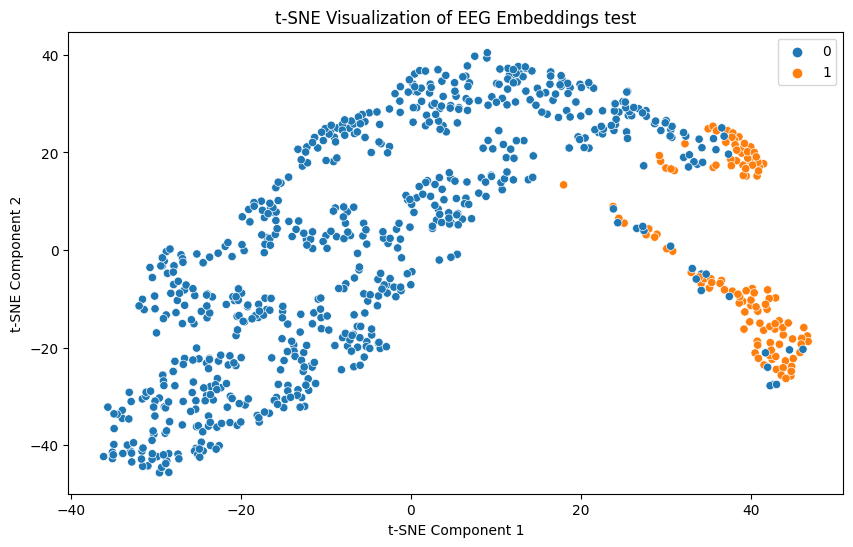

In [142]:
# Нормализация эмбеддингов
embeddings = StandardScaler().fit_transform(new_emb)

# Кластеризация DBSCAN
# dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
# labels = dbscan.fit_predict(embeddings)

# Визуализация t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=new_lab, palette='tab10', legend='full')
plt.title("t-SNE Visualization of EEG Embeddings test")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

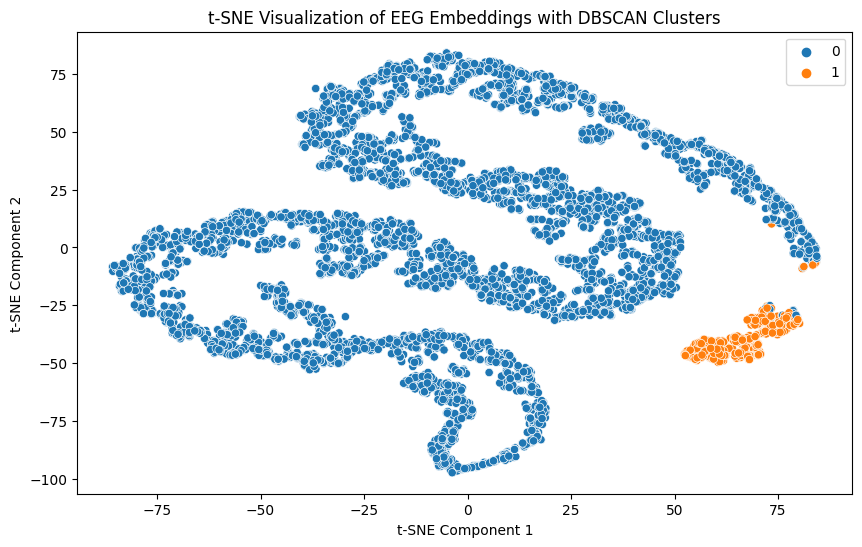

In [ ]:
# Нормализация эмбеддингов
embeddings = StandardScaler().fit_transform(new_emb)

# Кластеризация DBSCAN
# dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
# labels = dbscan.fit_predict(embeddings)

# Визуализация t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=new_lab, palette='tab10', legend='full')
plt.title("t-SNE Visualization of EEG Embeddings test")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def perform_dbscan_tsne(embeddings, eps=0.5, min_samples=5):
    """
    Выполняет кластеризацию DBSCAN и визуализирует результаты с помощью t-SNE.

    Args:
        embeddings (numpy.ndarray): Матрица эмбеддингов (num_samples, embedding_dim).
        eps (float): Параметр DBSCAN, радиус окрестности точки.
        min_samples (int): Минимальное количество точек в кластере.

    Returns:
        labels (numpy.ndarray): Метки кластеров для каждого эмбеддинга.
    """
    # Нормализация эмбеддингов
    embeddings = StandardScaler().fit_transform(embeddings)
    
    # Кластеризация DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(embeddings)
    
    # Визуализация t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='tab10', legend='full')
    plt.title("t-SNE Visualization of EEG Embeddings with DBSCAN Clusters")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()
    
    return labels

def plot_eeg_clusters(eeg_data, labels, segment_length, stride=64):
    """
    Визуализирует исходные ЭЭГ данные с изменением фона в зависимости от кластера.

    Args:
        eeg_data (numpy.ndarray): Данные ЭЭГ формы (Channels, Time).
        labels (numpy.ndarray): Метки кластеров для каждого сегмента.
        segment_length (int): Длина сегмента.
        stride (int): Шаг окна.
    """
    time_axis = np.arange(len(labels)) * stride
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    fig, ax = plt.subplots(figsize=(15, 5))
    for i, channel_data in enumerate(eeg_data):
        ax.plot(channel_data * 1000000 + i * 50, color='black', alpha=0.6)  # Смещение для каналов
    
    for idx, (start, label) in enumerate(zip(time_axis, labels)):
        ax.axvspan(start, start + segment_length, color=label_color_map[label], alpha=0.3)
    
    ax.set_title("EEG Signal with DBSCAN Clusters")
    ax.set_xlabel("Time")
    ax.set_ylabel("EEG Channels")
    plt.show()

In [109]:
emb.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [108]:
labels = perform_dbscan_tsne(emb, eps=0.05, min_samples=100)

ValueError: Expected 2D array, got 1D array instead:
array=[225.  32.  16.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [94]:
test_raw = mne.io.read_raw_eeglab('/Users/egorperelygin/EEG/panina1_ann.set',preload=True)

Reading /Users/egorperelygin/EEG/panina1_ann.fdt
Reading 0 ... 46596  =      0.000 ...   465.960 secs...


In [31]:
test_raw_new = mne.io.read_raw_edf('/Users/egorperelygin/Downloads/ЭПИ050125.edf',preload=True)

Extracting EDF parameters from /Users/egorperelygin/Downloads/ЭПИ050125.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3671859  =      0.000 ... 36718.590 secs...


In [101]:
test_raw.filter(l_freq=10.0, h_freq=40.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 133 samples (1.330 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.1s finished


<RawEDF | ЭПИ050125.edf, 19 x 3671860 (36718.6 s), ~532.3 MB, data loaded>

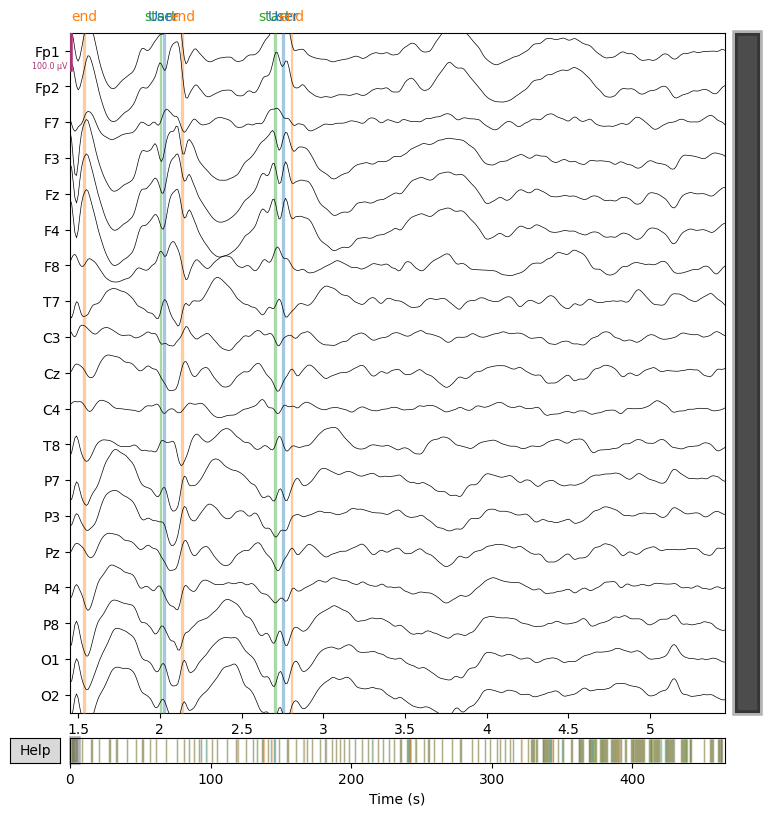

In [99]:
p=test_raw.plot(start=1.45,duration=4,scalings=dict(eeg=500e-7))

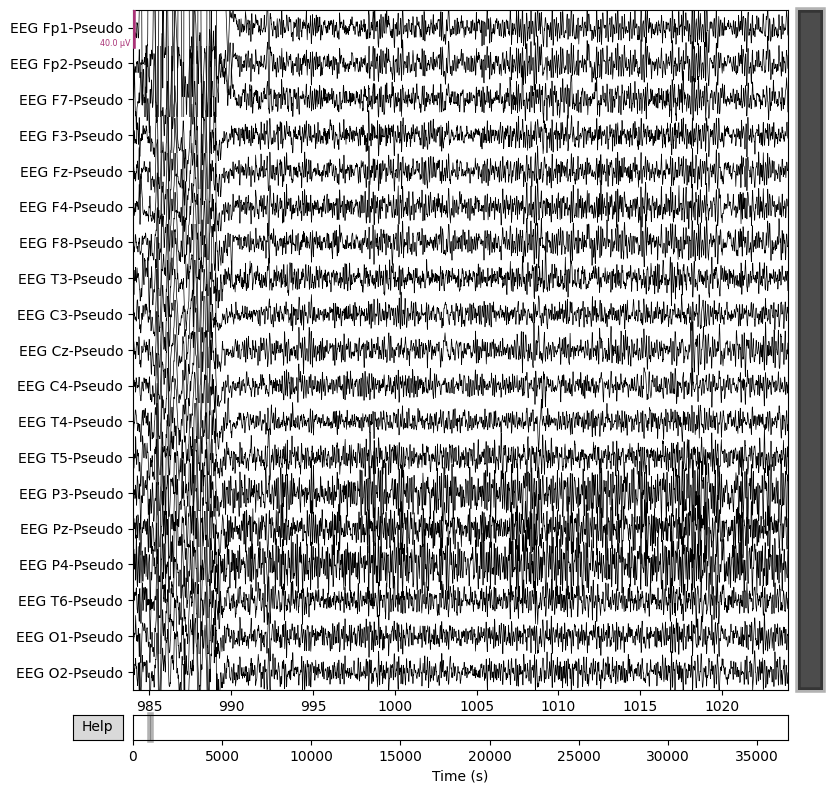

In [59]:
p=test_raw_new.plot(start=984,duration=40,scalings=dict(eeg=200e-7))

In [82]:
import numpy as np
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
def sliding_window_segments(raw_data, segment_length, stride=8):
    num_channels, total_length = raw_data.shape
    if segment_length > total_length:
        raise ValueError("Segment length cannot be greater than the total length of the data.")
    if stride <= 0:
        raise ValueError("Stride must be a positive integer.")

    num_segments = (total_length - segment_length) // stride + 1

    # Создание скользящих окон
    windows = np.lib.stride_tricks.as_strided(
        raw_data,
        shape=(num_segments, num_channels, segment_length),
        strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1]),
    )

    return windows
def plot_eeg_with_similarity(eeg_data, plot_data, model, anomaly_segment, segment_length, stride=1):
    """
    Вычисляет косинусное расстояние эмбеддингов и строит график.

    Args:
        eeg_data (numpy.ndarray): Данные ЭЭГ формы (Channels, Time).
        model (torch.nn.Module): Обученная модель для получения эмбеддингов.
        anomaly_interval (tuple): Временной интервал (start, end) аномальной области.
        segment_length (int): Длина сегмента.
        stride (int): Шаг окна.

    Returns:
        None. Строит график сигнала и косинусных расстояний.
    """
    # Выделяем аномальную область
#     anomaly_start, anomaly_end = anomaly_interval
#     anomaly_segment = eeg_data[:, anomaly_start:anomaly_end]
    if anomaly_segment.shape[1] != segment_length:
        print(anomaly_segment.shape)
        raise ValueError("Аномальная область должна быть равна segment_length.")

    # Вычисляем эмбеддинг аномального сегмента
    model.eval()
    with torch.no_grad():
        anomaly_embed = model(torch.tensor(anomaly_segment).unsqueeze(0).unsqueeze(0).float().to(mps_device))

    # Генерация сегментов из всего сигнала
#     print(eeg_data)
    all_segments = sliding_window_segments(eeg_data, segment_length, stride)
    num_segments = all_segments.shape[0]

    # Вычисляем эмбеддинги для всех сегментов
    similarities = []
    batch_size = 64
    with torch.no_grad():
        for start_idx in range(0, num_segments, batch_size):
            # Формирование батча
            batch_segments = all_segments[start_idx:start_idx + batch_size]
            mean = batch_segments.mean(axis=-1)
            std = batch_segments.std(axis=-1)
            batch = (batch_segments - mean[:,:, np.newaxis]) / std[:,:, np.newaxis]
            batch_tensor = torch.tensor(batch).unsqueeze(1).float().to(mps_device)  # (Batch, 1, Channels, Segment Length)

            # Пропуск через модель
            batch_embeds = model(batch_tensor)  # (Batch, Embedding Dim)

            # Вычисление косинусного расстояния для батча
            batch_similarities = cosine_similarity(anomaly_embed, batch_embeds, dim=1)  # (Batch,)
            similarities.extend(batch_similarities.cpu().numpy())
        if start_idx % 1024:
            print(start_idx)

    # Преобразуем данные для визуализации
    similarities = np.array(similarities)
    time_axis = np.arange(len(similarities)) * stride

    # Построение графиков
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # График ЭЭГ
    scaling_factor = 1e6  # Масштабируем сигнал, если нужно
    for i, channel_data in enumerate(plot_data):
        axes[0].plot(channel_data * scaling_factor + i * 50)  # смещение для каждого канала

    
#     axes[0].axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label="Anomalous Region")
#     axes[0].set_title("EEG Signal")
#     axes[0].legend()

    # График косинусного расстояния
    axes[1].plot(time_axis, similarities, label="Cosine Similarity", color="blue")
    axes[1].set_title("Cosine Distance")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Cosine Distance")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("example_norm.png")
    plt.show()
    return anomaly_embed
def find_similarity(eeg_data, plot_data, model, anomaly_segment, segment_length, stride=1):
    """
    Вычисляет косинусное расстояние эмбеддингов и строит график.

    Args:
        eeg_data (numpy.ndarray): Данные ЭЭГ формы (Channels, Time).
        model (torch.nn.Module): Обученная модель для получения эмбеддингов.
        anomaly_interval (tuple): Временной интервал (start, end) аномальной области.
        segment_length (int): Длина сегмента.
        stride (int): Шаг окна.

    Returns:
        None. Строит график сигнала и косинусных расстояний.
    """
    # Выделяем аномальную область
#     anomaly_start, anomaly_end = anomaly_interval
#     anomaly_segment = eeg_data[:, anomaly_start:anomaly_end]
    if anomaly_segment.shape[1] != segment_length:
        raise ValueError("Аномальная область должна быть равна segment_length.")

    # Вычисляем эмбеддинг аномального сегмента
    model.eval()
    with torch.no_grad():
        anomaly_embed = model(torch.tensor(anomaly_segment).unsqueeze(0).unsqueeze(0).float().to(mps_device))

    # Генерация сегментов из всего сигнала
#     print(eeg_data)
    

    # Вычисляем эмбеддинги для всех сегментов
    similarities = []
    batch_size = 64
    batch = []
    with torch.no_grad():
        for start_idx in range(0, eeg_data.shape[1]-segment_length):
            # Формирование батча
            if len(batch) == 64:
                batch = np.array(batch)
                mean = batch.mean(axis=-1)
                std = batch.std(axis=-1)
                batch = (batch - mean[:,:, np.newaxis]) / std[:,:, np.newaxis]
                batch_tensor = torch.tensor(batch).unsqueeze(1).float().to(mps_device)
                batch_embeds = model(batch_tensor)
                batch_similarities = cosine_similarity(anomaly_embed, batch_embeds, dim=1)  # (Batch,)
                similarities.extend(batch_similarities.cpu().numpy())
                batch = []
            batch.append(eeg_data[:, start_idx:start_idx+segment_length])
            if start_idx % 1024 == 0:
                print(start_idx)
            # Пропуск через модель
              # (Batch, Embedding Dim)

            # Вычисление косинусного расстояния для батча
            
        
    return similarities

In [101]:
eeg_data = test_raw.get_data()

In [33]:
eeg_data_new = test_raw_new.get_data()

In [13]:
ica = FastICA(n_components=eeg_data_new.shape[0], random_state=0)
ica_sources = ica.fit_transform(eeg_data_new.T).T 

/Users/egorperelygin/anaconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


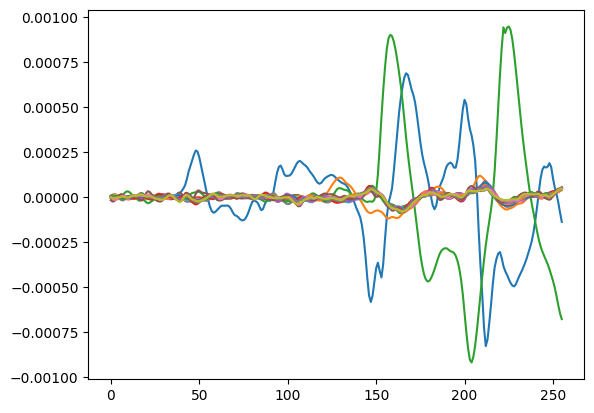

In [64]:
plt.plot(eeg_data_new[:,98400:98400+256].T)

9984


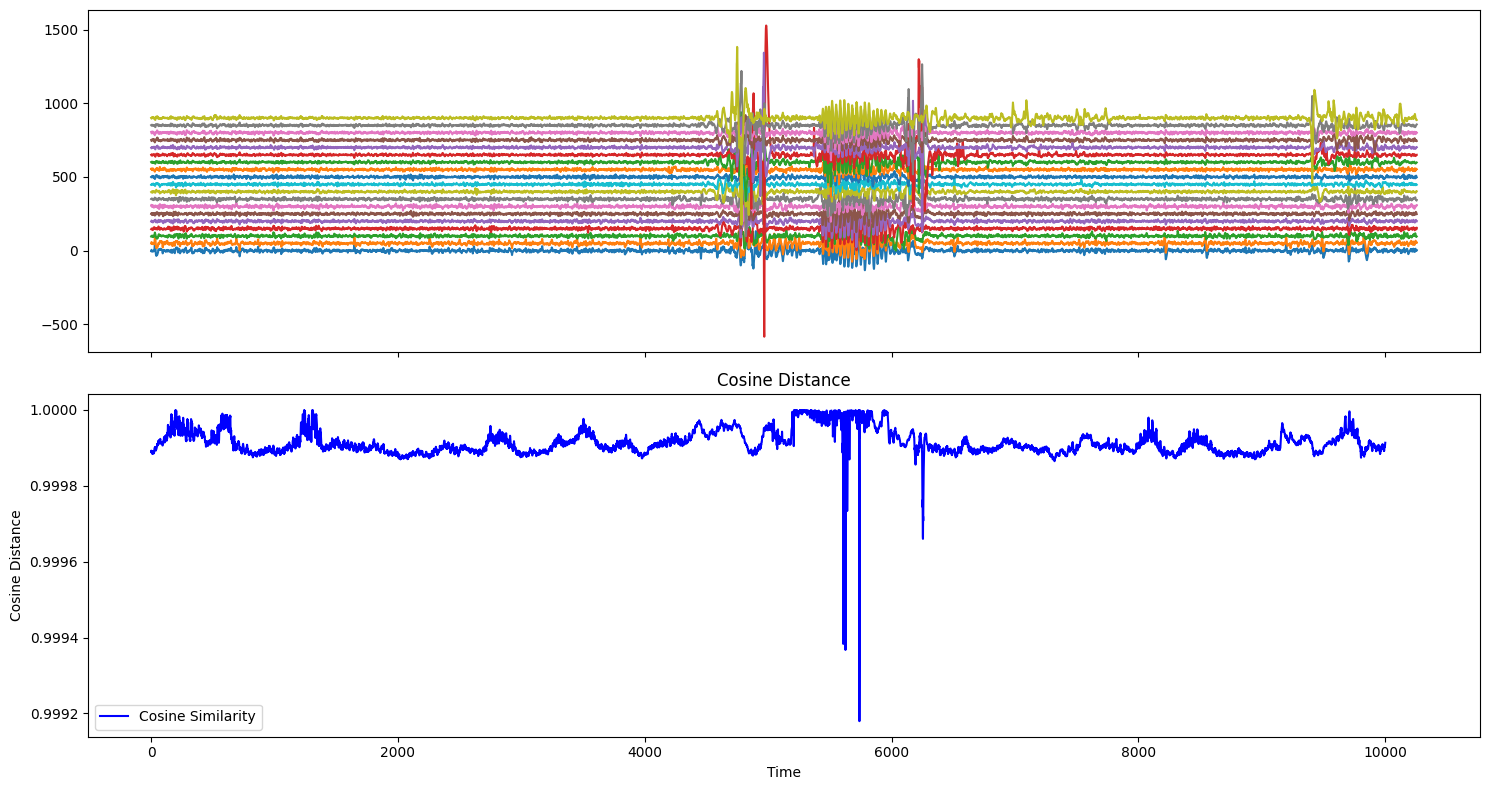

In [83]:
model=torch.load("triplet_128/resnet18_8_0.821900205310143_0.30243148821383475.pt")
# plot_eeg_with_similarity(eeg_data_new[:,-15000:], model, eeg_data_new[:,145:145+128], segment_length, stride=1)
an1 = plot_eeg_with_similarity(eeg_data_new[:,250000:260000+256], eeg_data_new[:,250000:260000+256], model, eeg_data_new[:,255500:255500+256], 256, stride=1)
# score = find_similarity(eeg_data_new[:,90400:150400+256], eeg_data_new[:,90400:150400+256], model, eeg_data_new[:,98400:98400+256], segment_length, stride=1)

9984


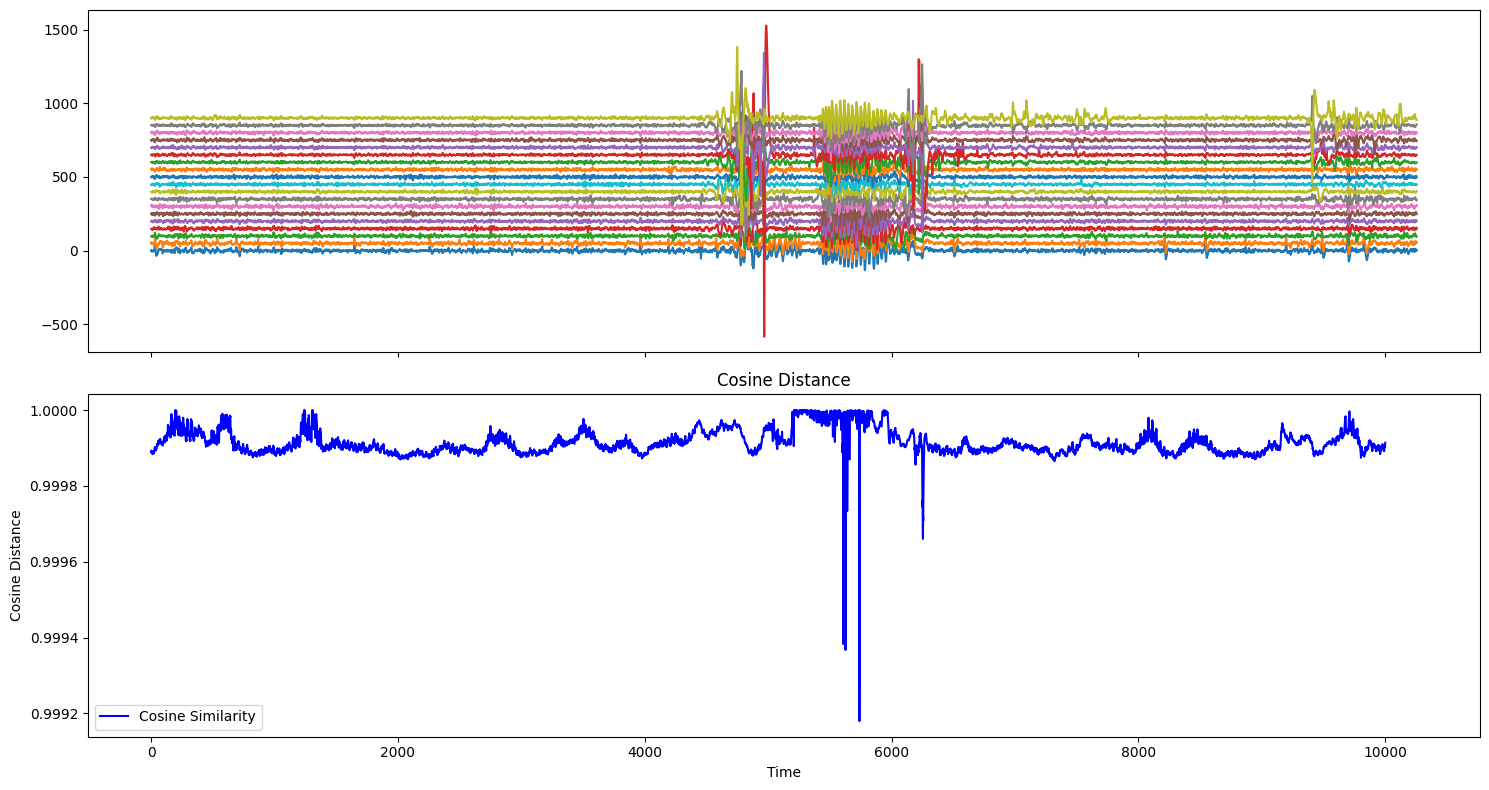

In [84]:
an2 = plot_eeg_with_similarity(eeg_data_new[:,250000:260000+256], eeg_data_new[:,250000:260000+256], model, eeg_data_new[:,250000:250000+256], 256, stride=1)

In [88]:
an1

tensor([[ 3.2408e-07, -5.3244e-08, -1.2889e-07, -8.8521e-06, -1.8475e-08,
         -3.7001e-08, -1.6131e-07,  1.7941e-04, -9.7179e-06, -3.4588e-07,
         -1.6052e-08, -1.6194e-04, -5.1373e-08, -4.5464e-08, -4.8138e-08,
         -5.3468e-08,  1.6209e-08, -5.1376e-08,  1.1445e-05,  1.6209e-08,
          4.4231e-06, -8.4553e-08, -1.5503e-06, -2.6647e-06,  8.4841e-06,
         -1.2592e-03, -3.0776e-08,  8.8589e-06,  1.6209e-08, -2.8735e-04,
          2.1945e-08, -4.2506e-08,  8.9202e-05, -5.3662e-08, -2.7685e-05,
          9.9759e-06,  2.7466e-03, -6.0830e-08, -5.0532e-09,  1.6209e-08,
         -5.1397e-08, -3.8850e-08, -2.6111e-05, -9.7397e-06, -4.3862e-08,
          4.1461e-06, -3.7333e-06, -4.9696e-08, -4.3325e-08,  1.8984e-08,
         -4.7592e-08, -5.1376e-08,  1.7472e-08, -4.3325e-08, -2.7487e-05,
          2.9266e-08, -1.4991e-08,  1.8759e-08,  3.8689e-06, -4.5677e-08,
         -1.2651e-07, -3.5349e-08, -4.3325e-08, -1.8373e-08,  2.1944e-08,
          1.6820e-08,  1.0940e-08, -1.

In [89]:
an2

tensor([[ 3.2411e-07, -5.3244e-08, -1.2889e-07, -8.8522e-06, -1.8475e-08,
         -3.7001e-08, -1.6131e-07,  1.7941e-04, -9.7180e-06, -3.4588e-07,
         -1.6052e-08, -1.6195e-04, -5.1373e-08, -4.5464e-08, -4.8138e-08,
         -5.3468e-08,  1.6209e-08, -5.1376e-08,  1.1445e-05,  1.6209e-08,
          4.4231e-06, -8.4553e-08, -1.5503e-06, -2.6647e-06,  8.4842e-06,
         -1.2592e-03, -3.0776e-08,  8.8588e-06,  1.6209e-08, -2.8735e-04,
          2.1945e-08, -4.2506e-08,  8.9202e-05, -5.3662e-08, -2.7685e-05,
          9.9759e-06,  2.7466e-03, -6.0830e-08, -5.0532e-09,  1.6209e-08,
         -5.1397e-08, -3.8850e-08, -2.6111e-05, -9.7399e-06, -4.3862e-08,
          4.1461e-06, -3.7334e-06, -4.9696e-08, -4.3325e-08,  1.8984e-08,
         -4.7592e-08, -5.1376e-08,  1.7472e-08, -4.3325e-08, -2.7487e-05,
          2.9266e-08, -1.4991e-08,  1.8759e-08,  3.8689e-06, -4.5677e-08,
         -1.2651e-07, -3.5349e-08, -4.3325e-08, -1.8373e-08,  2.1944e-08,
          1.6820e-08,  1.0940e-08, -1.

20352


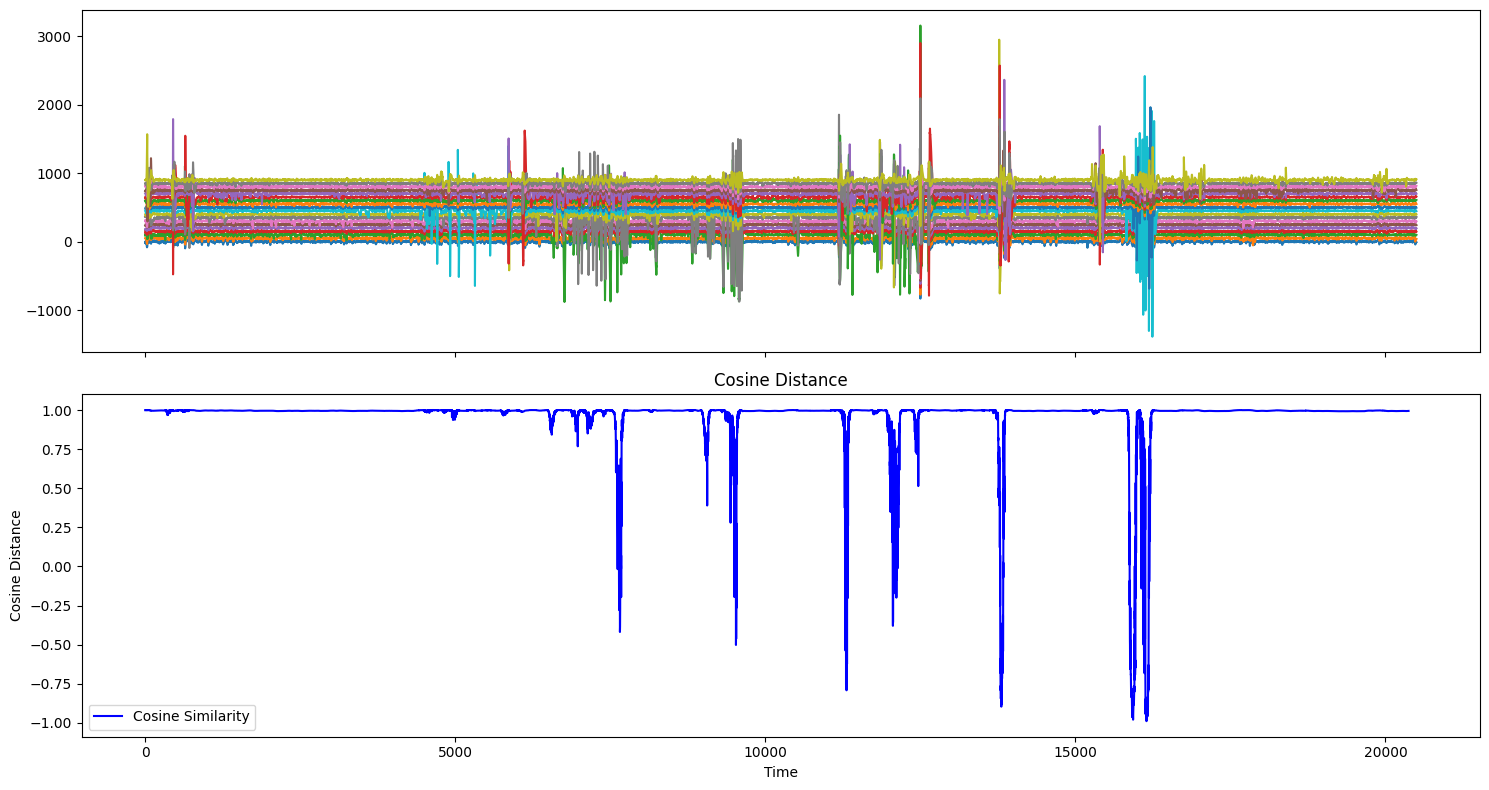

In [23]:
model=torch.load("train_anom_arcface/resnet18_14_0.9409822012031759_-0.9069979415949178.pt")
plot_eeg_with_similarity(ica_sources[:,191000:211500], eeg_data_new[:,191000:211500], model, ica_sources[:,98530:98530+128], segment_length, stride=1)
# plot_eeg_with_similarity(eeg_data[:,191000:211500], model, eeg_data[:,98530:98530+128], segment_length, stride=1)
# score = find_similarity(eeg_data[:,191000:211500], model, eeg_data[:,98530:98530+128], segment_length, stride=1)

20352


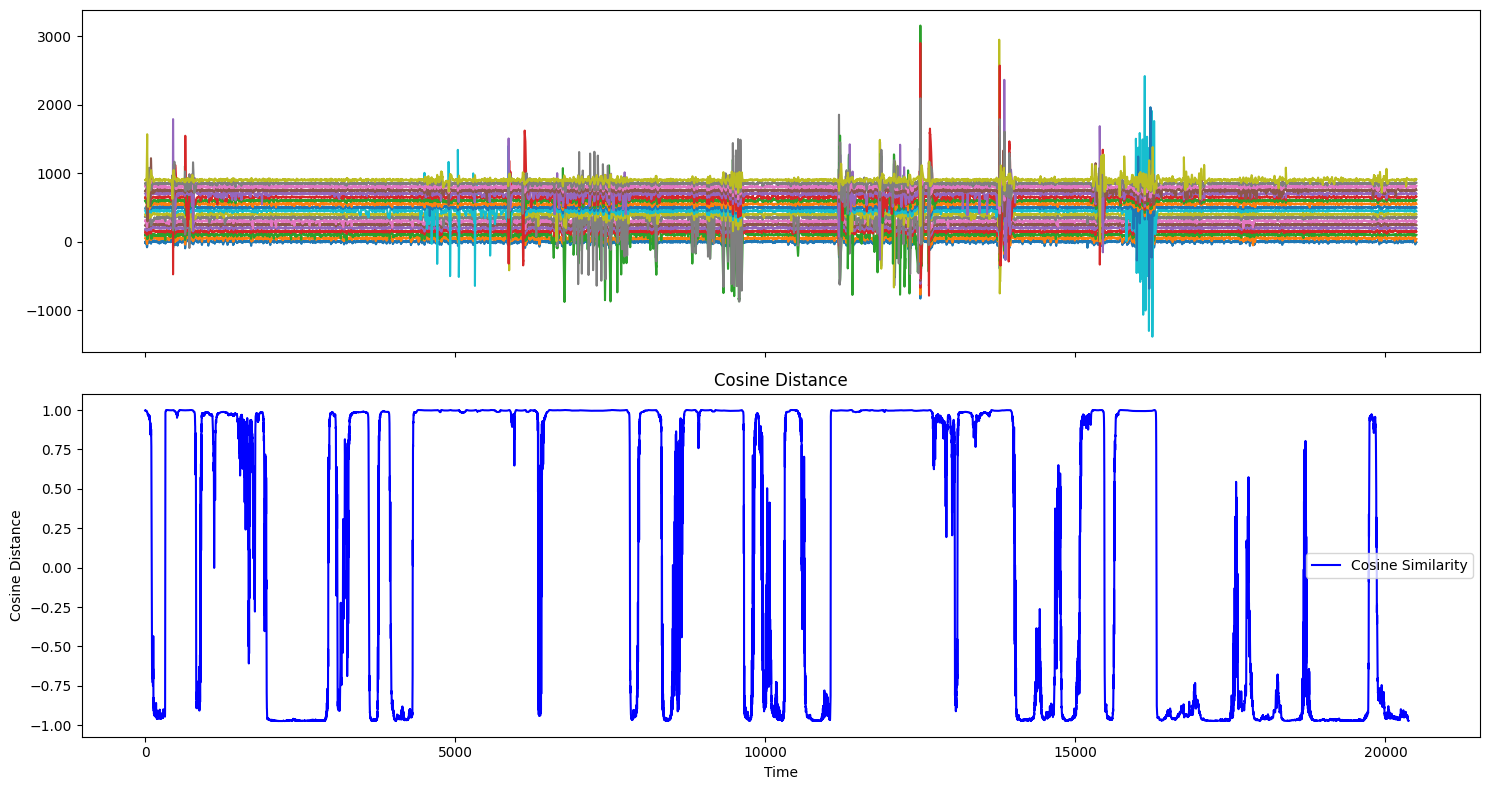

In [109]:
model=torch.load("/Users/egorperelygin/train_anom_arcface/resnet18_19_0.6475128161470618_-0.270769019825441.pt")
plot_eeg_with_similarity(eeg_data_new[:,191000:211500], eeg_data_new[:,191000:211500] model, eeg_data_new[:,98530:98530+128], segment_length, stride=1)
# plot_eeg_with_similarity(eeg_data[:,191000:211500], model, eeg_data[:,98530:98530+128], segment_length, stride=1)
# score = find_similarity(eeg_data[:,191000:211500], model, eeg_data[:,98530:98530+128], segment_length, stride=1)

In [128]:
import numpy as np
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

def compute_correlation_matrix(eeg_segment):
#     print(eeg_segment.shape)
    eeg_segment = eeg_segment - eeg_segment.mean(dim=1, keepdim=True)
    std = eeg_segment.std(dim=1, keepdim=True) + 1e-6
    normalized = eeg_segment / std
    correlation_matrix = torch.mm(normalized, normalized.T) / normalized.shape[1]
    return correlation_matrix


def sliding_window_segments(raw_data, segment_length, stride=8):
    num_channels, total_length = raw_data.shape
    if segment_length > total_length:
        raise ValueError("Segment length cannot be greater than the total length of the data.")
    if stride <= 0:
        raise ValueError("Stride must be a positive integer.")

    num_segments = (total_length - segment_length) // stride + 1

    # Создание скользящих окон
    windows = np.lib.stride_tricks.as_strided(
        raw_data,
        shape=(num_segments, num_channels, segment_length),
        strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1]),
    )

    return windows
def plot_eeg_with_similarity(eeg_data, model, anomaly_segment, segment_length, stride=1):
    """
    Вычисляет косинусное расстояние эмбеддингов и строит график.

    Args:
        eeg_data (numpy.ndarray): Данные ЭЭГ формы (Channels, Time).
        model (torch.nn.Module): Обученная модель для получения эмбеддингов.
        anomaly_interval (tuple): Временной интервал (start, end) аномальной области.
        segment_length (int): Длина сегмента.
        stride (int): Шаг окна.

    Returns:
        None. Строит график сигнала и косинусных расстояний.
    """
    # Выделяем аномальную область
#     anomaly_start, anomaly_end = anomaly_interval
#     anomaly_segment = eeg_data[:, anomaly_start:anomaly_end]
    if anomaly_segment.shape[1] != segment_length:
        print(anomaly_segment.shape)
        raise ValueError("Аномальная область должна быть равна segment_length.")

    # Вычисляем эмбеддинг аномального сегмента
    model.eval()
#     with torch.no_grad():
#         anomaly_embed = model(torch.tensor(anomaly_segment).unsqueeze(0).unsqueeze(0).float().to(mps_device))

    # Генерация сегментов из всего сигнала
#     print(eeg_data)
    all_segments = sliding_window_segments(eeg_data, segment_length, stride)
    num_segments = all_segments.shape[0]

    # Вычисляем эмбеддинги для всех сегментов
    similarities = []
    batch_size = 64
    batch = []
    with torch.no_grad():
        for start_idx in range(0, eeg_data.shape[1]-segment_length):
            # Формирование батча
            if len(batch) == 64:
                batch = np.array(batch)
                batch_tensor = torch.tensor(batch).float().to(mps_device)
                batch_embeds = model(batch_tensor)
#                 batch_similarities = cosine_similarity(anomaly_embed, batch_embeds, dim=1)  # (Batch,)
                similarities.extend(batch_embeds.cpu().numpy())
                batch = []
            batch_segments = compute_correlation_matrix(torch.tensor(eeg_data[:, start_idx:start_idx+segment_length], dtype=torch.float32))
            batch.append(np.array(batch_segments))
            if start_idx % 1024 == 0:
                print(start_idx)

    # Преобразуем данные для визуализации
    similarities = np.array(similarities)
    time_axis = np.arange(len(similarities)) * stride

    # Построение графиков
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # График ЭЭГ
    scaling_factor = 1e6  # Масштабируем сигнал, если нужно
    for i, channel_data in enumerate(eeg_data):
        axes[0].plot(channel_data * scaling_factor + i * 50)  # смещение для каждого канала

    
#     axes[0].axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label="Anomalous Region")
#     axes[0].set_title("EEG Signal")
#     axes[0].legend()

    # График косинусного расстояния
    axes[1].plot(time_axis, similarities, label="Cosine Similarity", color="blue")
    axes[1].set_title("Cosine Distance")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Cosine Distance")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("example_norm.png")
    plt.show()
def find_similarity(eeg_data, model, anomaly_segment, segment_length, stride=1):
    """
    Вычисляет косинусное расстояние эмбеддингов и строит график.

    Args:
        eeg_data (numpy.ndarray): Данные ЭЭГ формы (Channels, Time).
        model (torch.nn.Module): Обученная модель для получения эмбеддингов.
        anomaly_interval (tuple): Временной интервал (start, end) аномальной области.
        segment_length (int): Длина сегмента.
        stride (int): Шаг окна.

    Returns:
        None. Строит график сигнала и косинусных расстояний.
    """
    # Выделяем аномальную область
#     anomaly_start, anomaly_end = anomaly_interval
#     anomaly_segment = eeg_data[:, anomaly_start:anomaly_end]
    print(anomaly_segment.shape[1])
    if anomaly_segment.shape[1] != segment_length:
        raise ValueError("Аномальная область должна быть равна segment_length.")

    # Вычисляем эмбеддинг аномального сегмента
    model.eval()
#     with torch.no_grad():
#         anomaly_embed = model(torch.tensor(anomaly_segment).unsqueeze(0).unsqueeze(0).float().to(mps_device))

    # Генерация сегментов из всего сигнала
#     print(eeg_data)
    

    # Вычисляем эмбеддинги для всех сегментов
    similarities = []
    batch_size = 64
    batch = []
    with torch.no_grad():
        for start_idx in range(0, eeg_data.shape[1]-segment_length):
            # Формирование батча
            if len(batch) == 64:
                batch = np.array(batch)
                batch_tensor = torch.tensor(batch).float().to(mps_device)
                batch_embeds = model(batch_tensor)
#                 batch_similarities = cosine_similarity(anomaly_embed, batch_embeds, dim=1)  # (Batch,)
                similarities.extend(batch_embeds.cpu().numpy())
                batch = []
            batch_segments = compute_correlation_matrix(torch.tensor(eeg_data[:, start_idx:start_idx+segment_length], dtype=torch.float32))
            batch.append(np.array(batch_segments))
            if start_idx % 1024 == 0:
                print(start_idx)
            # Пропуск через модель
              # (Batch, Embedding Dim)

            # Вычисление косинусного расстояния для батча
            
        
    return similarities

0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456


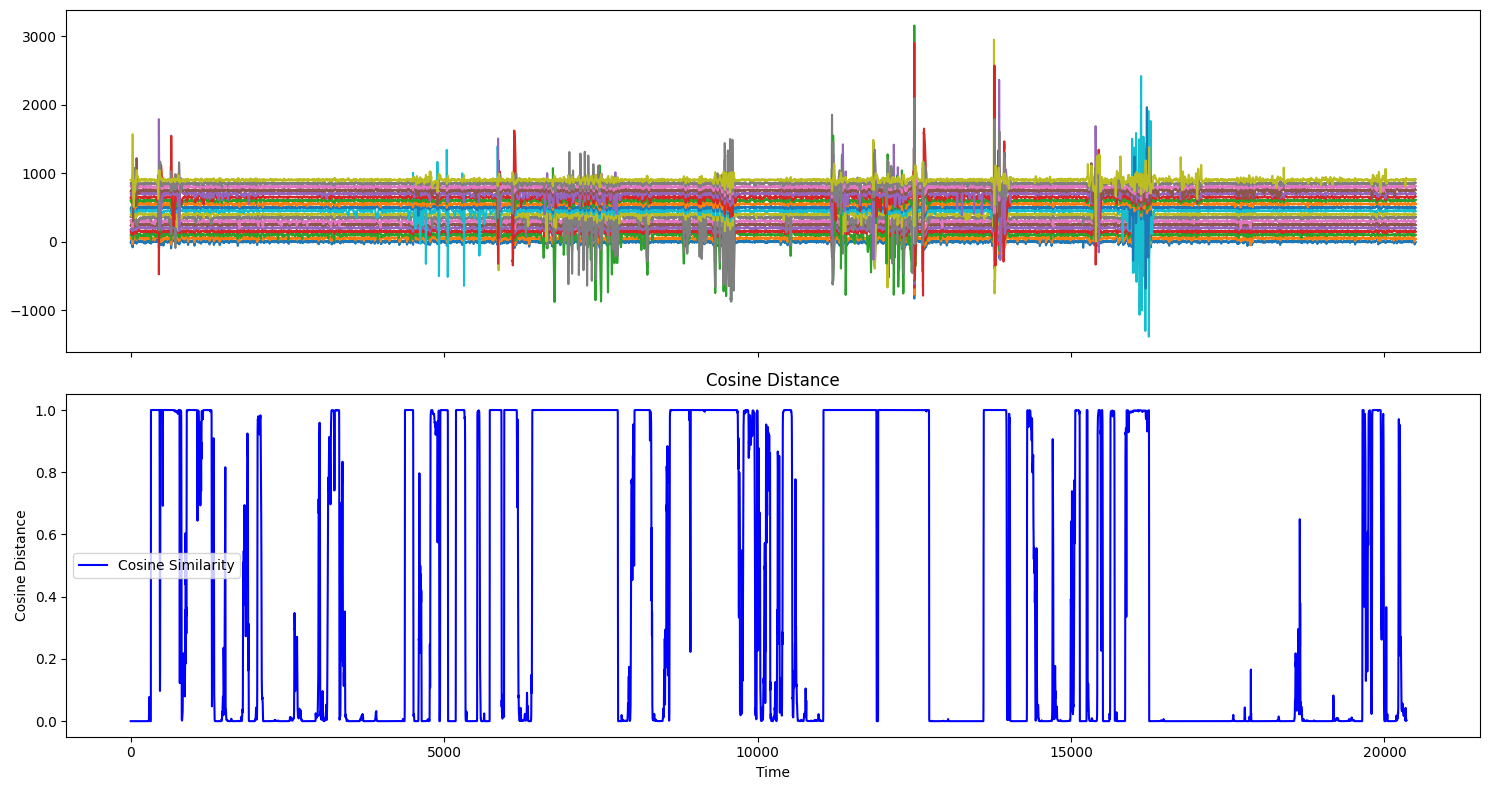

128
0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456


In [130]:
model=torch.load("/Users/egorperelygin/train_corr/resnet18_5_0.9621083159952084.pt").to(mps_device)
plot_eeg_with_similarity(eeg_data_new[:,191000:211500], model, eeg_data_new[:,98530:98530+128], segment_length, stride=1)
# plot_eeg_with_similarity(eeg_data[:,191000:211500], model, eeg_data[:,98530:98530+128], segment_length, stride=1)
score = find_similarity(eeg_data_new[:,191000:211500], model, eeg_data_new[:,98530:98530+128], segment_length, stride=1)

In [145]:
параметризация эпифеноменов.

SyntaxError: invalid syntax (1459452333.py, line 1)

In [ ]:
независимые комп.
визуально проверить после предобработки()

In [16]:
import os
import numpy as np
import pandas as pd
import mne
from kats.tsfeatures.tsfeatures import TsFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def sliding_window_segments(raw_data, segment_length=128, stride=8):
    """
    Разбивает сигнал на скользящие окна.
    
    :param raw_data: np.array (каналы, временные точки)
    :param segment_length: Длина окна
    :param stride: Шаг окна
    :return: np.array (num_segments, num_channels, segment_length)
    """
    num_channels, total_length = raw_data.shape
    if segment_length > total_length:
        raise ValueError("Segment length cannot be greater than the total length of the data.")
    
    num_segments = (total_length - segment_length) // stride + 1

    windows = np.lib.stride_tricks.as_strided(
        raw_data,
        shape=(num_segments, num_channels, segment_length),
        strides=(raw_data.strides[1] * stride, raw_data.strides[0], raw_data.strides[1])
    )

    return windows

def extract_kats_features(signal):
    """
    Извлекает признаки из окна EEG с помощью Kats.
    
    :param signal: np.array (каналы, сегменты)
    :return: pandas.DataFrame с признаками
    """
    features = []
    for ch in range(signal.shape[0]):  # Проходим по каналам
        df = pd.DataFrame({"time": range(signal.shape[1]), "value": signal[ch]})
        feature_dict = TsFeatures().transform(df)
        features.append(pd.Series(feature_dict))

    return pd.concat(features, axis=0).values  # Соединяем признаки всех каналов

def load_and_process_eeg(files, segment_length=128, stride=8):
    """
    Загружает EEG-файлы, разбивает их на окна и извлекает признаки.
    
    :param files: список путей к файлам .set
    :param segment_length: Длина сегмента
    :param stride: Шаг окна
    :return: np.array (количество окон, признаки)
    """
    all_features = []
    
    for file in files:
        raw = mne.io.read_raw_eeglab(file, preload=True)
        raw_data = raw.get_data()  # (каналы, временные точки)

        segments = sliding_window_segments(raw_data, segment_length, stride)  # Разбиваем на окна
        for segment in segments:
            features = extract_kats_features(segment)  # Извлекаем признаки
            all_features.append(features)
    
    return np.array(all_features)

# === Загружаем файлы ===
def process_all_files(folder, segment_length=128, stride=8):
    all_files = [f for f in os.listdir(folder) if f.endswith(".set")]
    
    epi_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_epi.set")]
    norm_files = [os.path.join(folder, f) for f in all_files if f.endswith("_full_norm.set")]

    train_files = epi_files[:-1] + norm_files[:-1]
    val_files = [epi_files[-1]] + [norm_files[-1]]

    print(f"Train: {len(train_files)}, Validation: {len(val_files)}")

    train_features = load_and_process_eeg(train_files, segment_length, stride)
    val_features = load_and_process_eeg(val_files, segment_length, stride)

    return train_features, val_features

# === Запуск обработки ===
folder = "/Users/egorperelygin/Downloads/обучение"  # Укажи путь
train_data, val_data = process_all_files(folder)

# === Нормализация признаков ===
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)

# === Кластеризация DBSCAN ===
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters = dbscan.fit_predict(train_data)

print("Кластеры:", np.unique(clusters))


ModuleNotFoundError: No module named 'kats'

In [33]:
pip install kats


  Using cached kats-0.2.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached numpy-1.21.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached pandas-1.3.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.7.3-1-cp310-cp310-macosx_12_0_arm64.whl.metadata (2.2 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached statsmodels-0.12.2.tar.gz (17.5 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [194 lines of output]
      Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
      Ignoring numpy: markers 'python_v

Note: you may need to restart the kernel to use updated packages.


In [18]:
!xcode-select --install


xcode-select: note: install requested for command line developer tools


In [32]:
!pip install matplotlib


  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
gym 0.21.0 requires cloudpickle>=1.2.0, which is not installed.
open3d 0.17.0 requires werkzeug>=2.2.3, which is not installed.
pandas 2.2.3 requires pytz>=2020.1, which is not installed.
tensorboard 2.14.1 requires werkzeug>=1.0.1, which is not installed.
tensorflow-probability 0.20.1 requires cloudpickle>=1.3, which is not installed.
fastdup 1.72 requires requests==2.28.1, but you have requests 2.32.3 which is incompatible.

[notice] A new release of pip is av

In [29]:
!pip uninstall numpy -y
!pip uninstall mlflow -y

Found existing installation: numpy 2.2.3
Uninstalling numpy-2.2.3:
  Successfully uninstalled numpy-2.2.3


In [22]:
!pip uninstall numba -y
!pip uninstall FuzzyTM -y
!pip uninstall stumpy -y
!pip uninstall requests -y
!pip uninstall cloudpickle -y
!pip uninstall importlib-metadata -y
!pip uninstall packaging -y
!pip uninstall pytz -y
!pip uninstall werkzeug -y


Found existing installation: requests 2.32.3
Uninstalling requests-2.32.3:
  Successfully uninstalled requests-2.32.3
Found existing installation: cloudpickle 3.1.1
Uninstalling cloudpickle-3.1.1:
  Successfully uninstalled cloudpickle-3.1.1
Found existing installation: importlib_metadata 8.5.0
Uninstalling importlib_metadata-8.5.0:
  Successfully uninstalled importlib_metadata-8.5.0
Found existing installation: packaging 24.2
Uninstalling packaging-24.2:
  Successfully uninstalled packaging-24.2
Found existing installation: pytz 2025.1
Uninstalling pytz-2025.1:
  Successfully uninstalled pytz-2025.1
Found existing installation: Werkzeug 2.2.2
Uninstalling Werkzeug-2.2.2:
  Successfully uninstalled Werkzeug-2.2.2
